In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')

import ipywidgets as widgets
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error

import scipy.stats as sps
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import linear_model

In [2]:
import warnings

warnings.filterwarnings("ignore")

---

Cравним свойства линейных регрессионных моделей: обычной и с регуляризациями &mdash; Lasso, Ridge, Elastic Net.  

Скачаем данные <a href="https://dasl.datadescription.com/datafile/cost-of-living-2018/?_sfm_cases=539+541">`cost of living 2018`</a>, в которых используйте следующие столбцы:
* `City` &mdash; город, данные для которого приводятся.
* `Cost of Living Index` &mdash; является относительным показателем цен на потребительские товары, включая продукты, рестораны, транспорт и коммунальные услуги. Cost of Living Index не включает расходы на проживание, такие как аренда или ипотека. Если город имеет индекс стоимости жизни 120, это означает, что Numbeo оценивает его на 20% дороже, чем Нью-Йорк.

* `Rent Index` &mdash; это оценка цен на аренду квартир в городе по сравнению с Нью-Йорком. Если индекс арендной платы равен 80, Numbeo оценивает, что цена аренды в этом городе в среднем на 20% меньше, чем цена в Нью-Йорке.

* `Cost of Living Plus Rent Index` &mdash; это оценка цен на потребительские товары, включая арендную плату, по сравнению с Нью-Йорком.

* `Restaurant Price Index` &mdash; сравнение цен на блюда и напитки в ресторанах и барах по сравнению с Нью-Йорк.

* `Local Purchasing Power Index` &mdash; показывает относительную покупательную способность при покупке товаров и услуг в данном городе за среднюю заработную плату в этом городе. Если внутренняя покупательная способность составляет 40, это означает, что жители этого города со средней зарплатой могут позволить себе покупать в среднем на 60% меньше товаров и услуг, чем жители Нью-Йорка со средней зарплатой по Нью-Йорку.

* `Groceries Index` &mdash; это оценка цен на продукты в городе по сравнению с Нью-Йорком. Для расчета этого раздела Number использует веса товаров в разделе "Рынки" для каждого города.

In [3]:
data = pd.read_csv('cost-of-living-2018.txt', sep='\t')
data = data[[
    'Cost of Living Index',
    'Rent Index',
    'Cost of Living Plus Rent Index',
    'Restaurant Price Index',
    'Local Purchasing Power Index',
    'Groceries Index'
]]
data.head()

Cost of Living Index  Rent Index  Cost of Living Plus Rent Index  \
0                145.43      110.87                          128.76   
1                141.25       66.14                          105.03   
2                134.83       71.70                          104.38   
3                130.68       49.68                           91.61   
4                128.03       43.57                           87.30   

   Restaurant Price Index  Local Purchasing Power Index  Groceries Index  
0                  158.75                        112.26           143.47  
1                  135.76                        142.70           149.86  
2                  129.74                        130.96           138.98  
3                  127.22                        139.01           127.54  
4                  119.48                        112.71           132.70

In [4]:
y = data['Groceries Index']
X = data[['Cost of Living Index', 'Rent Index', 
          'Cost of Living Plus Rent Index', 'Restaurant Price Index', 
          'Local Purchasing Power Index']]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train))
X_test_transformed = pd.DataFrame(scaler.transform(X_test))

X_train_transformed.columns = X_train.columns
X_test_transformed.columns = X_test.columns

In [7]:
def draw_track(model, X, y, log_min, log_max, num, title='', figsize=(12, 6)):
    """Данная функция строит график зависимости значений 
    коэффициентов модели от параметра регуляризации.
    
    :param model: модель
    :param X: регрессоры
    :param y: отклик
    :param log_min: десятичный логарифм 
        минимального значения коэффициента регуляризации
    :param log_max: десятичный логарифм 
        максимального значения коэффициента регуляризации
    :param num: количество элементов в сетке для коэффициента регуляризации
    :param title: заголовок графика
    :param figsize: размер полотна
    """
    
    alphas = np.logspace(log_min, log_max, num)   
    coefs = []
    for a in alphas:
        if 'l1_ratio' in model.get_params():
            # равномерно распределим alpha по обоим коэффициентам
            a *= 3/2
            model.set_params(alpha=a)
        else:
            model.set_params(alpha=a)
        model.fit(X, y)
        coefs.append(model.coef_)

    plt.figure(figsize=figsize)
    ax = plt.gca()
    ind = 1
    for coef in np.array(coefs).T:
        label = r'$\theta_{' + str(ind) + '}$'
        ax.plot(alphas, coef, linewidth=2, label=label)
        ind += 1
        
    ax.set_xscale('log')
    plt.xlabel('alpha', fontsize=19)
    plt.ylabel('weights', fontsize=19)
    plt.title(title, fontsize=22)
    plt.legend(loc='upper left', fontsize=15)
    plt.axis('tight')
    plt.show()

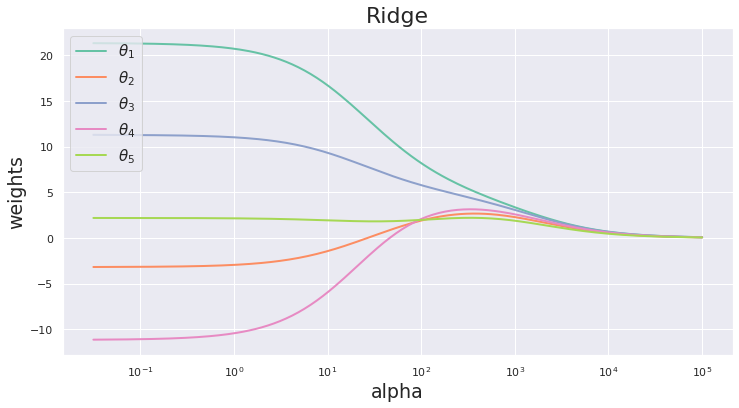

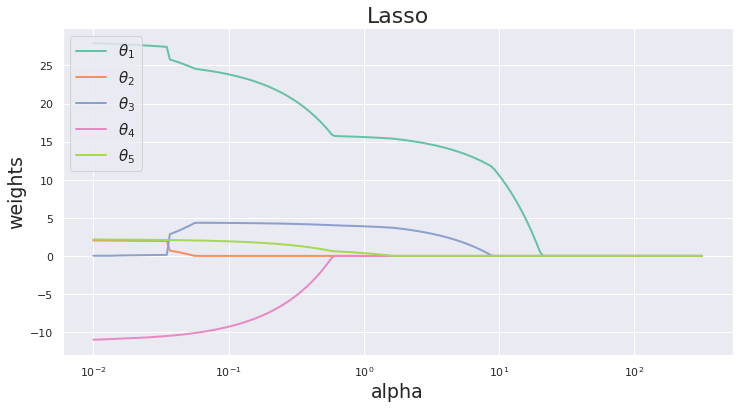

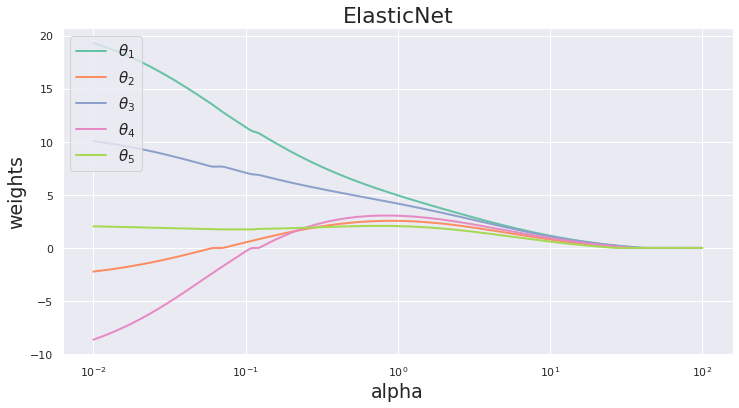

In [8]:
draw_track(Ridge(fit_intercept=False), X_train_transformed, y_train, -1.5, 5, 200, 
           title='Ridge')
draw_track(Lasso(fit_intercept=False), X_train_transformed, y_train, -2, 2.5, 200, 
           title='Lasso')
draw_track(ElasticNet(fit_intercept=False, l1_ratio=1/3), X_train_transformed, y_train, -2, 2, 200, 
           title='ElasticNet')

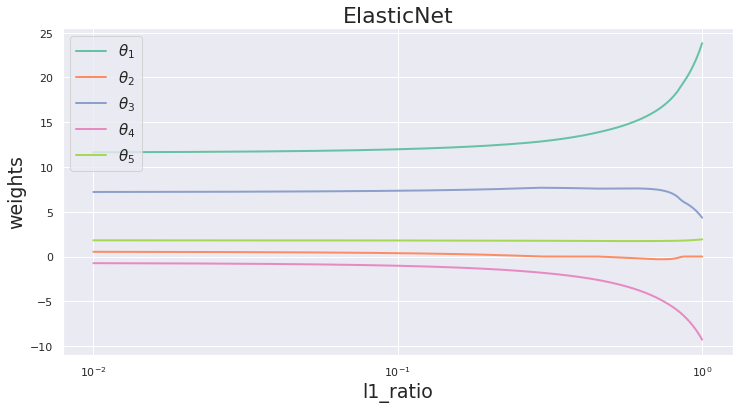

In [12]:
l1_ratio = np.logspace(-2, 0, 200)   
coefs = []
for l in l1_ratio:
    model = ElasticNet(alpha = 0.1, l1_ratio=l)
    model.fit(X_train_transformed, y_train)
    coefs.append(model.coef_)

plt.figure(figsize=(12, 6))
ax = plt.gca()
ind = 1
for coef in np.array(coefs).T:
    label = r'$\theta_{' + str(ind) + '}$'
    ax.plot(l1_ratio, coef, linewidth=2, label=label)
    ind += 1

ax.set_xscale('log')
plt.xlabel('l1_ratio', fontsize=19)
plt.ylabel('weights', fontsize=19)
plt.title('ElasticNet', fontsize=22)
plt.legend(loc='upper left', fontsize=15)
plt.axis('tight')
plt.show()

По графикам видно, что при больших $\alpha$ у нас веса становятся одинаковыми, что не очень хорошо. В графике l1_ratio вроде все хорошо. Давайте напишем приблизительные интервалы для $\alpha$:

1. Для Ridge регрессии: $[0.01, 10]$ 

2. Для Lasso: $[0.01, 0.1]$
 
3. Для ElasticNet: $[0.01, 0,1]$

Расчитаем индекс обусловленности для МНК-решения. Можно ли сделать вывод о мультиколлинеарности данных?  
Нарисуйте график зависимость индекса обусловленности от параметра регуляризации для Ridge-регрессии. 

In [11]:
num_X = np.array(X_train_transformed)
eig_val = np.linalg.svd(num_X.T @ num_X, full_matrices=True)[1]
np.sqrt(eig_val.max() / eig_val.min())

13257.11213716364

Для обычного МНК у нас IC очень большое, что не очень хорошо.

In [12]:
ci = []
for alpha in range(1, 30):
    num_X = np.array(X_train_transformed)
    eig_val = np.linalg.svd(num_X.T @ num_X + np.diag(np.full(5, alpha)), full_matrices=True)[1]
    ci.append(np.sqrt(eig_val.max() / eig_val.min()))

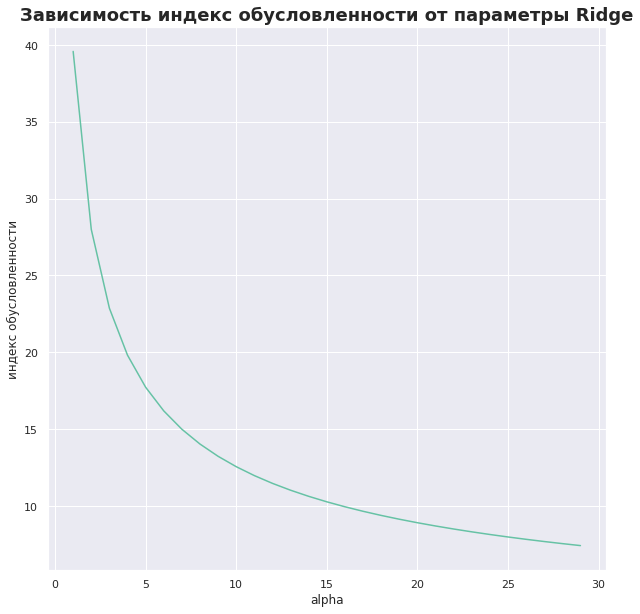

In [13]:
fig = plt.figure(figsize = (10, 10))
plt.plot(range(1, 30), ci)
plt.xlabel('alpha')
plt.ylabel('индекс обусловленности')
plt.title('Зависимость индекс обусловленности от параметры Ridge', fontsize = 18, fontweight = 'bold');

Как мы видим, при увеличении $\alpha$ у нас индекс обусловленности уменьшается. Ну это и логично, так как мы сильнее штрафуем увеличение весов.

**3.** На обучающей выборке с помощью поиска по сетке определите наилучшие параметры для Ridge, Lasso, Elastic моделей. В качестве метрики качества используйте среднеквадратичную ошибку (MSE).

In [14]:
def model_grid(model = 'Ridge'):
    parameters_grid = {
            'model__alpha' : np.linspace(0.00001, 3, num=1000),
        }
        
    if model == 'Ridge':
        model = Ridge()
    elif model == 'Lasso':
        model = Lasso()
    else:
        parameters_grid = parameters_grid = {
            'model__alpha' : np.linspace(0.00001, 2, num=500),
            'model__l1_ratio' : np.linspace(0.7, 1, num = 10)
        }
        model = ElasticNet()

        
    pipe = Pipeline(steps=[
        ('stnd_sc', StandardScaler()),
        ('model', model)
    ])

    ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
    gs = GridSearchCV(
        # модель для обучения, в нашем случае Ridge
        estimator=pipe,
        # сетка значений гиперпараметров
        param_grid=parameters_grid,
        # метрика качества, берем MSE
        scoring='neg_mean_squared_error',
        # GridSearch отлично параллелится, указываем количество параллельных джоб
        # -1 означает использование всех ядер
        n_jobs=-1,
        # стратегия кросс-валидации
        cv=ss,
        # сообщения с логами обучения: больше значение - больше сообщений
        verbose=False,
        # значение, присваиваемое scorer в случае ошибки при обучении
        error_score='raise'
    )
    return gs

In [15]:
gs_Ridge = model_grid()
gs_Ridge.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 3/5; 1/1000] START model__alpha=1e-05.......................................
[CV 3/5; 1/1000] END ......model__alpha=1e-05;, score=-34.926 total time=   0.0s
[CV 4/5; 2/1000] START model__alpha=0.003012992992992993........................
[CV 4/5; 2/1000] END model__alpha=0.003012992992992993;, score=-35.188 total time=   0.0s
[CV 3/5; 3/1000] START model__alpha=0.006015985985985985........................
[CV 3/5; 3/1000] END model__alpha=0.006015985985985985;, score=-34.571 total time=   0.0s
[CV 5/5; 3/1000] START model__alpha=0.006015985985985985........................
[CV 5/5; 3/1000] END model__alpha=0.006015985985985985;, score=-37.585 total time=   0.0s
[CV 3/5; 4/1000] START model__alpha=0.009018978978978978........................
[CV 3/5; 4/1000] END model__alpha=0.009018978978978978;, score=-34.575 total time=   0.0s
[CV 1/5; 5/1000] START model__alpha=0.012021971971971971........................
[CV 1/5;

[CV 5/5; 21/1000] END model__alpha=0.06006985985985986;, score=-37.597 total time=   0.0s
[CV 1/5; 22/1000] START model__alpha=0.06307285285285284........................
[CV 1/5; 22/1000] END model__alpha=0.06307285285285284;, score=-37.755 total time=   0.0s
[CV 2/5; 22/1000] START model__alpha=0.06307285285285284........................
[CV 2/5; 22/1000] END model__alpha=0.06307285285285284;, score=-36.282 total time=   0.0s
[CV 3/5; 22/1000] START model__alpha=0.06307285285285284........................
[CV 3/5; 22/1000] END model__alpha=0.06307285285285284;, score=-34.661 total time=   0.0s
[CV 3/5; 27/1000] START model__alpha=0.0780878178178178.........................
[CV 3/5; 27/1000] END model__alpha=0.0780878178178178;, score=-34.684 total time=   0.0s
[CV 4/5; 27/1000] START model__alpha=0.0780878178178178.........................
[CV 4/5; 27/1000] END model__alpha=0.0780878178178178;, score=-35.242 total time=   0.0s
[CV 5/5; 27/1000] START model__alpha=0.0780878178178178..

[CV 2/5; 137/1000] END model__alpha=0.408417047047047;, score=-36.620 total time=   0.0s
[CV 3/5; 137/1000] START model__alpha=0.408417047047047.........................
[CV 3/5; 137/1000] END model__alpha=0.408417047047047;, score=-35.211 total time=   0.0s
[CV 4/5; 137/1000] START model__alpha=0.408417047047047.........................
[CV 4/5; 137/1000] END model__alpha=0.408417047047047;, score=-35.498 total time=   0.0s
[CV 5/5; 137/1000] START model__alpha=0.408417047047047.........................
[CV 5/5; 137/1000] END model__alpha=0.408417047047047;, score=-37.698 total time=   0.0s
[CV 1/5; 138/1000] START model__alpha=0.41142004004004..........................
[CV 1/5; 138/1000] END model__alpha=0.41142004004004;, score=-37.672 total time=   0.0s
[CV 2/5; 138/1000] START model__alpha=0.41142004004004..........................
[CV 2/5; 138/1000] END model__alpha=0.41142004004004;, score=-36.623 total time=   0.0s
[CV 3/5; 138/1000] START model__alpha=0.41142004004004.........

[CV 5/5; 206/1000] START model__alpha=0.6156235635635635........................
[CV 5/5; 206/1000] END model__alpha=0.6156235635635635;, score=-37.777 total time=   0.0s
[CV 1/5; 207/1000] START model__alpha=0.6186265565565565........................
[CV 1/5; 207/1000] END model__alpha=0.6186265565565565;, score=-37.632 total time=   0.0s
[CV 2/5; 207/1000] START model__alpha=0.6186265565565565........................
[CV 2/5; 207/1000] END model__alpha=0.6186265565565565;, score=-36.839 total time=   0.0s
[CV 3/5; 207/1000] START model__alpha=0.6186265565565565........................
[CV 3/5; 207/1000] END model__alpha=0.6186265565565565;, score=-35.547 total time=   0.0s
[CV 4/5; 207/1000] START model__alpha=0.6186265565565565........................
[CV 4/5; 207/1000] END model__alpha=0.6186265565565565;, score=-35.677 total time=   0.0s
[CV 5/5; 207/1000] START model__alpha=0.6186265565565565........................
[CV 5/5; 207/1000] END model__alpha=0.6186265565565565;, score=-

[CV 5/5; 233/1000] END model__alpha=0.6967043743743743;, score=-37.811 total time=   0.0s
[CV 1/5; 234/1000] START model__alpha=0.6997073673673673........................
[CV 1/5; 234/1000] END model__alpha=0.6997073673673673;, score=-37.619 total time=   0.0s
[CV 2/5; 234/1000] START model__alpha=0.6997073673673673........................
[CV 2/5; 234/1000] END model__alpha=0.6997073673673673;, score=-36.925 total time=   0.0s
[CV 3/5; 234/1000] START model__alpha=0.6997073673673673........................
[CV 3/5; 234/1000] END model__alpha=0.6997073673673673;, score=-35.678 total time=   0.0s
[CV 2/5; 244/1000] START model__alpha=0.7297372972972972........................
[CV 2/5; 244/1000] END model__alpha=0.7297372972972972;, score=-36.958 total time=   0.0s
[CV 3/5; 244/1000] START model__alpha=0.7297372972972972........................
[CV 3/5; 244/1000] END model__alpha=0.7297372972972972;, score=-35.726 total time=   0.0s
[CV 4/5; 244/1000] START model__alpha=0.729737297297297

[CV 1/5; 294/1000] START model__alpha=0.8798869469469469........................
[CV 1/5; 294/1000] END model__alpha=0.8798869469469469;, score=-37.592 total time=   0.0s
[CV 2/5; 294/1000] START model__alpha=0.8798869469469469........................
[CV 2/5; 294/1000] END model__alpha=0.8798869469469469;, score=-37.122 total time=   0.0s
[CV 3/5; 294/1000] START model__alpha=0.8798869469469469........................
[CV 3/5; 294/1000] END model__alpha=0.8798869469469469;, score=-35.967 total time=   0.0s
[CV 4/5; 294/1000] START model__alpha=0.8798869469469469........................
[CV 4/5; 294/1000] END model__alpha=0.8798869469469469;, score=-35.913 total time=   0.0s
[CV 5/5; 223/1000] START model__alpha=0.6666744444444443........................
[CV 5/5; 223/1000] END model__alpha=0.6666744444444443;, score=-37.798 total time=   0.0s
[CV 1/5; 224/1000] START model__alpha=0.6696774374374374........................
[CV 1/5; 224/1000] END model__alpha=0.6696774374374374;, score=-

[CV 3/5; 291/1000] END model__alpha=0.8708779679679679;, score=-35.952 total time=   0.0s
[CV 4/5; 291/1000] START model__alpha=0.8708779679679679........................
[CV 4/5; 291/1000] END model__alpha=0.8708779679679679;, score=-35.904 total time=   0.0s
[CV 5/5; 291/1000] START model__alpha=0.8708779679679679........................
[CV 5/5; 291/1000] END model__alpha=0.8708779679679679;, score=-37.891 total time=   0.0s
[CV 1/5; 292/1000] START model__alpha=0.8738809609609609........................
[CV 1/5; 292/1000] END model__alpha=0.8738809609609609;, score=-37.593 total time=   0.0s
[CV 2/5; 308/1000] START model__alpha=0.9219288488488487........................
[CV 2/5; 308/1000] END model__alpha=0.9219288488488487;, score=-37.169 total time=   0.0s
[CV 3/5; 308/1000] START model__alpha=0.9219288488488487........................
[CV 3/5; 308/1000] END model__alpha=0.9219288488488487;, score=-36.034 total time=   0.0s
[CV 4/5; 308/1000] START model__alpha=0.921928848848848

[CV 1/5; 301/1000] END model__alpha=0.9009078978978978;, score=-37.589 total time=   0.0s
[CV 2/5; 301/1000] START model__alpha=0.9009078978978978........................
[CV 2/5; 301/1000] END model__alpha=0.9009078978978978;, score=-37.145 total time=   0.0s
[CV 3/5; 301/1000] START model__alpha=0.9009078978978978........................
[CV 3/5; 301/1000] END model__alpha=0.9009078978978978;, score=-36.001 total time=   0.0s
[CV 4/5; 301/1000] START model__alpha=0.9009078978978978........................
[CV 4/5; 301/1000] END model__alpha=0.9009078978978978;, score=-35.932 total time=   0.0s
[CV 5/5; 317/1000] START model__alpha=0.9489557857857857........................
[CV 5/5; 317/1000] END model__alpha=0.9489557857857857;, score=-37.929 total time=   0.0s
[CV 1/5; 318/1000] START model__alpha=0.9519587787787787........................
[CV 1/5; 318/1000] END model__alpha=0.9519587787787787;, score=-37.583 total time=   0.0s
[CV 2/5; 318/1000] START model__alpha=0.951958778778778

[CV 2/5; 337/1000] END model__alpha=1.0090156456456456;, score=-37.266 total time=   0.0s
[CV 3/5; 337/1000] START model__alpha=1.0090156456456456........................
[CV 3/5; 337/1000] END model__alpha=1.0090156456456456;, score=-36.174 total time=   0.0s
[CV 4/5; 337/1000] START model__alpha=1.0090156456456456........................
[CV 4/5; 337/1000] END model__alpha=1.0090156456456456;, score=-36.035 total time=   0.0s
[CV 5/5; 337/1000] START model__alpha=1.0090156456456456........................
[CV 5/5; 337/1000] END model__alpha=1.0090156456456456;, score=-37.960 total time=   0.0s
[CV 1/5; 338/1000] START model__alpha=1.0120186386386387........................
[CV 1/5; 338/1000] END model__alpha=1.0120186386386387;, score=-37.576 total time=   0.0s
[CV 2/5; 338/1000] START model__alpha=1.0120186386386387........................
[CV 2/5; 338/1000] END model__alpha=1.0120186386386387;, score=-37.270 total time=   0.0s
[CV 3/5; 338/1000] START model__alpha=1.012018638638638

[CV 4/5; 367/1000] END model__alpha=1.0991054354354355;, score=-36.122 total time=   0.0s
[CV 5/5; 367/1000] START model__alpha=1.0991054354354355........................
[CV 5/5; 367/1000] END model__alpha=1.0991054354354355;, score=-38.007 total time=   0.0s
[CV 1/5; 368/1000] START model__alpha=1.1021084284284284........................
[CV 1/5; 368/1000] END model__alpha=1.1021084284284284;, score=-37.566 total time=   0.0s
[CV 2/5; 368/1000] START model__alpha=1.1021084284284284........................
[CV 2/5; 368/1000] END model__alpha=1.1021084284284284;, score=-37.372 total time=   0.0s
[CV 3/5; 368/1000] START model__alpha=1.1021084284284284........................
[CV 3/5; 368/1000] END model__alpha=1.1021084284284284;, score=-36.324 total time=   0.0s
[CV 4/5; 368/1000] START model__alpha=1.1021084284284284........................
[CV 4/5; 368/1000] END model__alpha=1.1021084284284284;, score=-36.125 total time=   0.0s
[CV 5/5; 368/1000] START model__alpha=1.102108428428428

[CV 3/5; 404/1000] START model__alpha=1.2102161761761763........................
[CV 3/5; 404/1000] END model__alpha=1.2102161761761763;, score=-36.498 total time=   0.0s
[CV 4/5; 404/1000] START model__alpha=1.2102161761761763........................
[CV 4/5; 404/1000] END model__alpha=1.2102161761761763;, score=-36.231 total time=   0.0s
[CV 5/5; 404/1000] START model__alpha=1.2102161761761763........................
[CV 5/5; 404/1000] END model__alpha=1.2102161761761763;, score=-38.069 total time=   0.0s
[CV 1/5; 405/1000] START model__alpha=1.2132191691691692........................
[CV 1/5; 405/1000] END model__alpha=1.2132191691691692;, score=-37.555 total time=   0.0s
[CV 2/5; 405/1000] START model__alpha=1.2132191691691692........................
[CV 2/5; 405/1000] END model__alpha=1.2132191691691692;, score=-37.500 total time=   0.0s
[CV 3/5; 405/1000] START model__alpha=1.2132191691691692........................
[CV 3/5; 405/1000] END model__alpha=1.2132191691691692;, score=-

[CV 1/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 1/5; 414/1000] END model__alpha=1.240246106106106;, score=-37.553 total time=   0.0s
[CV 2/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 2/5; 414/1000] END model__alpha=1.240246106106106;, score=-37.531 total time=   0.0s
[CV 3/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 3/5; 414/1000] END model__alpha=1.240246106106106;, score=-36.546 total time=   0.0s
[CV 4/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 4/5; 414/1000] END model__alpha=1.240246106106106;, score=-36.261 total time=   0.0s
[CV 5/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 5/5; 414/1000] END model__alpha=1.240246106106106;, score=-38.086 total time=   0.0s
[CV 1/5; 415/1000] START model__alpha=1.2432490990990992........................
[CV 1/5; 415/1000] END model__alpha=1.2432490990990992;, score=-37.55

[CV 4/5; 431/1000] END model__alpha=1.291296986986987;, score=-36.313 total time=   0.0s
[CV 5/5; 431/1000] START model__alpha=1.291296986986987.........................
[CV 5/5; 431/1000] END model__alpha=1.291296986986987;, score=-38.115 total time=   0.0s
[CV 1/5; 432/1000] START model__alpha=1.29429997997998..........................
[CV 1/5; 432/1000] END model__alpha=1.29429997997998;, score=-37.549 total time=   0.0s
[CV 2/5; 432/1000] START model__alpha=1.29429997997998..........................
[CV 2/5; 432/1000] END model__alpha=1.29429997997998;, score=-37.594 total time=   0.0s
[CV 3/5; 432/1000] START model__alpha=1.29429997997998..........................
[CV 3/5; 432/1000] END model__alpha=1.29429997997998;, score=-36.633 total time=   0.0s
[CV 4/5; 432/1000] START model__alpha=1.29429997997998..........................
[CV 4/5; 432/1000] END model__alpha=1.29429997997998;, score=-36.316 total time=   0.0s
[CV 5/5; 432/1000] START model__alpha=1.29429997997998...........

[CV 2/5; 435/1000] END model__alpha=1.303308958958959;, score=-37.605 total time=   0.0s
[CV 3/5; 435/1000] START model__alpha=1.303308958958959.........................
[CV 3/5; 435/1000] END model__alpha=1.303308958958959;, score=-36.648 total time=   0.0s
[CV 4/5; 435/1000] START model__alpha=1.303308958958959.........................
[CV 4/5; 435/1000] END model__alpha=1.303308958958959;, score=-36.325 total time=   0.0s
[CV 5/5; 435/1000] START model__alpha=1.303308958958959.........................
[CV 5/5; 435/1000] END model__alpha=1.303308958958959;, score=-38.122 total time=   0.0s
[CV 1/5; 436/1000] START model__alpha=1.306311951951952.........................
[CV 1/5; 436/1000] END model__alpha=1.306311951951952;, score=-37.548 total time=   0.0s
[CV 1/5; 449/1000] START model__alpha=1.3453508608608609........................
[CV 1/5; 449/1000] END model__alpha=1.3453508608608609;, score=-37.545 total time=   0.0s
[CV 2/5; 449/1000] START model__alpha=1.3453508608608609....

[CV 4/5; 495/1000] START model__alpha=1.4834885385385386........................
[CV 4/5; 495/1000] END model__alpha=1.4834885385385386;, score=-36.510 total time=   0.0s
[CV 5/5; 495/1000] START model__alpha=1.4834885385385386........................
[CV 5/5; 495/1000] END model__alpha=1.4834885385385386;, score=-38.231 total time=   0.0s
[CV 1/5; 496/1000] START model__alpha=1.4864915315315315........................
[CV 1/5; 496/1000] END model__alpha=1.4864915315315315;, score=-37.536 total time=   0.0s
[CV 2/5; 496/1000] START model__alpha=1.4864915315315315........................
[CV 2/5; 496/1000] END model__alpha=1.4864915315315315;, score=-37.821 total time=   0.0s
[CV 3/5; 496/1000] START model__alpha=1.4864915315315315........................
[CV 3/5; 496/1000] END model__alpha=1.4864915315315315;, score=-36.942 total time=   0.0s
[CV 4/5; 496/1000] START model__alpha=1.4864915315315315........................
[CV 4/5; 496/1000] END model__alpha=1.4864915315315315;, score=-

[CV 5/5; 485/1000] END model__alpha=1.4534586086086085;, score=-38.212 total time=   0.0s
[CV 1/5; 486/1000] START model__alpha=1.4564616016016017........................
[CV 1/5; 486/1000] END model__alpha=1.4564616016016017;, score=-37.538 total time=   0.0s
[CV 2/5; 486/1000] START model__alpha=1.4564616016016017........................
[CV 2/5; 486/1000] END model__alpha=1.4564616016016017;, score=-37.786 total time=   0.0s
[CV 3/5; 486/1000] START model__alpha=1.4564616016016017........................
[CV 3/5; 486/1000] END model__alpha=1.4564616016016017;, score=-36.894 total time=   0.0s
[CV 4/5; 486/1000] START model__alpha=1.4564616016016017........................
[CV 4/5; 486/1000] END model__alpha=1.4564616016016017;, score=-36.482 total time=   0.0s
[CV 5/5; 486/1000] START model__alpha=1.4564616016016017........................
[CV 5/5; 486/1000] END model__alpha=1.4564616016016017;, score=-38.214 total time=   0.0s
[CV 1/5; 487/1000] START model__alpha=1.459464594594594

[CV 1/5; 540/1000] END model__alpha=1.6186232232232232;, score=-37.531 total time=   0.0s
[CV 2/5; 540/1000] START model__alpha=1.6186232232232232........................
[CV 2/5; 540/1000] END model__alpha=1.6186232232232232;, score=-37.980 total time=   0.0s
[CV 3/5; 540/1000] START model__alpha=1.6186232232232232........................
[CV 3/5; 540/1000] END model__alpha=1.6186232232232232;, score=-37.154 total time=   0.0s
[CV 4/5; 540/1000] START model__alpha=1.6186232232232232........................
[CV 4/5; 540/1000] END model__alpha=1.6186232232232232;, score=-36.653 total time=   0.0s
[CV 5/5; 540/1000] START model__alpha=1.6186232232232232........................
[CV 5/5; 540/1000] END model__alpha=1.6186232232232232;, score=-38.317 total time=   0.0s
[CV 1/5; 541/1000] START model__alpha=1.6216262162162163........................
[CV 1/5; 541/1000] END model__alpha=1.6216262162162163;, score=-37.531 total time=   0.0s
[CV 2/5; 541/1000] START model__alpha=1.621626216216216

[CV 4/5; 562/1000] END model__alpha=1.684689069069069;, score=-36.723 total time=   0.0s
[CV 5/5; 562/1000] START model__alpha=1.684689069069069.........................
[CV 5/5; 562/1000] END model__alpha=1.684689069069069;, score=-38.360 total time=   0.0s
[CV 1/5; 563/1000] START model__alpha=1.6876920620620621........................
[CV 1/5; 563/1000] END model__alpha=1.6876920620620621;, score=-37.528 total time=   0.0s
[CV 2/5; 563/1000] START model__alpha=1.6876920620620621........................
[CV 2/5; 563/1000] END model__alpha=1.6876920620620621;, score=-38.064 total time=   0.0s
[CV 3/5; 563/1000] START model__alpha=1.6876920620620621........................
[CV 3/5; 563/1000] END model__alpha=1.6876920620620621;, score=-37.265 total time=   0.0s
[CV 4/5; 563/1000] START model__alpha=1.6876920620620621........................
[CV 4/5; 563/1000] END model__alpha=1.6876920620620621;, score=-36.727 total time=   0.0s
[CV 5/5; 563/1000] START model__alpha=1.6876920620620621.

[CV 1/5; 624/1000] START model__alpha=1.8708746346346345........................
[CV 1/5; 624/1000] END model__alpha=1.8708746346346345;, score=-37.525 total time=   0.0s
[CV 2/5; 624/1000] START model__alpha=1.8708746346346345........................
[CV 2/5; 624/1000] END model__alpha=1.8708746346346345;, score=-38.289 total time=   0.0s
[CV 3/5; 624/1000] START model__alpha=1.8708746346346345........................
[CV 3/5; 624/1000] END model__alpha=1.8708746346346345;, score=-37.558 total time=   0.0s
[CV 4/5; 624/1000] START model__alpha=1.8708746346346345........................
[CV 4/5; 624/1000] END model__alpha=1.8708746346346345;, score=-36.926 total time=   0.0s
[CV 5/5; 624/1000] START model__alpha=1.8708746346346345........................
[CV 5/5; 624/1000] END model__alpha=1.8708746346346345;, score=-38.487 total time=   0.0s
[CV 3/5; 647/1000] START model__alpha=1.9399434734734735........................
[CV 3/5; 647/1000] END model__alpha=1.9399434734734735;, score=-

[CV 4/5; 626/1000] START model__alpha=1.8768806206206206........................
[CV 4/5; 626/1000] END model__alpha=1.8768806206206206;, score=-36.933 total time=   0.0s
[CV 5/5; 626/1000] START model__alpha=1.8768806206206206........................
[CV 5/5; 626/1000] END model__alpha=1.8768806206206206;, score=-38.491 total time=   0.0s
[CV 1/5; 627/1000] START model__alpha=1.8798836136136137........................
[CV 1/5; 627/1000] END model__alpha=1.8798836136136137;, score=-37.525 total time=   0.0s
[CV 2/5; 627/1000] START model__alpha=1.8798836136136137........................
[CV 2/5; 627/1000] END model__alpha=1.8798836136136137;, score=-38.300 total time=   0.0s
[CV 3/5; 627/1000] START model__alpha=1.8798836136136137........................
[CV 3/5; 627/1000] END model__alpha=1.8798836136136137;, score=-37.573 total time=   0.0s
[CV 4/5; 627/1000] START model__alpha=1.8798836136136137........................
[CV 4/5; 627/1000] END model__alpha=1.8798836136136137;, score=-

[CV 2/5; 675/1000] START model__alpha=2.0240272772772774........................
[CV 2/5; 675/1000] END model__alpha=2.0240272772772774;, score=-38.480 total time=   0.0s
[CV 3/5; 675/1000] START model__alpha=2.0240272772772774........................
[CV 3/5; 675/1000] END model__alpha=2.0240272772772774;, score=-37.803 total time=   0.0s
[CV 4/5; 675/1000] START model__alpha=2.0240272772772774........................
[CV 4/5; 675/1000] END model__alpha=2.0240272772772774;, score=-37.096 total time=   0.0s
[CV 5/5; 675/1000] START model__alpha=2.0240272772772774........................
[CV 5/5; 675/1000] END model__alpha=2.0240272772772774;, score=-38.595 total time=   0.0s
[CV 1/5; 676/1000] START model__alpha=2.02703027027027..........................
[CV 1/5; 676/1000] END model__alpha=2.02703027027027;, score=-37.525 total time=   0.0s
[CV 2/5; 692/1000] START model__alpha=2.075078158158158.........................
[CV 2/5; 692/1000] END model__alpha=2.075078158158158;, score=-38.

[CV 3/5; 727/1000] END model__alpha=2.1801829129129127;, score=-38.052 total time=   0.0s
[CV 4/5; 727/1000] START model__alpha=2.1801829129129127........................
[CV 4/5; 727/1000] END model__alpha=2.1801829129129127;, score=-37.273 total time=   0.0s
[CV 5/5; 727/1000] START model__alpha=2.1801829129129127........................
[CV 5/5; 727/1000] END model__alpha=2.1801829129129127;, score=-38.710 total time=   0.0s
[CV 1/5; 728/1000] START model__alpha=2.1831859059059058........................
[CV 1/5; 728/1000] END model__alpha=2.1831859059059058;, score=-37.528 total time=   0.0s
[CV 2/5; 728/1000] START model__alpha=2.1831859059059058........................
[CV 2/5; 728/1000] END model__alpha=2.1831859059059058;, score=-38.680 total time=   0.0s
[CV 3/5; 728/1000] START model__alpha=2.1831859059059058........................
[CV 3/5; 728/1000] END model__alpha=2.1831859059059058;, score=-38.057 total time=   0.0s
[CV 4/5; 728/1000] START model__alpha=2.183185905905905

[CV 1/5; 723/1000] END model__alpha=2.168170940940941;, score=-37.527 total time=   0.0s
[CV 2/5; 723/1000] START model__alpha=2.168170940940941.........................
[CV 2/5; 723/1000] END model__alpha=2.168170940940941;, score=-38.661 total time=   0.0s
[CV 3/5; 723/1000] START model__alpha=2.168170940940941.........................
[CV 3/5; 723/1000] END model__alpha=2.168170940940941;, score=-38.033 total time=   0.0s
[CV 4/5; 723/1000] START model__alpha=2.168170940940941.........................
[CV 4/5; 723/1000] END model__alpha=2.168170940940941;, score=-37.259 total time=   0.0s
[CV 5/5; 723/1000] START model__alpha=2.168170940940941.........................
[CV 5/5; 723/1000] END model__alpha=2.168170940940941;, score=-38.701 total time=   0.0s
[CV 1/5; 724/1000] START model__alpha=2.1711739339339338........................
[CV 1/5; 724/1000] END model__alpha=2.1711739339339338;, score=-37.528 total time=   0.0s
[CV 4/5; 746/1000] START model__alpha=2.2372397797797796....

[CV 3/5; 770/1000] START model__alpha=2.3093116116116117........................
[CV 3/5; 770/1000] END model__alpha=2.3093116116116117;, score=-38.258 total time=   0.0s
[CV 4/5; 770/1000] START model__alpha=2.3093116116116117........................
[CV 4/5; 770/1000] END model__alpha=2.3093116116116117;, score=-37.421 total time=   0.0s
[CV 5/5; 770/1000] START model__alpha=2.3093116116116117........................
[CV 5/5; 770/1000] END model__alpha=2.3093116116116117;, score=-38.808 total time=   0.0s
[CV 1/5; 771/1000] START model__alpha=2.3123146046046044........................
[CV 1/5; 771/1000] END model__alpha=2.3123146046046044;, score=-37.532 total time=   0.0s
[CV 2/5; 771/1000] START model__alpha=2.3123146046046044........................
[CV 2/5; 771/1000] END model__alpha=2.3123146046046044;, score=-38.844 total time=   0.0s
[CV 3/5; 771/1000] START model__alpha=2.3123146046046044........................
[CV 3/5; 771/1000] END model__alpha=2.3123146046046044;, score=-

[CV 1/5; 801/1000] START model__alpha=2.4024043943943942........................
[CV 1/5; 801/1000] END model__alpha=2.4024043943943942;, score=-37.536 total time=   0.0s
[CV 2/5; 801/1000] START model__alpha=2.4024043943943942........................
[CV 2/5; 801/1000] END model__alpha=2.4024043943943942;, score=-38.959 total time=   0.0s
[CV 3/5; 801/1000] START model__alpha=2.4024043943943942........................
[CV 3/5; 801/1000] END model__alpha=2.4024043943943942;, score=-38.406 total time=   0.0s
[CV 4/5; 801/1000] START model__alpha=2.4024043943943942........................
[CV 4/5; 801/1000] END model__alpha=2.4024043943943942;, score=-37.529 total time=   0.0s
[CV 5/5; 801/1000] START model__alpha=2.4024043943943942........................
[CV 5/5; 801/1000] END model__alpha=2.4024043943943942;, score=-38.880 total time=   0.0s
[CV 1/5; 802/1000] START model__alpha=2.4054073873873874........................
[CV 1/5; 802/1000] END model__alpha=2.4054073873873874;, score=-

[CV 1/5; 793/1000] START model__alpha=2.37838045045045..........................
[CV 1/5; 793/1000] END model__alpha=2.37838045045045;, score=-37.535 total time=   0.0s
[CV 2/5; 793/1000] START model__alpha=2.37838045045045..........................
[CV 2/5; 793/1000] END model__alpha=2.37838045045045;, score=-38.928 total time=   0.0s
[CV 3/5; 793/1000] START model__alpha=2.37838045045045..........................
[CV 3/5; 793/1000] END model__alpha=2.37838045045045;, score=-38.368 total time=   0.0s
[CV 4/5; 793/1000] START model__alpha=2.37838045045045..........................
[CV 4/5; 793/1000] END model__alpha=2.37838045045045;, score=-37.501 total time=   0.0s
[CV 5/5; 793/1000] START model__alpha=2.37838045045045..........................
[CV 5/5; 793/1000] END model__alpha=2.37838045045045;, score=-38.861 total time=   0.0s
[CV 1/5; 794/1000] START model__alpha=2.3813834434434433........................
[CV 1/5; 794/1000] END model__alpha=2.3813834434434433;, score=-37.535 tot

[CV 3/5; 837/1000] END model__alpha=2.510512142142142;, score=-38.577 total time=   0.0s
[CV 4/5; 837/1000] START model__alpha=2.510512142142142.........................
[CV 4/5; 837/1000] END model__alpha=2.510512142142142;, score=-37.656 total time=   0.0s
[CV 5/5; 837/1000] START model__alpha=2.510512142142142.........................
[CV 5/5; 837/1000] END model__alpha=2.510512142142142;, score=-38.965 total time=   0.0s
[CV 1/5; 838/1000] START model__alpha=2.513515135135135.........................
[CV 1/5; 838/1000] END model__alpha=2.513515135135135;, score=-37.541 total time=   0.0s
[CV 2/5; 838/1000] START model__alpha=2.513515135135135.........................
[CV 2/5; 838/1000] END model__alpha=2.513515135135135;, score=-39.102 total time=   0.0s
[CV 3/5; 838/1000] START model__alpha=2.513515135135135.........................
[CV 3/5; 838/1000] END model__alpha=2.513515135135135;, score=-38.582 total time=   0.0s
[CV 4/5; 838/1000] START model__alpha=2.513515135135135......

[CV 4/5; 874/1000] START model__alpha=2.6216228828828827........................
[CV 4/5; 874/1000] END model__alpha=2.6216228828828827;, score=-37.787 total time=   0.0s
[CV 5/5; 874/1000] START model__alpha=2.6216228828828827........................
[CV 5/5; 874/1000] END model__alpha=2.6216228828828827;, score=-39.054 total time=   0.0s
[CV 1/5; 875/1000] START model__alpha=2.624625875875876.........................
[CV 1/5; 875/1000] END model__alpha=2.624625875875876;, score=-37.548 total time=   0.0s
[CV 2/5; 875/1000] START model__alpha=2.624625875875876.........................
[CV 2/5; 875/1000] END model__alpha=2.624625875875876;, score=-39.246 total time=   0.0s
[CV 3/5; 875/1000] START model__alpha=2.624625875875876.........................
[CV 3/5; 875/1000] END model__alpha=2.624625875875876;, score=-38.758 total time=   0.0s
[CV 4/5; 875/1000] START model__alpha=2.624625875875876.........................
[CV 4/5; 875/1000] END model__alpha=2.624625875875876;, score=-37.7

[CV 5/5; 907/1000] END model__alpha=2.7207216516516515;, score=-39.135 total time=   0.0s
[CV 1/5; 908/1000] START model__alpha=2.7237246446446446........................
[CV 1/5; 908/1000] END model__alpha=2.7237246446446446;, score=-37.555 total time=   0.0s
[CV 2/5; 908/1000] START model__alpha=2.7237246446446446........................
[CV 2/5; 908/1000] END model__alpha=2.7237246446446446;, score=-39.375 total time=   0.0s
[CV 3/5; 908/1000] START model__alpha=2.7237246446446446........................
[CV 3/5; 908/1000] END model__alpha=2.7237246446446446;, score=-38.915 total time=   0.0s
[CV 4/5; 908/1000] START model__alpha=2.7237246446446446........................
[CV 4/5; 908/1000] END model__alpha=2.7237246446446446;, score=-37.908 total time=   0.0s
[CV 5/5; 908/1000] START model__alpha=2.7237246446446446........................
[CV 5/5; 908/1000] END model__alpha=2.7237246446446446;, score=-39.138 total time=   0.0s
[CV 1/5; 909/1000] START model__alpha=2.726727637637637

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('stnd_sc', StandardScaler()),
                                       ('model', Ridge())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 3.01299299e-03, 6.01598599e-03, 9.01897898e-03,
       1.20219720e-02, 1.50249650e-02, 1.80279580e-02, 2.10309510e-02,
       2.40...
       2.93093116e+00, 2.93393415e+00, 2.93693715e+00, 2.93994014e+00,
       2.94294313e+00, 2.94594613e+00, 2.94894912e+00, 2.95195211e+00,
       2.95495511e+00, 2.95795810e+00, 2.96096109e+00, 2.96396408e+00,
       2.96696708e+00, 2.96997007e+00, 2.97297306e+00, 2.97597606e+00,
       2.97897905e+00, 2.98198204e+00, 2.98498504e+00, 2.98798803e+00,
       2.99099102e+00, 2.99399401e+00, 2.99699701e+00, 3.00000000e+00])},
             scoring='neg_mean_squared_error', verbose=10)

In [16]:
gs_Ridge.best_estimator_

Pipeline(steps=[('stnd_sc', StandardScaler()),
                ('model', Ridge(alpha=0.003012992992992993))])

In [17]:
gs_Lasso = model_grid('Lasso')
gs_Lasso.fit(X_train, y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5; 945/1000] START model__alpha=2.8348353853853854........................
[CV 1/5; 945/1000] END model__alpha=2.8348353853853854;, score=-37.564 total time=   0.0s
[CV 2/5; 945/1000] START model__alpha=2.8348353853853854........................
[CV 2/5; 945/1000] END model__alpha=2.8348353853853854;, score=-39.520 total time=   0.0s
[CV 3/5; 945/1000] START model__alpha=2.8348353853853854........................
[CV 3/5; 945/1000] END model__alpha=2.8348353853853854;, score=-39.090 total time=   0.0s
[CV 4/5; 945/1000] START model__alpha=2.8348353853853854........................
[CV 4/5; 945/1000] END model__alpha=2.8348353853853854;, score=-38.042 total time=   0.0s
[CV 5/5; 945/1000] START model__alpha=2.8348353853853854........................
[CV 5/5; 945/1000] END model__alpha=2.8348353853853854;, score=-39.230 total time=   0.0s
[CV 1/5; 946/1000] START model__alpha=2.8378383783783785........................

/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 198.42108794390697, tolerance: 13.188991061978799
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3994.224209575982, tolerance: 13.130458821060069
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2705.1407540069035, tolerance: 12.533369859646642
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linea

[CV 5/5; 952/1000] START model__alpha=2.8558563363363363........................
[CV 5/5; 952/1000] END model__alpha=2.8558563363363363;, score=-39.247 total time=   0.0s
[CV 1/5; 953/1000] START model__alpha=2.8588593293293294........................
[CV 1/5; 953/1000] END model__alpha=2.8588593293293294;, score=-37.566 total time=   0.0s
[CV 2/5; 953/1000] START model__alpha=2.8588593293293294........................
[CV 2/5; 953/1000] END model__alpha=2.8588593293293294;, score=-39.551 total time=   0.0s
[CV 3/5; 953/1000] START model__alpha=2.8588593293293294........................
[CV 3/5; 953/1000] END model__alpha=2.8588593293293294;, score=-39.128 total time=   0.0s
[CV 4/5; 953/1000] START model__alpha=2.8588593293293294........................
[CV 4/5; 953/1000] END model__alpha=2.8588593293293294;, score=-38.071 total time=   0.0s
[CV 5/5; 953/1000] START model__alpha=2.8588593293293294........................
[CV 5/5; 953/1000] END model__alpha=2.8588593293293294;, score=-

[CV 5/5; 959/1000] START model__alpha=2.876877287287287.........................
[CV 5/5; 959/1000] END model__alpha=2.876877287287287;, score=-39.265 total time=   0.0s
[CV 1/5; 960/1000] START model__alpha=2.8798802802802803........................
[CV 1/5; 960/1000] END model__alpha=2.8798802802802803;, score=-37.568 total time=   0.0s
[CV 2/5; 960/1000] START model__alpha=2.8798802802802803........................
[CV 2/5; 960/1000] END model__alpha=2.8798802802802803;, score=-39.579 total time=   0.0s
[CV 3/5; 960/1000] START model__alpha=2.8798802802802803........................
[CV 3/5; 960/1000] END model__alpha=2.8798802802802803;, score=-39.161 total time=   0.0s
[CV 4/5; 960/1000] START model__alpha=2.8798802802802803........................
[CV 4/5; 960/1000] END model__alpha=2.8798802802802803;, score=-38.096 total time=   0.0s
[CV 5/5; 960/1000] START model__alpha=2.8798802802802803........................
[CV 5/5; 960/1000] END model__alpha=2.8798802802802803;, score=-3

[CV 5/5; 1/1000] START model__alpha=1e-05.......................................
[CV 5/5; 1/1000] END ......model__alpha=1e-05;, score=-37.587 total time=   0.0s
[CV 4/5; 3/1000] START model__alpha=0.006015985985985985........................
[CV 4/5; 3/1000] END model__alpha=0.006015985985985985;, score=-35.227 total time=   0.0s
[CV 2/5; 6/1000] START model__alpha=0.015024964964964964........................
[CV 2/5; 6/1000] END model__alpha=0.015024964964964964;, score=-36.461 total time=   0.0s
[CV 3/5; 6/1000] START model__alpha=0.015024964964964964........................
[CV 3/5; 6/1000] END model__alpha=0.015024964964964964;, score=-35.083 total time=   0.0s
[CV 3/5; 9/1000] START model__alpha=0.024033943943943942........................
[CV 3/5; 9/1000] END model__alpha=0.024033943943943942;, score=-35.398 total time=   0.0s
[CV 4/5; 9/1000] START model__alpha=0.024033943943943942........................
[CV 4/5; 9/1000] END model__alpha=0.024033943943943942;, score=-35.404 to

[CV 1/5; 31/1000] END model__alpha=0.09009978978978979;, score=-38.047 total time=   0.0s
[CV 2/5; 31/1000] START model__alpha=0.09009978978978979........................
[CV 2/5; 31/1000] END model__alpha=0.09009978978978979;, score=-38.052 total time=   0.0s
[CV 4/5; 42/1000] START model__alpha=0.1231327127127127.........................
[CV 4/5; 42/1000] END model__alpha=0.1231327127127127;, score=-37.124 total time=   0.0s
[CV 5/5; 42/1000] START model__alpha=0.1231327127127127.........................
[CV 5/5; 42/1000] END model__alpha=0.1231327127127127;, score=-39.516 total time=   0.0s
[CV 1/5; 43/1000] START model__alpha=0.1261357057057057.........................
[CV 1/5; 43/1000] END model__alpha=0.1261357057057057;, score=-38.274 total time=   0.0s
[CV 2/5; 43/1000] START model__alpha=0.1261357057057057.........................
[CV 2/5; 43/1000] END model__alpha=0.1261357057057057;, score=-39.072 total time=   0.0s
[CV 3/5; 43/1000] START model__alpha=0.1261357057057057....

[CV 1/5; 54/1000] START model__alpha=0.15916862862862863........................
[CV 1/5; 54/1000] END model__alpha=0.15916862862862863;, score=-38.544 total time=   0.0s
[CV 2/5; 54/1000] START model__alpha=0.15916862862862863........................
[CV 2/5; 54/1000] END model__alpha=0.15916862862862863;, score=-40.148 total time=   0.0s
[CV 3/5; 54/1000] START model__alpha=0.15916862862862863........................
[CV 3/5; 54/1000] END model__alpha=0.15916862862862863;, score=-41.064 total time=   0.0s
[CV 4/5; 54/1000] START model__alpha=0.15916862862862863........................
[CV 4/5; 54/1000] END model__alpha=0.15916862862862863;, score=-38.063 total time=   0.0s
[CV 5/5; 54/1000] START model__alpha=0.15916862862862863........................
[CV 5/5; 54/1000] END model__alpha=0.15916862862862863;, score=-40.385 total time=   0.0s
[CV 1/5; 55/1000] START model__alpha=0.16217162162162163........................
[CV 1/5; 55/1000] END model__alpha=0.16217162162162163;, score=-

[CV 1/5; 91/1000] END model__alpha=0.27027936936936936;, score=-39.878 total time=   0.0s
[CV 2/5; 91/1000] START model__alpha=0.27027936936936936........................
[CV 2/5; 91/1000] END model__alpha=0.27027936936936936;, score=-44.776 total time=   0.0s
[CV 3/5; 91/1000] START model__alpha=0.27027936936936936........................
[CV 3/5; 91/1000] END model__alpha=0.27027936936936936;, score=-46.963 total time=   0.0s
[CV 4/5; 91/1000] START model__alpha=0.27027936936936936........................
[CV 4/5; 91/1000] END model__alpha=0.27027936936936936;, score=-42.013 total time=   0.0s
[CV 5/5; 91/1000] START model__alpha=0.27027936936936936........................
[CV 5/5; 91/1000] END model__alpha=0.27027936936936936;, score=-43.932 total time=   0.0s
[CV 1/5; 92/1000] START model__alpha=0.27328236236236236........................
[CV 1/5; 92/1000] END model__alpha=0.27328236236236236;, score=-39.923 total time=   0.0s
[CV 2/5; 92/1000] START model__alpha=0.2732823623623623

[CV 1/5; 123/1000] START model__alpha=0.36637514514514513.......................
[CV 1/5; 123/1000] END model__alpha=0.36637514514514513;, score=-41.564 total time=   0.0s
[CV 2/5; 123/1000] START model__alpha=0.36637514514514513.......................
[CV 2/5; 123/1000] END model__alpha=0.36637514514514513;, score=-50.016 total time=   0.0s
[CV 3/5; 123/1000] START model__alpha=0.36637514514514513.......................
[CV 3/5; 123/1000] END model__alpha=0.36637514514514513;, score=-52.955 total time=   0.0s
[CV 4/5; 123/1000] START model__alpha=0.36637514514514513.......................
[CV 4/5; 123/1000] END model__alpha=0.36637514514514513;, score=-46.710 total time=   0.0s
[CV 5/5; 123/1000] START model__alpha=0.36637514514514513.......................
[CV 5/5; 123/1000] END model__alpha=0.36637514514514513;, score=-48.059 total time=   0.0s
[CV 1/5; 124/1000] START model__alpha=0.36937813813813813.......................
[CV 1/5; 124/1000] END model__alpha=0.36937813813813813;, s

[CV 1/5; 163/1000] START model__alpha=0.4864948648648649........................
[CV 1/5; 163/1000] END model__alpha=0.4864948648648649;, score=-44.366 total time=   0.0s
[CV 2/5; 163/1000] START model__alpha=0.4864948648648649........................
[CV 2/5; 163/1000] END model__alpha=0.4864948648648649;, score=-58.189 total time=   0.0s
[CV 3/5; 163/1000] START model__alpha=0.4864948648648649........................
[CV 3/5; 163/1000] END model__alpha=0.4864948648648649;, score=-60.327 total time=   0.0s
[CV 4/5; 163/1000] START model__alpha=0.4864948648648649........................
[CV 4/5; 163/1000] END model__alpha=0.4864948648648649;, score=-54.253 total time=   0.0s
[CV 5/5; 163/1000] START model__alpha=0.4864948648648649........................
[CV 5/5; 163/1000] END model__alpha=0.4864948648648649;, score=-54.597 total time=   0.0s
[CV 1/5; 164/1000] START model__alpha=0.4894978578578578........................
[CV 1/5; 164/1000] END model__alpha=0.4894978578578578;, score=-

[CV 1/5; 171/1000] START model__alpha=0.5105188088088087........................
[CV 1/5; 171/1000] END model__alpha=0.5105188088088087;, score=-45.020 total time=   0.0s
[CV 2/5; 171/1000] START model__alpha=0.5105188088088087........................
[CV 2/5; 171/1000] END model__alpha=0.5105188088088087;, score=-58.505 total time=   0.0s
[CV 3/5; 171/1000] START model__alpha=0.5105188088088087........................
[CV 3/5; 171/1000] END model__alpha=0.5105188088088087;, score=-60.364 total time=   0.0s
[CV 4/5; 171/1000] START model__alpha=0.5105188088088087........................
[CV 4/5; 171/1000] END model__alpha=0.5105188088088087;, score=-55.985 total time=   0.0s
[CV 5/5; 171/1000] START model__alpha=0.5105188088088087........................
[CV 5/5; 171/1000] END model__alpha=0.5105188088088087;, score=-56.088 total time=   0.0s
[CV 1/5; 172/1000] START model__alpha=0.5135218018018017........................
[CV 1/5; 172/1000] END model__alpha=0.5135218018018017;, score=-

[CV 2/5; 183/1000] START model__alpha=0.5465547247247247........................
[CV 2/5; 183/1000] END model__alpha=0.5465547247247247;, score=-58.499 total time=   0.0s
[CV 3/5; 199/1000] START model__alpha=0.5946026126126125........................
[CV 3/5; 199/1000] END model__alpha=0.5946026126126125;, score=-60.503 total time=   0.0s
[CV 4/5; 199/1000] START model__alpha=0.5946026126126125........................
[CV 4/5; 199/1000] END model__alpha=0.5946026126126125;, score=-56.690 total time=   0.0s
[CV 5/5; 199/1000] START model__alpha=0.5946026126126125........................
[CV 5/5; 199/1000] END model__alpha=0.5946026126126125;, score=-58.432 total time=   0.0s
[CV 1/5; 200/1000] START model__alpha=0.5976056056056055........................
[CV 1/5; 200/1000] END model__alpha=0.5976056056056055;, score=-47.645 total time=   0.0s
[CV 2/5; 200/1000] START model__alpha=0.5976056056056055........................
[CV 2/5; 200/1000] END model__alpha=0.5976056056056055;, score=-

[CV 5/5; 213/1000] START model__alpha=0.6366445145145144........................
[CV 5/5; 213/1000] END model__alpha=0.6366445145145144;, score=-58.686 total time=   0.0s
[CV 1/5; 214/1000] START model__alpha=0.6396475075075074........................
[CV 1/5; 214/1000] END model__alpha=0.6396475075075074;, score=-48.619 total time=   0.0s
[CV 2/5; 214/1000] START model__alpha=0.6396475075075074........................
[CV 2/5; 214/1000] END model__alpha=0.6396475075075074;, score=-58.497 total time=   0.0s
[CV 3/5; 214/1000] START model__alpha=0.6396475075075074........................
[CV 3/5; 214/1000] END model__alpha=0.6396475075075074;, score=-60.585 total time=   0.0s
[CV 4/5; 214/1000] START model__alpha=0.6396475075075074........................
[CV 4/5; 214/1000] END model__alpha=0.6396475075075074;, score=-56.719 total time=   0.0s
[CV 5/5; 214/1000] START model__alpha=0.6396475075075074........................
[CV 5/5; 214/1000] END model__alpha=0.6396475075075074;, score=-

[CV 4/5; 251/1000] END model__alpha=0.7507582482482482;, score=-56.817 total time=   0.0s
[CV 5/5; 251/1000] START model__alpha=0.7507582482482482........................
[CV 5/5; 251/1000] END model__alpha=0.7507582482482482;, score=-59.401 total time=   0.0s
[CV 1/5; 252/1000] START model__alpha=0.7537612412412411........................
[CV 1/5; 252/1000] END model__alpha=0.7537612412412411;, score=-48.684 total time=   0.0s
[CV 2/5; 252/1000] START model__alpha=0.7537612412412411........................
[CV 2/5; 252/1000] END model__alpha=0.7537612412412411;, score=-58.525 total time=   0.0s
[CV 3/5; 252/1000] START model__alpha=0.7537612412412411........................
[CV 3/5; 252/1000] END model__alpha=0.7537612412412411;, score=-60.813 total time=   0.0s
[CV 4/5; 252/1000] START model__alpha=0.7537612412412411........................
[CV 4/5; 252/1000] END model__alpha=0.7537612412412411;, score=-56.820 total time=   0.0s
[CV 5/5; 252/1000] START model__alpha=0.753761241241241

[CV 3/5; 343/1000] END model__alpha=1.0270336036036036;, score=-61.486 total time=   0.0s[CV 4/5; 272/1000] START model__alpha=0.8138211011011011........................
[CV 4/5; 272/1000] END model__alpha=0.8138211011011011;, score=-56.888 total time=   0.0s
[CV 5/5; 272/1000] START model__alpha=0.8138211011011011........................
[CV 5/5; 272/1000] END model__alpha=0.8138211011011011;, score=-59.812 total time=   0.0s
[CV 3/5; 295/1000] START model__alpha=0.8828899399399398........................
[CV 3/5; 295/1000] END model__alpha=0.8828899399399398;, score=-61.109 total time=   0.0s
[CV 4/5; 295/1000] START model__alpha=0.8828899399399398........................
[CV 4/5; 295/1000] END model__alpha=0.8828899399399398;, score=-56.979 total time=   0.0s
[CV 5/5; 295/1000] START model__alpha=0.8828899399399398........................
[CV 5/5; 295/1000] END model__alpha=0.8828899399399398;, score=-60.275 total time=   0.0s
[CV 1/5; 296/1000] START model__alpha=0.8858929329329328

[CV 4/5; 311/1000] START model__alpha=0.9309378278278277........................
[CV 4/5; 311/1000] END model__alpha=0.9309378278278277;, score=-57.050 total time=   0.0s
[CV 5/5; 311/1000] START model__alpha=0.9309378278278277........................
[CV 5/5; 311/1000] END model__alpha=0.9309378278278277;, score=-60.607 total time=   0.0s
[CV 1/5; 312/1000] START model__alpha=0.9339408208208207........................
[CV 1/5; 312/1000] END model__alpha=0.9339408208208207;, score=-48.841 total time=   0.0s
[CV 2/5; 312/1000] START model__alpha=0.9339408208208207........................
[CV 2/5; 312/1000] END model__alpha=0.9339408208208207;, score=-58.632 total time=   0.0s
[CV 3/5; 312/1000] START model__alpha=0.9339408208208207........................
[CV 3/5; 312/1000] END model__alpha=0.9339408208208207;, score=-61.237 total time=   0.0s
[CV 4/5; 312/1000] START model__alpha=0.9339408208208207........................
[CV 4/5; 312/1000] END model__alpha=0.9339408208208207;, score=-

[CV 2/5; 325/1000] END model__alpha=0.9729797297297297;, score=-58.666 total time=   0.0s
[CV 3/5; 325/1000] START model__alpha=0.9729797297297297........................
[CV 3/5; 325/1000] END model__alpha=0.9729797297297297;, score=-61.339 total time=   0.0s
[CV 4/5; 325/1000] START model__alpha=0.9729797297297297........................
[CV 4/5; 325/1000] END model__alpha=0.9729797297297297;, score=-57.117 total time=   0.0s
[CV 5/5; 325/1000] START model__alpha=0.9729797297297297........................
[CV 5/5; 325/1000] END model__alpha=0.9729797297297297;, score=-60.902 total time=   0.0s
[CV 1/5; 326/1000] START model__alpha=0.9759827227227227........................
[CV 1/5; 326/1000] END model__alpha=0.9759827227227227;, score=-48.888 total time=   0.0s
[CV 2/5; 326/1000] START model__alpha=0.9759827227227227........................
[CV 2/5; 326/1000] END model__alpha=0.9759827227227227;, score=-58.669 total time=   0.0s
[CV 3/5; 326/1000] START model__alpha=0.975982722722722

[CV 4/5; 353/1000] START model__alpha=1.0570635335335337........................
[CV 4/5; 353/1000] END model__alpha=1.0570635335335337;, score=-57.268 total time=   0.0s
[CV 5/5; 353/1000] START model__alpha=1.0570635335335337........................
[CV 5/5; 353/1000] END model__alpha=1.0570635335335337;, score=-61.508 total time=   0.0s
[CV 1/5; 354/1000] START model__alpha=1.0600665265265266........................
[CV 1/5; 354/1000] END model__alpha=1.0600665265265266;, score=-48.992 total time=   0.0s
[CV 2/5; 354/1000] START model__alpha=1.0600665265265266........................
[CV 2/5; 354/1000] END model__alpha=1.0600665265265266;, score=-58.755 total time=   0.0s
[CV 3/5; 354/1000] START model__alpha=1.0600665265265266........................
[CV 3/5; 354/1000] END model__alpha=1.0600665265265266;, score=-61.579 total time=   0.0s
[CV 4/5; 354/1000] START model__alpha=1.0600665265265266........................
[CV 4/5; 354/1000] END model__alpha=1.0600665265265266;, score=-

[CV 3/5; 392/1000] START model__alpha=1.1741802602602602........................
[CV 3/5; 392/1000] END model__alpha=1.1741802602602602;, score=-61.922 total time=   0.0s
[CV 4/5; 392/1000] START model__alpha=1.1741802602602602........................
[CV 4/5; 392/1000] END model__alpha=1.1741802602602602;, score=-57.510 total time=   0.0s
[CV 5/5; 392/1000] START model__alpha=1.1741802602602602........................
[CV 5/5; 392/1000] END model__alpha=1.1741802602602602;, score=-62.387 total time=   0.0s
[CV 1/5; 393/1000] START model__alpha=1.1771832532532533........................
[CV 1/5; 393/1000] END model__alpha=1.1771832532532533;, score=-49.163 total time=   0.0s
[CV 2/5; 393/1000] START model__alpha=1.1771832532532533........................
[CV 2/5; 393/1000] END model__alpha=1.1771832532532533;, score=-58.903 total time=   0.0s
[CV 3/5; 393/1000] START model__alpha=1.1771832532532533........................
[CV 3/5; 393/1000] END model__alpha=1.1771832532532533;, score=-

[CV 1/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 1/5; 414/1000] END model__alpha=1.240246106106106;, score=-49.267 total time=   0.0s
[CV 2/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 2/5; 414/1000] END model__alpha=1.240246106106106;, score=-58.997 total time=   0.0s
[CV 3/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 3/5; 414/1000] END model__alpha=1.240246106106106;, score=-62.134 total time=   0.0s
[CV 4/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 4/5; 414/1000] END model__alpha=1.240246106106106;, score=-57.664 total time=   0.0s
[CV 5/5; 414/1000] START model__alpha=1.240246106106106.........................
[CV 5/5; 414/1000] END model__alpha=1.240246106106106;, score=-62.853 total time=   0.0s
[CV 1/5; 415/1000] START model__alpha=1.2432490990990992........................
[CV 1/5; 415/1000] END model__alpha=1.2432490990990992;, score=-49.27

[CV 5/5; 444/1000] END model__alpha=1.330335895895896;, score=-63.450 total time=   0.0s
[CV 1/5; 445/1000] START model__alpha=1.3333388888888889........................
[CV 1/5; 445/1000] END model__alpha=1.3333388888888889;, score=-49.436 total time=   0.0s
[CV 2/5; 445/1000] START model__alpha=1.3333388888888889........................
[CV 2/5; 445/1000] END model__alpha=1.3333388888888889;, score=-59.153 total time=   0.0s
[CV 3/5; 445/1000] START model__alpha=1.3333388888888889........................
[CV 3/5; 445/1000] END model__alpha=1.3333388888888889;, score=-62.451 total time=   0.0s
[CV 4/5; 445/1000] START model__alpha=1.3333388888888889........................
[CV 4/5; 445/1000] END model__alpha=1.3333388888888889;, score=-57.902 total time=   0.0s
[CV 3/5; 471/1000] START model__alpha=1.4114167067067067........................
[CV 3/5; 471/1000] END model__alpha=1.4114167067067067;, score=-62.733 total time=   0.0s
[CV 4/5; 471/1000] START model__alpha=1.4114167067067067

[CV 1/5; 466/1000] START model__alpha=1.3964017417417418........................
[CV 1/5; 466/1000] END model__alpha=1.3964017417417418;, score=-49.561 total time=   0.0s
[CV 2/5; 466/1000] START model__alpha=1.3964017417417418........................
[CV 2/5; 466/1000] END model__alpha=1.3964017417417418;, score=-59.270 total time=   0.0s
[CV 3/5; 466/1000] START model__alpha=1.3964017417417418........................
[CV 3/5; 466/1000] END model__alpha=1.3964017417417418;, score=-62.677 total time=   0.0s
[CV 4/5; 466/1000] START model__alpha=1.3964017417417418........................
[CV 4/5; 466/1000] END model__alpha=1.3964017417417418;, score=-58.077 total time=   0.0s
[CV 5/5; 466/1000] START model__alpha=1.3964017417417418........................
[CV 5/5; 466/1000] END model__alpha=1.3964017417417418;, score=-63.899 total time=   0.0s
[CV 1/5; 467/1000] START model__alpha=1.3994047347347347........................
[CV 1/5; 467/1000] END model__alpha=1.3994047347347347;, score=-

[CV 5/5; 506/1000] START model__alpha=1.5165214614614615........................
[CV 5/5; 506/1000] END model__alpha=1.5165214614614615;, score=-64.743 total time=   0.0s
[CV 1/5; 507/1000] START model__alpha=1.5195244544544544........................
[CV 1/5; 507/1000] END model__alpha=1.5195244544544544;, score=-49.828 total time=   0.0s
[CV 2/5; 507/1000] START model__alpha=1.5195244544544544........................
[CV 2/5; 507/1000] END model__alpha=1.5195244544544544;, score=-59.527 total time=   0.0s
[CV 3/5; 507/1000] START model__alpha=1.5195244544544544........................
[CV 3/5; 507/1000] END model__alpha=1.5195244544544544;, score=-63.147 total time=   0.0s
[CV 4/5; 507/1000] START model__alpha=1.5195244544544544........................
[CV 4/5; 507/1000] END model__alpha=1.5195244544544544;, score=-58.451 total time=   0.0s
[CV 5/5; 507/1000] START model__alpha=1.5195244544544544........................
[CV 5/5; 507/1000] END model__alpha=1.5195244544544544;, score=-

[CV 2/5; 503/1000] END model__alpha=1.5075124824824824;, score=-59.500 total time=   0.0s
[CV 4/5; 522/1000] START model__alpha=1.5645693493493493........................
[CV 4/5; 522/1000] END model__alpha=1.5645693493493493;, score=-58.600 total time=   0.0s
[CV 5/5; 522/1000] START model__alpha=1.5645693493493493........................
[CV 5/5; 522/1000] END model__alpha=1.5645693493493493;, score=-65.090 total time=   0.0s
[CV 1/5; 523/1000] START model__alpha=1.5675723423423424........................
[CV 1/5; 523/1000] END model__alpha=1.5675723423423424;, score=-49.942 total time=   0.0s
[CV 2/5; 523/1000] START model__alpha=1.5675723423423424........................
[CV 2/5; 523/1000] END model__alpha=1.5675723423423424;, score=-59.638 total time=   0.0s
[CV 3/5; 523/1000] START model__alpha=1.5675723423423424........................
[CV 3/5; 523/1000] END model__alpha=1.5675723423423424;, score=-63.332 total time=   0.0s
[CV 4/5; 523/1000] START model__alpha=1.567572342342342

[CV 1/5; 555/1000] START model__alpha=1.663668118118118.........................
[CV 1/5; 555/1000] END model__alpha=1.663668118118118;, score=-50.177 total time=   0.0s
[CV 2/5; 555/1000] START model__alpha=1.663668118118118.........................
[CV 2/5; 555/1000] END model__alpha=1.663668118118118;, score=-59.876 total time=   0.0s
[CV 3/5; 555/1000] START model__alpha=1.663668118118118.........................
[CV 3/5; 555/1000] END model__alpha=1.663668118118118;, score=-63.677 total time=   0.0s
[CV 4/5; 555/1000] START model__alpha=1.663668118118118.........................
[CV 4/5; 555/1000] END model__alpha=1.663668118118118;, score=-58.945 total time=   0.0s
[CV 5/5; 555/1000] START model__alpha=1.663668118118118.........................
[CV 5/5; 555/1000] END model__alpha=1.663668118118118;, score=-65.821 total time=   0.0s
[CV 1/5; 556/1000] START model__alpha=1.666671111111111.........................
[CV 1/5; 556/1000] END model__alpha=1.666671111111111;, score=-50.184

[CV 1/5; 577/1000] END model__alpha=1.729733963963964;, score=-50.321 total time=   0.0s
[CV 2/5; 577/1000] START model__alpha=1.729733963963964.........................
[CV 2/5; 577/1000] END model__alpha=1.729733963963964;, score=-60.052 total time=   0.0s
[CV 3/5; 577/1000] START model__alpha=1.729733963963964.........................
[CV 3/5; 577/1000] END model__alpha=1.729733963963964;, score=-63.925 total time=   0.0s
[CV 4/5; 577/1000] START model__alpha=1.729733963963964.........................
[CV 4/5; 577/1000] END model__alpha=1.729733963963964;, score=-59.191 total time=   0.0s
[CV 5/5; 577/1000] START model__alpha=1.729733963963964.........................
[CV 5/5; 577/1000] END model__alpha=1.729733963963964;, score=-66.321 total time=   0.0s
[CV 1/5; 578/1000] START model__alpha=1.7327369569569568........................
[CV 1/5; 578/1000] END model__alpha=1.7327369569569568;, score=-50.328 total time=   0.0s
[CV 2/5; 578/1000] START model__alpha=1.7327369569569568....

[CV 5/5; 618/1000] END model__alpha=1.8528566766766768;, score=-67.281 total time=   0.0s
[CV 1/5; 619/1000] START model__alpha=1.8558596696696696........................
[CV 1/5; 619/1000] END model__alpha=1.8558596696696696;, score=-50.622 total time=   0.0s
[CV 2/5; 619/1000] START model__alpha=1.8558596696696696........................
[CV 2/5; 619/1000] END model__alpha=1.8558596696696696;, score=-60.418 total time=   0.0s
[CV 3/5; 619/1000] START model__alpha=1.8558596696696696........................
[CV 3/5; 619/1000] END model__alpha=1.8558596696696696;, score=-64.427 total time=   0.0s
[CV 4/5; 619/1000] START model__alpha=1.8558596696696696........................
[CV 4/5; 619/1000] END model__alpha=1.8558596696696696;, score=-59.694 total time=   0.0s
[CV 5/5; 619/1000] START model__alpha=1.8558596696696696........................
[CV 5/5; 619/1000] END model__alpha=1.8558596696696696;, score=-67.304 total time=   0.0s
[CV 1/5; 620/1000] START model__alpha=1.858862662662662

[CV 4/5; 595/1000] END model__alpha=1.7837878378378378;, score=-59.400 total time=   0.0s
[CV 5/5; 595/1000] START model__alpha=1.7837878378378378........................
[CV 5/5; 595/1000] END model__alpha=1.7837878378378378;, score=-66.738 total time=   0.0s
[CV 1/5; 596/1000] START model__alpha=1.786790830830831.........................
[CV 1/5; 596/1000] END model__alpha=1.786790830830831;, score=-50.454 total time=   0.0s
[CV 3/5; 615/1000] START model__alpha=1.8438476976976976........................
[CV 3/5; 615/1000] END model__alpha=1.8438476976976976;, score=-64.377 total time=   0.0s
[CV 4/5; 615/1000] START model__alpha=1.8438476976976976........................
[CV 4/5; 615/1000] END model__alpha=1.8438476976976976;, score=-59.643 total time=   0.0s
[CV 5/5; 615/1000] START model__alpha=1.8438476976976976........................
[CV 5/5; 615/1000] END model__alpha=1.8438476976976976;, score=-67.209 total time=   0.0s
[CV 1/5; 616/1000] START model__alpha=1.8468506906906907

[CV 1/5; 657/1000] END model__alpha=1.9699734034034033;, score=-50.922 total time=   0.0s
[CV 2/5; 657/1000] START model__alpha=1.9699734034034033........................
[CV 2/5; 657/1000] END model__alpha=1.9699734034034033;, score=-60.782 total time=   0.0s
[CV 3/5; 657/1000] START model__alpha=1.9699734034034033........................
[CV 3/5; 657/1000] END model__alpha=1.9699734034034033;, score=-64.909 total time=   0.0s
[CV 4/5; 657/1000] START model__alpha=1.9699734034034033........................
[CV 4/5; 657/1000] END model__alpha=1.9699734034034033;, score=-60.187 total time=   0.0s
[CV 5/5; 657/1000] START model__alpha=1.9699734034034033........................
[CV 5/5; 657/1000] END model__alpha=1.9699734034034033;, score=-68.224 total time=   0.0s
[CV 1/5; 658/1000] START model__alpha=1.9729763963963964........................
[CV 1/5; 658/1000] END model__alpha=1.9729763963963964;, score=-50.932 total time=   0.0s
[CV 2/5; 658/1000] START model__alpha=1.972976396396396

[CV 4/5; 664/1000] START model__alpha=1.9909943543543542........................
[CV 4/5; 664/1000] END model__alpha=1.9909943543543542;, score=-60.282 total time=   0.0s
[CV 5/5; 664/1000] START model__alpha=1.9909943543543542........................
[CV 5/5; 664/1000] END model__alpha=1.9909943543543542;, score=-68.397 total time=   0.0s
[CV 1/5; 665/1000] START model__alpha=1.9939973473473473........................
[CV 1/5; 665/1000] END model__alpha=1.9939973473473473;, score=-50.990 total time=   0.0s
[CV 2/5; 665/1000] START model__alpha=1.9939973473473473........................
[CV 2/5; 665/1000] END model__alpha=1.9939973473473473;, score=-60.863 total time=   0.0s
[CV 3/5; 665/1000] START model__alpha=1.9939973473473473........................
[CV 3/5; 665/1000] END model__alpha=1.9939973473473473;, score=-65.015 total time=   0.0s
[CV 4/5; 665/1000] START model__alpha=1.9939973473473473........................
[CV 4/5; 665/1000] END model__alpha=1.9939973473473473;, score=-

[CV 3/5; 672/1000] START model__alpha=2.0150182982982985........................
[CV 3/5; 672/1000] END model__alpha=2.0150182982982985;, score=-65.108 total time=   0.0s
[CV 4/5; 672/1000] START model__alpha=2.0150182982982985........................
[CV 4/5; 672/1000] END model__alpha=2.0150182982982985;, score=-60.393 total time=   0.0s
[CV 5/5; 672/1000] START model__alpha=2.0150182982982985........................
[CV 5/5; 672/1000] END model__alpha=2.0150182982982985;, score=-68.596 total time=   0.0s
[CV 2/5; 708/1000] START model__alpha=2.123126046046046.........................
[CV 2/5; 708/1000] END model__alpha=2.123126046046046;, score=-61.321 total time=   0.0s
[CV 3/5; 708/1000] START model__alpha=2.123126046046046.........................
[CV 3/5; 708/1000] END model__alpha=2.123126046046046;, score=-65.603 total time=   0.0s
[CV 4/5; 708/1000] START model__alpha=2.123126046046046.........................
[CV 4/5; 708/1000] END model__alpha=2.123126046046046;, score=-60.

[CV 2/5; 724/1000] END model__alpha=2.1711739339339338;, score=-61.502 total time=   0.0s
[CV 3/5; 724/1000] START model__alpha=2.1711739339339338........................
[CV 3/5; 724/1000] END model__alpha=2.1711739339339338;, score=-65.831 total time=   0.0s
[CV 4/5; 724/1000] START model__alpha=2.1711739339339338........................
[CV 4/5; 724/1000] END model__alpha=2.1711739339339338;, score=-61.148 total time=   0.0s
[CV 5/5; 724/1000] START model__alpha=2.1711739339339338........................
[CV 5/5; 724/1000] END model__alpha=2.1711739339339338;, score=-69.920 total time=   0.0s
[CV 1/5; 725/1000] START model__alpha=2.174176926926927.........................
[CV 1/5; 725/1000] END model__alpha=2.174176926926927;, score=-51.526 total time=   0.0s
[CV 2/5; 725/1000] START model__alpha=2.174176926926927.........................
[CV 2/5; 725/1000] END model__alpha=2.174176926926927;, score=-61.513 total time=   0.0s
[CV 3/5; 725/1000] START model__alpha=2.174176926926927..

[CV 4/5; 744/1000] START model__alpha=2.231233793793794.........................
[CV 4/5; 744/1000] END model__alpha=2.231233793793794;, score=-61.458 total time=   0.0s
[CV 5/5; 744/1000] START model__alpha=2.231233793793794.........................
[CV 5/5; 744/1000] END model__alpha=2.231233793793794;, score=-70.444 total time=   0.0s
[CV 1/5; 745/1000] START model__alpha=2.234236786786787.........................
[CV 1/5; 745/1000] END model__alpha=2.234236786786787;, score=-51.718 total time=   0.0s
[CV 2/5; 745/1000] START model__alpha=2.234236786786787.........................
[CV 2/5; 745/1000] END model__alpha=2.234236786786787;, score=-61.759 total time=   0.0s
[CV 3/5; 745/1000] START model__alpha=2.234236786786787.........................
[CV 3/5; 745/1000] END model__alpha=2.234236786786787;, score=-66.138 total time=   0.0s
[CV 4/5; 745/1000] START model__alpha=2.234236786786787.........................
[CV 4/5; 745/1000] END model__alpha=2.234236786786787;, score=-61.474

[CV 3/5; 807/1000] END model__alpha=2.4204223523523525;, score=-67.094 total time=   0.0s
[CV 4/5; 807/1000] START model__alpha=2.4204223523523525........................
[CV 4/5; 807/1000] END model__alpha=2.4204223523523525;, score=-62.499 total time=   0.0s
[CV 5/5; 807/1000] START model__alpha=2.4204223523523525........................
[CV 5/5; 807/1000] END model__alpha=2.4204223523523525;, score=-72.148 total time=   0.0s
[CV 1/5; 808/1000] START model__alpha=2.423425345345345.........................
[CV 1/5; 808/1000] END model__alpha=2.423425345345345;, score=-52.374 total time=   0.0s
[CV 2/5; 808/1000] START model__alpha=2.423425345345345.........................
[CV 2/5; 808/1000] END model__alpha=2.423425345345345;, score=-62.594 total time=   0.0s
[CV 3/5; 808/1000] START model__alpha=2.423425345345345.........................
[CV 3/5; 808/1000] END model__alpha=2.423425345345345;, score=-67.110 total time=   0.0s
[CV 4/5; 808/1000] START model__alpha=2.423425345345345...

[CV 3/5; 813/1000] END model__alpha=2.4384403103103103;, score=-67.191 total time=   0.0s
[CV 4/5; 813/1000] START model__alpha=2.4384403103103103........................
[CV 4/5; 813/1000] END model__alpha=2.4384403103103103;, score=-62.612 total time=   0.0s
[CV 3/5; 839/1000] START model__alpha=2.516518128128128.........................
[CV 3/5; 839/1000] END model__alpha=2.516518128128128;, score=-67.618 total time=   0.0s
[CV 4/5; 839/1000] START model__alpha=2.516518128128128.........................
[CV 4/5; 839/1000] END model__alpha=2.516518128128128;, score=-63.146 total time=   0.0s
[CV 5/5; 839/1000] START model__alpha=2.516518128128128.........................
[CV 5/5; 839/1000] END model__alpha=2.516518128128128;, score=-73.046 total time=   0.0s
[CV 1/5; 840/1000] START model__alpha=2.5195211211211213........................
[CV 1/5; 840/1000] END model__alpha=2.5195211211211213;, score=-52.734 total time=   0.0s
[CV 2/5; 840/1000] START model__alpha=2.5195211211211213..

[CV 4/5; 849/1000] START model__alpha=2.546548058058058.........................
[CV 4/5; 849/1000] END model__alpha=2.546548058058058;, score=-63.354 total time=   0.0s
[CV 5/5; 849/1000] START model__alpha=2.546548058058058.........................
[CV 5/5; 849/1000] END model__alpha=2.546548058058058;, score=-73.330 total time=   0.0s
[CV 1/5; 850/1000] START model__alpha=2.549551051051051.........................
[CV 1/5; 850/1000] END model__alpha=2.549551051051051;, score=-52.850 total time=   0.0s
[CV 2/5; 850/1000] START model__alpha=2.549551051051051.........................
[CV 2/5; 850/1000] END model__alpha=2.549551051051051;, score=-63.195 total time=   0.0s
[CV 3/5; 850/1000] START model__alpha=2.549551051051051.........................
[CV 3/5; 850/1000] END model__alpha=2.549551051051051;, score=-67.802 total time=   0.0s
[CV 4/5; 850/1000] START model__alpha=2.549551051051051.........................
[CV 4/5; 850/1000] END model__alpha=2.549551051051051;, score=-63.375

[CV 2/5; 890/1000] END model__alpha=2.6696707707707708;, score=-63.801 total time=   0.0s
[CV 3/5; 890/1000] START model__alpha=2.6696707707707708........................
[CV 3/5; 890/1000] END model__alpha=2.6696707707707708;, score=-68.494 total time=   0.0s
[CV 5/5; 909/1000] START model__alpha=2.7267276376376377........................
[CV 5/5; 909/1000] END model__alpha=2.7267276376376377;, score=-75.082 total time=   0.0s
[CV 1/5; 910/1000] START model__alpha=2.7297306306306304........................
[CV 1/5; 910/1000] END model__alpha=2.7297306306306304;, score=-53.587 total time=   0.0s
[CV 2/5; 910/1000] START model__alpha=2.7297306306306304........................
[CV 2/5; 910/1000] END model__alpha=2.7297306306306304;, score=-64.115 total time=   0.0s
[CV 3/5; 910/1000] START model__alpha=2.7297306306306304........................
[CV 3/5; 910/1000] END model__alpha=2.7297306306306304;, score=-68.851 total time=   0.0s
[CV 4/5; 910/1000] START model__alpha=2.729730630630630

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('stnd_sc', StandardScaler()),
                                       ('model', Lasso())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 3.01299299e-03, 6.01598599e-03, 9.01897898e-03,
       1.20219720e-02, 1.50249650e-02, 1.80279580e-02, 2.10309510e-02,
       2.40...
       2.93093116e+00, 2.93393415e+00, 2.93693715e+00, 2.93994014e+00,
       2.94294313e+00, 2.94594613e+00, 2.94894912e+00, 2.95195211e+00,
       2.95495511e+00, 2.95795810e+00, 2.96096109e+00, 2.96396408e+00,
       2.96696708e+00, 2.96997007e+00, 2.97297306e+00, 2.97597606e+00,
       2.97897905e+00, 2.98198204e+00, 2.98498504e+00, 2.98798803e+00,
       2.99099102e+00, 2.99399401e+00, 2.99699701e+00, 3.00000000e+00])},
             scoring='neg_mean_squared_error', verbose=10)

In [18]:
gs_Lasso.best_estimator_

Pipeline(steps=[('stnd_sc', StandardScaler()), ('model', Lasso(alpha=1e-05))])

In [19]:
gs_Elastic = model_grid('Elastic')
gs_Elastic.fit(X_train, y_train)

Fitting 5 folds for each of 5000 candidates, totalling 25000 fits


/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4286.21629904585, tolerance: 13.921653694346292
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3974.431614640953, tolerance: 13.188991061978799
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2950.0609742408424, tolerance: 12.533369859646642
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_

/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 994.2326578095954, tolerance: 13.921653694346292
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 770.8506239853086, tolerance: 12.240496193780919
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 987.5054040452324, tolerance: 12.533369859646642
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_

[CV 4/5; 970/1000] START model__alpha=2.90991021021021..........................
[CV 4/5; 970/1000] END model__alpha=2.90991021021021;, score=-66.093 total time=   0.0s
[CV 5/5; 970/1000] START model__alpha=2.90991021021021..........................
[CV 5/5; 970/1000] END model__alpha=2.90991021021021;, score=-76.939 total time=   0.0s
[CV 1/5; 971/1000] START model__alpha=2.9129132032032032........................
[CV 1/5; 971/1000] END model__alpha=2.9129132032032032;, score=-54.402 total time=   0.0s
[CV 2/5; 971/1000] START model__alpha=2.9129132032032032........................
[CV 2/5; 971/1000] END model__alpha=2.9129132032032032;, score=-65.124 total time=   0.0s
[CV 3/5; 971/1000] START model__alpha=2.9129132032032032........................
[CV 3/5; 971/1000] END model__alpha=2.9129132032032032;, score=-69.990 total time=   0.0s
[CV 4/5; 971/1000] START model__alpha=2.9129132032032032........................
[CV 4/5; 971/1000] END model__alpha=2.9129132032032032;, score=-66.1

/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.69513745646873, tolerance: 12.240496193780919
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 100.92429314681794, tolerance: 13.130458821060069
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 136.57000593474913, tolerance: 12.533369859646642
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linea


[CV 1/5; 964/1000] END model__alpha=2.8918922522522523;, score=-54.305 total time=   0.0s
[CV 5/5; 989/1000] START model__alpha=2.966967077077077.........................
[CV 5/5; 989/1000] END model__alpha=2.966967077077077;, score=-77.533 total time=   0.0s
[CV 1/5; 990/1000] START model__alpha=2.96997007007007..........................
[CV 1/5; 990/1000] END model__alpha=2.96997007007007;, score=-54.671 total time=   0.0s
[CV 2/5; 990/1000] START model__alpha=2.96997007007007..........................
[CV 2/5; 990/1000] END model__alpha=2.96997007007007;, score=-65.454 total time=   0.0s
[CV 3/5; 990/1000] START model__alpha=2.96997007007007..........................
[CV 3/5; 990/1000] END model__alpha=2.96997007007007;, score=-70.360 total time=   0.0s
[CV 4/5; 990/1000] START model__alpha=2.96997007007007..........................
[CV 4/5; 990/1000] END model__alpha=2.96997007007007;, score=-66.583 total time=   0.0s
[CV 5/5; 990/1000] START model__alpha=2.96997007007007.........

/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15.987620474110372, tolerance: 12.533369859646642
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.1463096018324, tolerance: 13.921653694346292
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 40.81819628446647, tolerance: 13.921653694346292
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_

/5000] END model__alpha=0.012033987975951902, model__l1_ratio=0.9666666666666667;, score=-36.523 total time=   0.0s
[CV 4/5; 50/5000] START model__alpha=0.01604198396793587, model__l1_ratio=1.0...
[CV 4/5; 50/5000] END model__alpha=0.01604198396793587, model__l1_ratio=1.0;, score=-35.332 total time=   0.0s
[CV 5/5; 50/5000] START model__alpha=0.01604198396793587, model__l1_ratio=1.0...
[CV 5/5; 50/5000] END model__alpha=0.01604198396793587, model__l1_ratio=1.0;, score=-37.750 total time=   0.0s
[CV 1/5; 51/5000] START model__alpha=0.020049979959919837, model__l1_ratio=0.7..
[CV 1/5; 51/5000] END model__alpha=0.020049979959919837, model__l1_ratio=0.7;, score=-37.493 total time=   0.0s
[CV 2/5; 51/5000] START model__alpha=0.020049979959919837, model__l1_ratio=0.7..
[CV 2/5; 51/5000] END model__alpha=0.020049979959919837, model__l1_ratio=0.7;, score=-38.500 total time=   0.0s
[CV 3/5; 51/5000] START model__alpha=0.020049979959919837, model__l1_ratio=0.7..
[CV 3/5; 51/5000] END model__alph

[CV 2/5; 23/5000] END model__alpha=0.008025991983967935, model__l1_ratio=0.7666666666666666;, score=-36.887 total time=   0.0s
[CV 3/5; 31/5000] START model__alpha=0.012033987975951902, model__l1_ratio=0.7..
[CV 3/5; 31/5000] END model__alpha=0.012033987975951902, model__l1_ratio=0.7;, score=-36.551 total time=   0.0s
[CV 4/5; 31/5000] START model__alpha=0.012033987975951902, model__l1_ratio=0.7..
[CV 4/5; 31/5000] END model__alpha=0.012033987975951902, model__l1_ratio=0.7;, score=-36.239 total time=   0.0s
[CV 5/5; 31/5000] START model__alpha=0.012033987975951902, model__l1_ratio=0.7..
[CV 5/5; 31/5000] END model__alpha=0.012033987975951902, model__l1_ratio=0.7;, score=-38.091 total time=   0.0s
[CV 1/5; 32/5000] START model__alpha=0.012033987975951902, model__l1_ratio=0.7333333333333333
[CV 1/5; 32/5000] END model__alpha=0.012033987975951902, model__l1_ratio=0.7333333333333333;, score=-37.543 total time=   0.0s
[CV 2/5; 32/5000] START model__alpha=0.012033987975951902, model__l1_rati

/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12.312572665081461, tolerance: 12.240496193780919
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.054249362859991, tolerance: 13.921653694346292
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.335040240430317, tolerance: 13.188991061978799
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/line

[CV 3/5; 45/5000] END model__alpha=0.01604198396793587, model__l1_ratio=0.8333333333333333;, score=-36.331 total time=   0.0s
[CV 4/5; 45/5000] START model__alpha=0.01604198396793587, model__l1_ratio=0.8333333333333333
[CV 4/5; 45/5000] END model__alpha=0.01604198396793587, model__l1_ratio=0.8333333333333333;, score=-36.090 total time=   0.0s
[CV 4/5; 58/5000] START model__alpha=0.020049979959919837, model__l1_ratio=0.9333333333333333
[CV 4/5; 58/5000] END model__alpha=0.020049979959919837, model__l1_ratio=0.9333333333333333;, score=-35.765 total time=   0.0s
[CV 5/5; 58/5000] START model__alpha=0.020049979959919837, model__l1_ratio=0.9333333333333333
[CV 5/5; 58/5000] END model__alpha=0.020049979959919837, model__l1_ratio=0.9333333333333333;, score=-37.899 total time=   0.0s
[CV 1/5; 59/5000] START model__alpha=0.020049979959919837, model__l1_ratio=0.9666666666666667
[CV 1/5; 59/5000] END model__alpha=0.020049979959919837, model__l1_ratio=0.9666666666666667;, score=-37.668 total time=

/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.381008796975948, tolerance: 13.188991061978799
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13.371977728938873, tolerance: 12.533369859646642
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 14.192438555839544, tolerance: 13.130458821060069
  model = cd_fast.enet_coordinate_descent(
/home/armkilikia/anaconda3/lib/python3.9/site-packages/sklearn/line

[CV 3/5; 98/5000] START model__alpha=0.03608196392785571, model__l1_ratio=0.9333333333333333
[CV 3/5; 98/5000] END model__alpha=0.03608196392785571, model__l1_ratio=0.9333333333333333;, score=-37.005 total time=   0.0s
[CV 2/5; 108/5000] START model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333
[CV 2/5; 108/5000] END model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333;, score=-37.899 total time=   0.0s
[CV 3/5; 108/5000] START model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333
[CV 3/5; 108/5000] END model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333;, score=-37.292 total time=   0.0s
[CV 4/5; 108/5000] START model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333
[CV 4/5; 108/5000] END model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333;, score=-36.511 total time=   0.0s
[CV 5/5; 108/5000] START model__alpha=0.04008995991983968, model__l1_ratio=0.9333333333333333
[CV 5/5; 108/5000] END m

[CV 4/5; 110/5000] END model__alpha=0.04008995991983968, model__l1_ratio=1.0;, score=-35.585 total time=   0.0s
[CV 5/5; 110/5000] START model__alpha=0.04008995991983968, model__l1_ratio=1.0..
[CV 5/5; 110/5000] END model__alpha=0.04008995991983968, model__l1_ratio=1.0;, score=-38.039 total time=   0.0s
[CV 1/5; 111/5000] START model__alpha=0.044097955911823646, model__l1_ratio=0.7.
[CV 1/5; 111/5000] END model__alpha=0.044097955911823646, model__l1_ratio=0.7;, score=-37.757 total time=   0.0s
[CV 2/5; 111/5000] START model__alpha=0.044097955911823646, model__l1_ratio=0.7.
[CV 2/5; 111/5000] END model__alpha=0.044097955911823646, model__l1_ratio=0.7;, score=-41.885 total time=   0.0s
[CV 3/5; 127/5000] START model__alpha=0.04810595190380761, model__l1_ratio=0.9..
[CV 3/5; 127/5000] END model__alpha=0.04810595190380761, model__l1_ratio=0.9;, score=-38.650 total time=   0.0s
[CV 4/5; 127/5000] START model__alpha=0.04810595190380761, model__l1_ratio=0.9..
[CV 4/5; 127/5000] END model__alp

[CV 1/5; 159/5000] START model__alpha=0.060129939879759516, model__l1_ratio=0.9666666666666667
[CV 1/5; 159/5000] END model__alpha=0.060129939879759516, model__l1_ratio=0.9666666666666667;, score=-37.624 total time=   0.0s
[CV 2/5; 159/5000] START model__alpha=0.060129939879759516, model__l1_ratio=0.9666666666666667
[CV 2/5; 159/5000] END model__alpha=0.060129939879759516, model__l1_ratio=0.9666666666666667;, score=-38.116 total time=   0.0s
[CV 1/5; 169/5000] START model__alpha=0.06413793587174348, model__l1_ratio=0.9666666666666667
[CV 1/5; 169/5000] END model__alpha=0.06413793587174348, model__l1_ratio=0.9666666666666667;, score=-37.631 total time=   0.0s
[CV 2/5; 169/5000] START model__alpha=0.06413793587174348, model__l1_ratio=0.9666666666666667
[CV 2/5; 169/5000] END model__alpha=0.06413793587174348, model__l1_ratio=0.9666666666666667;, score=-38.270 total time=   0.0s
[CV 3/5; 169/5000] START model__alpha=0.06413793587174348, model__l1_ratio=0.9666666666666667
[CV 3/5; 169/5000]

[CV 1/5; 178/5000] START model__alpha=0.06814593186372744, model__l1_ratio=0.9333333333333333
[CV 1/5; 178/5000] END model__alpha=0.06814593186372744, model__l1_ratio=0.9333333333333333;, score=-37.485 total time=   0.0s
[CV 2/5; 178/5000] START model__alpha=0.06814593186372744, model__l1_ratio=0.9333333333333333
[CV 2/5; 178/5000] END model__alpha=0.06814593186372744, model__l1_ratio=0.9333333333333333;, score=-39.378 total time=   0.0s
[CV 3/5; 178/5000] START model__alpha=0.06814593186372744, model__l1_ratio=0.9333333333333333
[CV 3/5; 178/5000] END model__alpha=0.06814593186372744, model__l1_ratio=0.9333333333333333;, score=-39.340 total time=   0.0s
[CV 1/5; 185/5000] START model__alpha=0.07215392785571141, model__l1_ratio=0.8333333333333333
[CV 1/5; 185/5000] END model__alpha=0.07215392785571141, model__l1_ratio=0.8333333333333333;, score=-37.814 total time=   0.0s
[CV 2/5; 185/5000] START model__alpha=0.07215392785571141, model__l1_ratio=0.8333333333333333
[CV 2/5; 185/5000] END

[CV 1/5; 216/5000] END model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667;, score=-37.828 total time=   0.0s
[CV 2/5; 216/5000] START model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667
[CV 2/5; 216/5000] END model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667;, score=-42.706 total time=   0.0s
[CV 3/5; 216/5000] START model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667
[CV 3/5; 216/5000] END model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667;, score=-43.137 total time=   0.0s
[CV 4/5; 216/5000] START model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667
[CV 4/5; 216/5000] END model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667;, score=-40.874 total time=   0.0s
[CV 5/5; 216/5000] START model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667
[CV 5/5; 216/5000] END model__alpha=0.08417791583166331, model__l1_ratio=0.8666666666666667;, score=-41.655 total ti

[CV 1/5; 230/5000] START model__alpha=0.08818591182364728, model__l1_ratio=1.0..
[CV 1/5; 230/5000] END model__alpha=0.08818591182364728, model__l1_ratio=1.0;, score=-38.037 total time=   0.0s
[CV 2/5; 230/5000] START model__alpha=0.08818591182364728, model__l1_ratio=1.0..
[CV 2/5; 230/5000] END model__alpha=0.08818591182364728, model__l1_ratio=1.0;, score=-38.002 total time=   0.0s
[CV 3/5; 230/5000] START model__alpha=0.08818591182364728, model__l1_ratio=1.0..
[CV 3/5; 230/5000] END model__alpha=0.08818591182364728, model__l1_ratio=1.0;, score=-37.873 total time=   0.0s
[CV 4/5; 230/5000] START model__alpha=0.08818591182364728, model__l1_ratio=1.0..
[CV 4/5; 230/5000] END model__alpha=0.08818591182364728, model__l1_ratio=1.0;, score=-36.371 total time=   0.0s
[CV 5/5; 230/5000] START model__alpha=0.08818591182364728, model__l1_ratio=1.0..
[CV 5/5; 230/5000] END model__alpha=0.08818591182364728, model__l1_ratio=1.0;, score=-38.805 total time=   0.0s
[CV 1/5; 231/5000] START model__alp

[CV 5/5; 274/5000] START model__alpha=0.10822589178356712, model__l1_ratio=0.7999999999999999
[CV 5/5; 274/5000] END model__alpha=0.10822589178356712, model__l1_ratio=0.7999999999999999;, score=-45.548 total time=   0.0s
[CV 1/5; 275/5000] START model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333
[CV 1/5; 275/5000] END model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333;, score=-38.538 total time=   0.0s
[CV 2/5; 275/5000] START model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333
[CV 2/5; 275/5000] END model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333;, score=-46.264 total time=   0.0s
[CV 3/5; 275/5000] START model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333
[CV 3/5; 275/5000] END model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333;, score=-46.990 total time=   0.0s
[CV 4/5; 275/5000] START model__alpha=0.10822589178356712, model__l1_ratio=0.8333333333333333
[CV 4/5; 275/5000] END

[CV 4/5; 302/5000] START model__alpha=0.12024987975951902, model__l1_ratio=0.7333333333333333
[CV 4/5; 302/5000] END model__alpha=0.12024987975951902, model__l1_ratio=0.7333333333333333;, score=-49.466 total time=   0.0s
[CV 5/5; 302/5000] START model__alpha=0.12024987975951902, model__l1_ratio=0.7333333333333333
[CV 5/5; 302/5000] END model__alpha=0.12024987975951902, model__l1_ratio=0.7333333333333333;, score=-48.846 total time=   0.0s
[CV 1/5; 303/5000] START model__alpha=0.12024987975951902, model__l1_ratio=0.7666666666666666
[CV 1/5; 303/5000] END model__alpha=0.12024987975951902, model__l1_ratio=0.7666666666666666;, score=-39.563 total time=   0.0s
[CV 2/5; 303/5000] START model__alpha=0.12024987975951902, model__l1_ratio=0.7666666666666666
[CV 2/5; 303/5000] END model__alpha=0.12024987975951902, model__l1_ratio=0.7666666666666666;, score=-50.212 total time=   0.0s
[CV 4/5; 314/5000] START model__alpha=0.12425787575150299, model__l1_ratio=0.7999999999999999
[CV 4/5; 314/5000] END

[CV 4/5; 336/5000] END model__alpha=0.13227386773547095, model__l1_ratio=0.8666666666666667;, score=-44.893 total time=   0.0s
[CV 5/5; 336/5000] START model__alpha=0.13227386773547095, model__l1_ratio=0.8666666666666667
[CV 5/5; 336/5000] END model__alpha=0.13227386773547095, model__l1_ratio=0.8666666666666667;, score=-45.131 total time=   0.0s
[CV 4/5; 346/5000] START model__alpha=0.1362818637274549, model__l1_ratio=0.8666666666666667
[CV 4/5; 346/5000] END model__alpha=0.1362818637274549, model__l1_ratio=0.8666666666666667;, score=-45.231 total time=   0.0s
[CV 5/5; 346/5000] START model__alpha=0.1362818637274549, model__l1_ratio=0.8666666666666667
[CV 5/5; 346/5000] END model__alpha=0.1362818637274549, model__l1_ratio=0.8666666666666667;, score=-45.428 total time=   0.0s
[CV 1/5; 347/5000] START model__alpha=0.1362818637274549, model__l1_ratio=0.9...
[CV 1/5; 347/5000] END model__alpha=0.1362818637274549, model__l1_ratio=0.9;, score=-38.445 total time=   0.0s
[CV 2/5; 347/5000] STA

[CV 4/5; 358/5000] END model__alpha=0.14028985971943886, model__l1_ratio=0.9333333333333333;, score=-41.766 total time=   0.0s
[CV 5/5; 358/5000] START model__alpha=0.14028985971943886, model__l1_ratio=0.9333333333333333
[CV 5/5; 358/5000] END model__alpha=0.14028985971943886, model__l1_ratio=0.9333333333333333;, score=-42.735 total time=   0.0s
[CV 1/5; 359/5000] START model__alpha=0.14028985971943886, model__l1_ratio=0.9666666666666667
[CV 1/5; 359/5000] END model__alpha=0.14028985971943886, model__l1_ratio=0.9666666666666667;, score=-38.122 total time=   0.0s
[CV 2/5; 359/5000] START model__alpha=0.14028985971943886, model__l1_ratio=0.9666666666666667
[CV 2/5; 359/5000] END model__alpha=0.14028985971943886, model__l1_ratio=0.9666666666666667;, score=-41.734 total time=   0.0s
[CV 1/5; 369/5000] START model__alpha=0.14429785571142284, model__l1_ratio=0.9666666666666667
[CV 1/5; 369/5000] END model__alpha=0.14429785571142284, model__l1_ratio=0.9666666666666667;, score=-38.164 total ti

[CV 4/5; 395/5000] END model__alpha=0.15632184368737473, model__l1_ratio=0.8333333333333333;, score=-48.752 total time=   0.0s
[CV 5/5; 395/5000] START model__alpha=0.15632184368737473, model__l1_ratio=0.8333333333333333
[CV 5/5; 395/5000] END model__alpha=0.15632184368737473, model__l1_ratio=0.8333333333333333;, score=-48.444 total time=   0.0s
[CV 1/5; 396/5000] START model__alpha=0.15632184368737473, model__l1_ratio=0.8666666666666667
[CV 1/5; 396/5000] END model__alpha=0.15632184368737473, model__l1_ratio=0.8666666666666667;, score=-39.331 total time=   0.0s
[CV 3/5; 407/5000] START model__alpha=0.1603298396793587, model__l1_ratio=0.9...
[CV 3/5; 407/5000] END model__alpha=0.1603298396793587, model__l1_ratio=0.9;, score=-48.598 total time=   0.0s
[CV 4/5; 407/5000] START model__alpha=0.1603298396793587, model__l1_ratio=0.9...
[CV 4/5; 407/5000] END model__alpha=0.1603298396793587, model__l1_ratio=0.9;, score=-45.224 total time=   0.0s
[CV 5/5; 407/5000] START model__alpha=0.1603298

[CV 2/5; 428/5000] END model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333;, score=-45.776 total time=   0.0s
[CV 3/5; 428/5000] START model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333
[CV 3/5; 428/5000] END model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333;, score=-47.011 total time=   0.0s
[CV 4/5; 428/5000] START model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333
[CV 4/5; 428/5000] END model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333;, score=-43.519 total time=   0.0s
[CV 5/5; 428/5000] START model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333
[CV 5/5; 428/5000] END model__alpha=0.16834583166332664, model__l1_ratio=0.9333333333333333;, score=-44.272 total time=   0.0s
[CV 1/5; 429/5000] START model__alpha=0.16834583166332664, model__l1_ratio=0.9666666666666667
[CV 1/5; 429/5000] END model__alpha=0.16834583166332664, model__l1_ratio=0.9666666666666667;, score=-38.447 total ti

[CV 1/5; 458/5000] START model__alpha=0.18036981963927856, model__l1_ratio=0.9333333333333333
[CV 1/5; 458/5000] END model__alpha=0.18036981963927856, model__l1_ratio=0.9333333333333333;, score=-38.929 total time=   0.0s
[CV 2/5; 458/5000] START model__alpha=0.18036981963927856, model__l1_ratio=0.9333333333333333
[CV 2/5; 458/5000] END model__alpha=0.18036981963927856, model__l1_ratio=0.9333333333333333;, score=-46.609 total time=   0.0s
[CV 3/5; 458/5000] START model__alpha=0.18036981963927856, model__l1_ratio=0.9333333333333333
[CV 3/5; 458/5000] END model__alpha=0.18036981963927856, model__l1_ratio=0.9333333333333333;, score=-47.942 total time=   0.0s
[CV 5/5; 477/5000] START model__alpha=0.18838581162324647, model__l1_ratio=0.9..
[CV 5/5; 477/5000] END model__alpha=0.18838581162324647, model__l1_ratio=0.9;, score=-47.457 total time=   0.0s
[CV 1/5; 478/5000] START model__alpha=0.18838581162324647, model__l1_ratio=0.9333333333333333
[CV 1/5; 478/5000] END model__alpha=0.188385811623

[CV 3/5; 500/5000] START model__alpha=0.19640180360721443, model__l1_ratio=1.0..
[CV 3/5; 500/5000] END model__alpha=0.19640180360721443, model__l1_ratio=1.0;, score=-42.917 total time=   0.0s
[CV 4/5; 500/5000] START model__alpha=0.19640180360721443, model__l1_ratio=1.0..
[CV 4/5; 500/5000] END model__alpha=0.19640180360721443, model__l1_ratio=1.0;, score=-39.210 total time=   0.0s
[CV 5/5; 500/5000] START model__alpha=0.19640180360721443, model__l1_ratio=1.0..
[CV 5/5; 500/5000] END model__alpha=0.19640180360721443, model__l1_ratio=1.0;, score=-41.427 total time=   0.0s
[CV 1/5; 501/5000] START model__alpha=0.20040979959919838, model__l1_ratio=0.7..
[CV 1/5; 501/5000] END model__alpha=0.20040979959919838, model__l1_ratio=0.7;, score=-43.382 total time=   0.0s
[CV 2/5; 501/5000] START model__alpha=0.20040979959919838, model__l1_ratio=0.7..
[CV 2/5; 501/5000] END model__alpha=0.20040979959919838, model__l1_ratio=0.7;, score=-60.955 total time=   0.0s
[CV 3/5; 501/5000] START model__alp

[CV 1/5; 523/5000] END model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666;, score=-42.636 total time=   0.0s
[CV 2/5; 523/5000] START model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666
[CV 2/5; 523/5000] END model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666;, score=-58.935 total time=   0.0s
[CV 3/5; 523/5000] START model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666
[CV 3/5; 523/5000] END model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666;, score=-59.887 total time=   0.0s
[CV 4/5; 523/5000] START model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666
[CV 4/5; 523/5000] END model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666;, score=-56.944 total time=   0.0s
[CV 5/5; 523/5000] START model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666
[CV 5/5; 523/5000] END model__alpha=0.20842579158316632, model__l1_ratio=0.7666666666666666;, score=-55.646 total ti

[CV 2/5; 544/5000] START model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999
[CV 2/5; 544/5000] END model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999;, score=-58.045 total time=   0.0s
[CV 3/5; 544/5000] START model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999
[CV 3/5; 544/5000] END model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999;, score=-59.115 total time=   0.0s
[CV 4/5; 544/5000] START model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999
[CV 4/5; 544/5000] END model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999;, score=-55.942 total time=   0.0s
[CV 5/5; 544/5000] START model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999
[CV 5/5; 544/5000] END model__alpha=0.21644178356713425, model__l1_ratio=0.7999999999999999;, score=-54.826 total time=   0.0s
[CV 1/5; 561/5000] START model__alpha=0.2244577755511022, model__l1_ratio=0.7...
[CV 1/5; 561/5000] END model__alpha

[CV 4/5; 578/5000] END model__alpha=0.22846577154308617, model__l1_ratio=0.9333333333333333;, score=-47.483 total time=   0.0s
[CV 5/5; 578/5000] START model__alpha=0.22846577154308617, model__l1_ratio=0.9333333333333333
[CV 5/5; 578/5000] END model__alpha=0.22846577154308617, model__l1_ratio=0.9333333333333333;, score=-47.808 total time=   0.0s
[CV 1/5; 579/5000] START model__alpha=0.22846577154308617, model__l1_ratio=0.9666666666666667
[CV 1/5; 579/5000] END model__alpha=0.22846577154308617, model__l1_ratio=0.9666666666666667;, score=-39.359 total time=   0.0s
[CV 2/5; 579/5000] START model__alpha=0.22846577154308617, model__l1_ratio=0.9666666666666667
[CV 2/5; 579/5000] END model__alpha=0.22846577154308617, model__l1_ratio=0.9666666666666667;, score=-46.711 total time=   0.0s
[CV 3/5; 579/5000] START model__alpha=0.22846577154308617, model__l1_ratio=0.9666666666666667
[CV 3/5; 579/5000] END model__alpha=0.22846577154308617, model__l1_ratio=0.9666666666666667;, score=-48.471 total ti

[CV 3/5; 588/5000] END model__alpha=0.23247376753507012, model__l1_ratio=0.9333333333333333;, score=-51.962 total time=   0.0s
[CV 4/5; 588/5000] START model__alpha=0.23247376753507012, model__l1_ratio=0.9333333333333333
[CV 4/5; 588/5000] END model__alpha=0.23247376753507012, model__l1_ratio=0.9333333333333333;, score=-47.752 total time=   0.0s
[CV 5/5; 588/5000] START model__alpha=0.23247376753507012, model__l1_ratio=0.9333333333333333
[CV 5/5; 588/5000] END model__alpha=0.23247376753507012, model__l1_ratio=0.9333333333333333;, score=-48.053 total time=   0.0s
[CV 1/5; 589/5000] START model__alpha=0.23247376753507012, model__l1_ratio=0.9666666666666667
[CV 1/5; 589/5000] END model__alpha=0.23247376753507012, model__l1_ratio=0.9666666666666667;, score=-39.430 total time=   0.0s
[CV 2/5; 589/5000] START model__alpha=0.23247376753507012, model__l1_ratio=0.9666666666666667
[CV 2/5; 589/5000] END model__alpha=0.23247376753507012, model__l1_ratio=0.9666666666666667;, score=-46.954 total ti

[CV 4/5; 592/5000] END model__alpha=0.23648176352705408, model__l1_ratio=0.7333333333333333;, score=-61.299 total time=   0.0s
[CV 5/5; 592/5000] START model__alpha=0.23648176352705408, model__l1_ratio=0.7333333333333333
[CV 5/5; 592/5000] END model__alpha=0.23648176352705408, model__l1_ratio=0.7333333333333333;, score=-59.191 total time=   0.0s
[CV 3/5; 631/5000] START model__alpha=0.25251374749498995, model__l1_ratio=0.7..
[CV 3/5; 631/5000] END model__alpha=0.25251374749498995, model__l1_ratio=0.7;, score=-62.638 total time=   0.0s
[CV 4/5; 631/5000] START model__alpha=0.25251374749498995, model__l1_ratio=0.7..
[CV 4/5; 631/5000] END model__alpha=0.25251374749498995, model__l1_ratio=0.7;, score=-63.663 total time=   0.0s
[CV 5/5; 631/5000] START model__alpha=0.25251374749498995, model__l1_ratio=0.7..
[CV 5/5; 631/5000] END model__alpha=0.25251374749498995, model__l1_ratio=0.7;, score=-61.119 total time=   0.0s
[CV 1/5; 632/5000] START model__alpha=0.25251374749498995, model__l1_rati

[CV 1/5; 699/5000] END model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667;, score=-40.269 total time=   0.0s
[CV 2/5; 699/5000] START model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667
[CV 2/5; 699/5000] END model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667;, score=-49.735 total time=   0.0s
[CV 3/5; 699/5000] START model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667
[CV 3/5; 699/5000] END model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667;, score=-51.817 total time=   0.0s
[CV 4/5; 699/5000] START model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667
[CV 4/5; 699/5000] END model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667;, score=-46.945 total time=   0.0s
[CV 5/5; 699/5000] START model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667
[CV 5/5; 699/5000] END model__alpha=0.2765617234468938, model__l1_ratio=0.9666666666666667;, score=-47.667 total time=   0.0

[CV 3/5; 680/5000] END model__alpha=0.2685457314629258, model__l1_ratio=1.0;, score=-46.862 total time=   0.0s
[CV 4/5; 680/5000] START model__alpha=0.2685457314629258, model__l1_ratio=1.0...
[CV 4/5; 680/5000] END model__alpha=0.2685457314629258, model__l1_ratio=1.0;, score=-41.937 total time=   0.0s
[CV 5/5; 680/5000] START model__alpha=0.2685457314629258, model__l1_ratio=1.0...
[CV 5/5; 680/5000] END model__alpha=0.2685457314629258, model__l1_ratio=1.0;, score=-43.866 total time=   0.0s
[CV 1/5; 681/5000] START model__alpha=0.2725537274549098, model__l1_ratio=0.7...
[CV 1/5; 681/5000] END model__alpha=0.2725537274549098, model__l1_ratio=0.7;, score=-45.824 total time=   0.0s
[CV 2/5; 681/5000] START model__alpha=0.2725537274549098, model__l1_ratio=0.7...
[CV 2/5; 681/5000] END model__alpha=0.2725537274549098, model__l1_ratio=0.7;, score=-63.625 total time=   0.0s
[CV 3/5; 681/5000] START model__alpha=0.2725537274549098, model__l1_ratio=0.7...
[CV 3/5; 681/5000] END model__alpha=0.27

[CV 2/5; 704/5000] END model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999;, score=-61.924 total time=   0.0s
[CV 3/5; 704/5000] START model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999
[CV 3/5; 704/5000] END model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999;, score=-61.944 total time=   0.0s
[CV 4/5; 704/5000] START model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999
[CV 4/5; 704/5000] END model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999;, score=-61.269 total time=   0.0s
[CV 5/5; 704/5000] START model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999
[CV 5/5; 704/5000] END model__alpha=0.2805697194388777, model__l1_ratio=0.7999999999999999;, score=-59.568 total time=   0.0s
[CV 4/5; 730/5000] START model__alpha=0.28858571142284567, model__l1_ratio=1.0..
[CV 4/5; 730/5000] END model__alpha=0.28858571142284567, model__l1_ratio=1.0;, score=-42.817 total time=   0.0s
[CV 5/5; 730/5000] START

[CV 5/5; 762/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7333333333333333;, score=-61.787 total time=   0.0s
[CV 1/5; 763/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666
[CV 1/5; 763/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666;, score=-45.723 total time=   0.0s
[CV 2/5; 763/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666
[CV 2/5; 763/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666;, score=-62.882 total time=   0.0s
[CV 3/5; 763/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666
[CV 3/5; 763/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666;, score=-62.510 total time=   0.0s
[CV 4/5; 763/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666
[CV 4/5; 763/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7666666666666666;, score=-63.250 total ti

[CV 3/5; 761/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7;, score=-63.482 total time=   0.0s
[CV 4/5; 761/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7..
[CV 4/5; 761/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7;, score=-65.221 total time=   0.0s
[CV 5/5; 761/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7..
[CV 5/5; 761/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7;, score=-62.523 total time=   0.0s
[CV 1/5; 762/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7333333333333333
[CV 1/5; 762/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7333333333333333;, score=-45.913 total time=   0.0s
[CV 2/5; 762/5000] START model__alpha=0.30461769539078154, model__l1_ratio=0.7333333333333333
[CV 2/5; 762/5000] END model__alpha=0.30461769539078154, model__l1_ratio=0.7333333333333333;, score=-63.586 total time=   0.0s
[CV 3/5; 762/5000] START model__alpha=0.30461769539078154, m

[CV 3/5; 801/5000] END model__alpha=0.3206496793587174, model__l1_ratio=0.7;, score=-64.017 total time=   0.0s
[CV 4/5; 801/5000] START model__alpha=0.3206496793587174, model__l1_ratio=0.7...
[CV 4/5; 801/5000] END model__alpha=0.3206496793587174, model__l1_ratio=0.7;, score=-65.704 total time=   0.0s
[CV 5/5; 801/5000] START model__alpha=0.3206496793587174, model__l1_ratio=0.7...
[CV 5/5; 801/5000] END model__alpha=0.3206496793587174, model__l1_ratio=0.7;, score=-62.962 total time=   0.0s
[CV 1/5; 802/5000] START model__alpha=0.3206496793587174, model__l1_ratio=0.7333333333333333
[CV 1/5; 802/5000] END model__alpha=0.3206496793587174, model__l1_ratio=0.7333333333333333;, score=-45.933 total time=   0.0s
[CV 2/5; 802/5000] START model__alpha=0.3206496793587174, model__l1_ratio=0.7333333333333333
[CV 2/5; 802/5000] END model__alpha=0.3206496793587174, model__l1_ratio=0.7333333333333333;, score=-63.883 total time=   0.0s
[CV 3/5; 802/5000] START model__alpha=0.3206496793587174, model__l1

[CV 1/5; 821/5000] END model__alpha=0.3286656713426854, model__l1_ratio=0.7;, score=-46.012 total time=   0.0s
[CV 2/5; 821/5000] START model__alpha=0.3286656713426854, model__l1_ratio=0.7...
[CV 2/5; 821/5000] END model__alpha=0.3286656713426854, model__l1_ratio=0.7;, score=-64.794 total time=   0.0s
[CV 3/5; 821/5000] START model__alpha=0.3286656713426854, model__l1_ratio=0.7...
[CV 3/5; 821/5000] END model__alpha=0.3286656713426854, model__l1_ratio=0.7;, score=-64.436 total time=   0.0s
[CV 4/5; 821/5000] START model__alpha=0.3286656713426854, model__l1_ratio=0.7...
[CV 4/5; 821/5000] END model__alpha=0.3286656713426854, model__l1_ratio=0.7;, score=-65.946 total time=   0.0s
[CV 5/5; 821/5000] START model__alpha=0.3286656713426854, model__l1_ratio=0.7...
[CV 5/5; 821/5000] END model__alpha=0.3286656713426854, model__l1_ratio=0.7;, score=-63.182 total time=   0.0s
[CV 1/5; 822/5000] START model__alpha=0.3286656713426854, model__l1_ratio=0.7333333333333333
[CV 1/5; 822/5000] END model

[CV 1/5; 843/5000] START model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666
[CV 1/5; 843/5000] END model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666;, score=-45.914 total time=   0.0s
[CV 2/5; 843/5000] START model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666
[CV 2/5; 843/5000] END model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666;, score=-63.399 total time=   0.0s
[CV 3/5; 843/5000] START model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666
[CV 3/5; 843/5000] END model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666;, score=-62.921 total time=   0.0s
[CV 4/5; 843/5000] START model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666
[CV 4/5; 843/5000] END model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666;, score=-64.012 total time=   0.0s
[CV 5/5; 843/5000] START model__alpha=0.3366816633266533, model__l1_ratio=0.7666666666666666
[CV 5/5; 843/5000] END model__a

[CV 5/5; 853/5000] END model__alpha=0.34068965931863726, model__l1_ratio=0.7666666666666666;, score=-61.856 total time=   0.0s
[CV 1/5; 854/5000] START model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999
[CV 1/5; 854/5000] END model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999;, score=-45.905 total time=   0.0s
[CV 2/5; 854/5000] START model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999
[CV 2/5; 854/5000] END model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999;, score=-62.674 total time=   0.0s
[CV 3/5; 854/5000] START model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999
[CV 3/5; 854/5000] END model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999;, score=-62.484 total time=   0.0s
[CV 4/5; 854/5000] START model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999
[CV 4/5; 854/5000] END model__alpha=0.34068965931863726, model__l1_ratio=0.7999999999999999;, score=-62.991 total ti

[CV 1/5; 893/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666;, score=-45.935 total time=   0.0s
[CV 2/5; 893/5000] START model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666
[CV 2/5; 893/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666;, score=-63.727 total time=   0.0s
[CV 3/5; 893/5000] START model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666
[CV 3/5; 893/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666;, score=-63.186 total time=   0.0s
[CV 4/5; 893/5000] START model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666
[CV 4/5; 893/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.7666666666666666;, score=-64.493 total time=   0.0s
[CV 2/5; 916/5000] START model__alpha=0.36473763527054104, model__l1_ratio=0.8666666666666667
[CV 2/5; 916/5000] END model__alpha=0.36473763527054104, model__l1_ratio=0.8666666666666667;, score=-61.553 total ti

[CV 2/5; 905/5000] END model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333;, score=-62.153 total time=   0.0s
[CV 3/5; 905/5000] START model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333
[CV 3/5; 905/5000] END model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333;, score=-62.244 total time=   0.0s
[CV 4/5; 905/5000] START model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333
[CV 4/5; 905/5000] END model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333;, score=-62.211 total time=   0.0s
[CV 5/5; 905/5000] START model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333
[CV 5/5; 905/5000] END model__alpha=0.3607296392785571, model__l1_ratio=0.8333333333333333;, score=-60.700 total time=   0.0s
[CV 1/5; 906/5000] START model__alpha=0.3607296392785571, model__l1_ratio=0.8666666666666667
[CV 1/5; 906/5000] END model__alpha=0.3607296392785571, model__l1_ratio=0.8666666666666667;, score=-45.239 total time=   0.0

[CV 2/5; 896/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667;, score=-61.494 total time=   0.0s
[CV 3/5; 896/5000] START model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667
[CV 3/5; 896/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667;, score=-61.790 total time=   0.0s
[CV 4/5; 896/5000] START model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667
[CV 4/5; 896/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667;, score=-61.099 total time=   0.0s
[CV 5/5; 896/5000] START model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667
[CV 5/5; 896/5000] END model__alpha=0.35672164328657313, model__l1_ratio=0.8666666666666667;, score=-59.952 total time=   0.0s
[CV 1/5; 929/5000] START model__alpha=0.368745631262525, model__l1_ratio=0.9666666666666667
[CV 1/5; 929/5000] END model__alpha=0.368745631262525, model__l1_ratio=0.9666666666666667;, score=-42.359 total time= 

[CV 3/5; 945/5000] START model__alpha=0.3767616232464929, model__l1_ratio=0.8333333333333333
[CV 3/5; 945/5000] END model__alpha=0.3767616232464929, model__l1_ratio=0.8333333333333333;, score=-62.373 total time=   0.0s
[CV 4/5; 945/5000] START model__alpha=0.3767616232464929, model__l1_ratio=0.8333333333333333
[CV 4/5; 945/5000] END model__alpha=0.3767616232464929, model__l1_ratio=0.8333333333333333;, score=-62.490 total time=   0.0s
[CV 5/5; 945/5000] START model__alpha=0.3767616232464929, model__l1_ratio=0.8333333333333333
[CV 5/5; 945/5000] END model__alpha=0.3767616232464929, model__l1_ratio=0.8333333333333333;, score=-60.946 total time=   0.0s
[CV 1/5; 946/5000] START model__alpha=0.3767616232464929, model__l1_ratio=0.8666666666666667
[CV 1/5; 946/5000] END model__alpha=0.3767616232464929, model__l1_ratio=0.8666666666666667;, score=-45.692 total time=   0.0s
[CV 2/5; 946/5000] START model__alpha=0.3767616232464929, model__l1_ratio=0.8666666666666667
[CV 2/5; 946/5000] END model__a

[CV 5/5; 972/5000] START model__alpha=0.38878561122244487, model__l1_ratio=0.7333333333333333
[CV 5/5; 972/5000] END model__alpha=0.38878561122244487, model__l1_ratio=0.7333333333333333;, score=-63.892 total time=   0.0s
[CV 1/5; 973/5000] START model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666
[CV 1/5; 973/5000] END model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666;, score=-45.987 total time=   0.0s
[CV 2/5; 973/5000] START model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666
[CV 2/5; 973/5000] END model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666;, score=-64.258 total time=   0.0s
[CV 3/5; 973/5000] START model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666
[CV 3/5; 973/5000] END model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666;, score=-63.622 total time=   0.0s
[CV 4/5; 973/5000] START model__alpha=0.38878561122244487, model__l1_ratio=0.7666666666666666
[CV 4/5; 973/5000] END

[CV 2/5; 997/5000] START model__alpha=0.3968016032064128, model__l1_ratio=0.9...
[CV 2/5; 997/5000] END model__alpha=0.3968016032064128, model__l1_ratio=0.9;, score=-61.067 total time=   0.0s
[CV 3/5; 997/5000] START model__alpha=0.3968016032064128, model__l1_ratio=0.9...
[CV 3/5; 997/5000] END model__alpha=0.3968016032064128, model__l1_ratio=0.9;, score=-61.584 total time=   0.0s
[CV 4/5; 997/5000] START model__alpha=0.3968016032064128, model__l1_ratio=0.9...
[CV 4/5; 997/5000] END model__alpha=0.3968016032064128, model__l1_ratio=0.9;, score=-60.517 total time=   0.0s
[CV 5/5; 997/5000] START model__alpha=0.3968016032064128, model__l1_ratio=0.9...
[CV 5/5; 997/5000] END model__alpha=0.3968016032064128, model__l1_ratio=0.9;, score=-59.717 total time=   0.0s
[CV 1/5; 998/5000] START model__alpha=0.3968016032064128, model__l1_ratio=0.9333333333333333
[CV 1/5; 998/5000] END model__alpha=0.3968016032064128, model__l1_ratio=0.9333333333333333;, score=-44.274 total time=   0.0s
[CV 2/5; 998/

[CV 1/5; 1046/5000] END model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667;, score=-45.960 total time=   0.0s
[CV 2/5; 1046/5000] START model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667
[CV 2/5; 1046/5000] END model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667;, score=-61.944 total time=   0.0s
[CV 3/5; 1046/5000] START model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667
[CV 3/5; 1046/5000] END model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667;, score=-62.201 total time=   0.0s
[CV 4/5; 1046/5000] START model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667
[CV 4/5; 1046/5000] END model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667;, score=-61.808 total time=   0.0s
[CV 5/5; 1046/5000] START model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667
[CV 5/5; 1046/5000] END model__alpha=0.41684158316633263, model__l1_ratio=0.8666666666666667;, score=-60.770

[CV 2/5; 1095/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.8333333333333333[CV 3/5; 1051/5000] END model__alpha=0.4208495791583166, model__l1_ratio=0.7;, score=-68.687 total time=   0.0s
[CV 4/5; 1051/5000] START model__alpha=0.4208495791583166, model__l1_ratio=0.7..
[CV 4/5; 1051/5000] END model__alpha=0.4208495791583166, model__l1_ratio=0.7;, score=-69.658 total time=   0.0s
[CV 5/5; 1051/5000] START model__alpha=0.4208495791583166, model__l1_ratio=0.7..
[CV 5/5; 1051/5000] END model__alpha=0.4208495791583166, model__l1_ratio=0.7;, score=-66.786 total time=   0.0s
[CV 1/5; 1052/5000] START model__alpha=0.4208495791583166, model__l1_ratio=0.7333333333333333
[CV 1/5; 1052/5000] END model__alpha=0.4208495791583166, model__l1_ratio=0.7333333333333333;, score=-46.169 total time=   0.0s
[CV 2/5; 1052/5000] START model__alpha=0.4208495791583166, model__l1_ratio=0.7333333333333333
[CV 2/5; 1052/5000] END model__alpha=0.4208495791583166, model__l1_ratio=0.7333333333333333;, 

[CV 4/5; 1091/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.7;, score=-70.477 total time=   0.0s
[CV 5/5; 1091/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.7..
[CV 5/5; 1091/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.7;, score=-67.546 total time=   0.0s
[CV 1/5; 1092/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.7333333333333333
[CV 1/5; 1092/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.7333333333333333;, score=-46.221 total time=   0.0s
[CV 4/5; 1114/5000] START model__alpha=0.4448975551102204, model__l1_ratio=0.7999999999999999
[CV 4/5; 1114/5000] END model__alpha=0.4448975551102204, model__l1_ratio=0.7999999999999999;, score=-65.180 total time=   0.0s
[CV 5/5; 1114/5000] START model__alpha=0.4448975551102204, model__l1_ratio=0.7999999999999999
[CV 5/5; 1114/5000] END model__alpha=0.4448975551102204, model__l1_ratio=0.7999999999999999;, score=-63.134 total time=   0.0s
[CV 1/5; 1115/5000] START model_

[CV 2/5; 1096/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667;, score=-62.095 total time=   0.0s
[CV 3/5; 1096/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667
[CV 3/5; 1096/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667;, score=-62.343 total time=   0.0s
[CV 4/5; 1096/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667
[CV 4/5; 1096/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667;, score=-62.084 total time=   0.0s
[CV 5/5; 1096/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667
[CV 5/5; 1096/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.8666666666666667;, score=-61.045 total time=   0.0s
[CV 1/5; 1097/5000] START model__alpha=0.4368815631262525, model__l1_ratio=0.9..
[CV 1/5; 1097/5000] END model__alpha=0.4368815631262525, model__l1_ratio=0.9;, score=-46.068 total time=   0.0s
[CV 2/5; 1097/500

[CV 4/5; 1169/5000] START model__alpha=0.46493753507014024, model__l1_ratio=0.9666666666666667
[CV 4/5; 1169/5000] END model__alpha=0.46493753507014024, model__l1_ratio=0.9666666666666667;, score=-58.370 total time=   0.0s
[CV 5/5; 1169/5000] START model__alpha=0.46493753507014024, model__l1_ratio=0.9666666666666667
[CV 5/5; 1169/5000] END model__alpha=0.46493753507014024, model__l1_ratio=0.9666666666666667;, score=-58.609 total time=   0.0s
[CV 1/5; 1170/5000] START model__alpha=0.46493753507014024, model__l1_ratio=1.0.
[CV 1/5; 1170/5000] END model__alpha=0.46493753507014024, model__l1_ratio=1.0;, score=-43.806 total time=   0.0s
[CV 2/5; 1170/5000] START model__alpha=0.46493753507014024, model__l1_ratio=1.0.
[CV 2/5; 1170/5000] END model__alpha=0.46493753507014024, model__l1_ratio=1.0;, score=-56.591 total time=   0.0s
[CV 3/5; 1170/5000] START model__alpha=0.46493753507014024, model__l1_ratio=1.0.
[CV 3/5; 1170/5000] END model__alpha=0.46493753507014024, model__l1_ratio=1.0;, score

[CV 3/5; 1165/5000] END model__alpha=0.46493753507014024, model__l1_ratio=0.8333333333333333;, score=-63.130 total time=   0.0s
[CV 4/5; 1165/5000] START model__alpha=0.46493753507014024, model__l1_ratio=0.8333333333333333
[CV 4/5; 1165/5000] END model__alpha=0.46493753507014024, model__l1_ratio=0.8333333333333333;, score=-64.061 total time=   0.0s
[CV 2/5; 1188/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.9333333333333333
[CV 2/5; 1188/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.9333333333333333;, score=-60.608 total time=   0.0s
[CV 3/5; 1188/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.9333333333333333
[CV 3/5; 1188/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.9333333333333333;, score=-61.431 total time=   0.0s
[CV 4/5; 1188/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.9333333333333333
[CV 4/5; 1188/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.9333333333333333;, score=-59.908

[CV 1/5; 1181/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.7.
[CV 1/5; 1181/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.7;, score=-47.011 total time=   0.0s
[CV 2/5; 1181/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.7.
[CV 2/5; 1181/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.7;, score=-71.199 total time=   0.0s
[CV 3/5; 1181/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.7.
[CV 3/5; 1181/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.7;, score=-70.717 total time=   0.0s
[CV 4/5; 1181/5000] START model__alpha=0.47295352705410815, model__l1_ratio=0.7.
[CV 4/5; 1181/5000] END model__alpha=0.47295352705410815, model__l1_ratio=0.7;, score=-72.236 total time=   0.0s
[CV 2/5; 1204/5000] START model__alpha=0.4809695190380761, model__l1_ratio=0.7999999999999999
[CV 2/5; 1204/5000] END model__alpha=0.4809695190380761, model__l1_ratio=0.7999999999999999;, score=-64.683 total time=   0.0s
[CV

[CV 3/5; 1233/5000] END model__alpha=0.492993507014028, model__l1_ratio=0.7666666666666666;, score=-67.249 total time=   0.0s
[CV 4/5; 1233/5000] START model__alpha=0.492993507014028, model__l1_ratio=0.7666666666666666
[CV 4/5; 1233/5000] END model__alpha=0.492993507014028, model__l1_ratio=0.7666666666666666;, score=-67.823 total time=   0.0s
[CV 5/5; 1233/5000] START model__alpha=0.492993507014028, model__l1_ratio=0.7666666666666666
[CV 5/5; 1233/5000] END model__alpha=0.492993507014028, model__l1_ratio=0.7666666666666666;, score=-65.504 total time=   0.0s
[CV 1/5; 1234/5000] START model__alpha=0.492993507014028, model__l1_ratio=0.7999999999999999
[CV 1/5; 1234/5000] END model__alpha=0.492993507014028, model__l1_ratio=0.7999999999999999;, score=-46.112 total time=   0.0s
[CV 2/5; 1234/5000] START model__alpha=0.492993507014028, model__l1_ratio=0.7999999999999999
[CV 2/5; 1234/5000] END model__alpha=0.492993507014028, model__l1_ratio=0.7999999999999999;, score=-64.861 total time=   0.0

[CV 1/5; 1246/5000] END model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667;, score=-45.961 total time=   0.0s
[CV 2/5; 1246/5000] START model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667
[CV 2/5; 1246/5000] END model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667;, score=-62.559 total time=   0.0s
[CV 3/5; 1246/5000] START model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667
[CV 3/5; 1246/5000] END model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667;, score=-62.782 total time=   0.0s
[CV 4/5; 1246/5000] START model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667
[CV 4/5; 1246/5000] END model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667;, score=-62.963 total time=   0.0s
[CV 5/5; 1246/5000] START model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667
[CV 5/5; 1246/5000] END model__alpha=0.497001503006012, model__l1_ratio=0.8666666666666667;, score=-61.878 total time=   0.0

[CV 3/5; 1225/5000] END model__alpha=0.4889855110220441, model__l1_ratio=0.8333333333333333;, score=-63.383 total time=   0.0s
[CV 4/5; 1225/5000] START model__alpha=0.4889855110220441, model__l1_ratio=0.8333333333333333
[CV 4/5; 1225/5000] END model__alpha=0.4889855110220441, model__l1_ratio=0.8333333333333333;, score=-64.499 total time=   0.0s
[CV 5/5; 1225/5000] START model__alpha=0.4889855110220441, model__l1_ratio=0.8333333333333333
[CV 5/5; 1225/5000] END model__alpha=0.4889855110220441, model__l1_ratio=0.8333333333333333;, score=-62.842 total time=   0.0s
[CV 1/5; 1226/5000] START model__alpha=0.4889855110220441, model__l1_ratio=0.8666666666666667
[CV 1/5; 1226/5000] END model__alpha=0.4889855110220441, model__l1_ratio=0.8666666666666667;, score=-45.957 total time=   0.0s
[CV 2/5; 1226/5000] START model__alpha=0.4889855110220441, model__l1_ratio=0.8666666666666667
[CV 2/5; 1226/5000] END model__alpha=0.4889855110220441, model__l1_ratio=0.8666666666666667;, score=-62.496 total ti

[CV 3/5; 1258/5000] END model__alpha=0.5010094989979959, model__l1_ratio=0.9333333333333333;, score=-61.558 total time=   0.0s
[CV 5/5; 1277/5000] START model__alpha=0.5090254909819638, model__l1_ratio=0.9..
[CV 5/5; 1277/5000] END model__alpha=0.5090254909819638, model__l1_ratio=0.9;, score=-61.055 total time=   0.0s
[CV 1/5; 1278/5000] START model__alpha=0.5090254909819638, model__l1_ratio=0.9333333333333333
[CV 1/5; 1278/5000] END model__alpha=0.5090254909819638, model__l1_ratio=0.9333333333333333;, score=-46.249 total time=   0.0s
[CV 2/5; 1278/5000] START model__alpha=0.5090254909819638, model__l1_ratio=0.9333333333333333
[CV 2/5; 1278/5000] END model__alpha=0.5090254909819638, model__l1_ratio=0.9333333333333333;, score=-60.764 total time=   0.0s
[CV 3/5; 1278/5000] START model__alpha=0.5090254909819638, model__l1_ratio=0.9333333333333333
[CV 3/5; 1278/5000] END model__alpha=0.5090254909819638, model__l1_ratio=0.9333333333333333;, score=-61.596 total time=   0.0s
[CV 4/5; 1278/500

[CV 3/5; 1319/5000] END model__alpha=0.5250574749498997, model__l1_ratio=0.9666666666666667;, score=-60.998 total time=   0.0s
[CV 4/5; 1319/5000] START model__alpha=0.5250574749498997, model__l1_ratio=0.9666666666666667
[CV 4/5; 1319/5000] END model__alpha=0.5250574749498997, model__l1_ratio=0.9666666666666667;, score=-58.627 total time=   0.0s
[CV 5/5; 1319/5000] START model__alpha=0.5250574749498997, model__l1_ratio=0.9666666666666667
[CV 5/5; 1319/5000] END model__alpha=0.5250574749498997, model__l1_ratio=0.9666666666666667;, score=-59.085 total time=   0.0s
[CV 1/5; 1320/5000] START model__alpha=0.5250574749498997, model__l1_ratio=1.0..
[CV 1/5; 1320/5000] END model__alpha=0.5250574749498997, model__l1_ratio=1.0;, score=-45.430 total time=   0.0s
[CV 2/5; 1320/5000] START model__alpha=0.5250574749498997, model__l1_ratio=1.0..
[CV 2/5; 1320/5000] END model__alpha=0.5250574749498997, model__l1_ratio=1.0;, score=-58.502 total time=   0.0s
[CV 3/5; 1320/5000] START model__alpha=0.5250

[CV 5/5; 1307/5000] END model__alpha=0.5210494789579158, model__l1_ratio=0.9;, score=-61.201 total time=   0.0s
[CV 1/5; 1308/5000] START model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333
[CV 1/5; 1308/5000] END model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333;, score=-46.236 total time=   0.0s
[CV 2/5; 1308/5000] START model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333
[CV 2/5; 1308/5000] END model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333;, score=-60.818 total time=   0.0s
[CV 3/5; 1308/5000] START model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333
[CV 3/5; 1308/5000] END model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333;, score=-61.652 total time=   0.0s
[CV 4/5; 1308/5000] START model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333
[CV 4/5; 1308/5000] END model__alpha=0.5210494789579158, model__l1_ratio=0.9333333333333333;, score=-60.257 total time=   0.0s
[CV 

[CV 4/5; 1334/5000] END model__alpha=0.5330734669338676, model__l1_ratio=0.7999999999999999;, score=-67.086 total time=   0.0s
[CV 5/5; 1334/5000] START model__alpha=0.5330734669338676, model__l1_ratio=0.7999999999999999
[CV 5/5; 1334/5000] END model__alpha=0.5330734669338676, model__l1_ratio=0.7999999999999999;, score=-64.968 total time=   0.0s
[CV 1/5; 1335/5000] START model__alpha=0.5330734669338676, model__l1_ratio=0.8333333333333333
[CV 1/5; 1335/5000] END model__alpha=0.5330734669338676, model__l1_ratio=0.8333333333333333;, score=-46.065 total time=   0.0s
[CV 2/5; 1335/5000] START model__alpha=0.5330734669338676, model__l1_ratio=0.8333333333333333
[CV 2/5; 1335/5000] END model__alpha=0.5330734669338676, model__l1_ratio=0.8333333333333333;, score=-64.185 total time=   0.0s
[CV 4/5; 1354/5000] START model__alpha=0.5410894589178356, model__l1_ratio=0.7999999999999999
[CV 4/5; 1354/5000] END model__alpha=0.5410894589178356, model__l1_ratio=0.7999999999999999;, score=-67.261 total ti

[CV 1/5; 1377/5000] START model__alpha=0.5491054509018035, model__l1_ratio=0.9..
[CV 1/5; 1377/5000] END model__alpha=0.5491054509018035, model__l1_ratio=0.9;, score=-46.014 total time=   0.0s
[CV 2/5; 1377/5000] START model__alpha=0.5491054509018035, model__l1_ratio=0.9..
[CV 2/5; 1377/5000] END model__alpha=0.5491054509018035, model__l1_ratio=0.9;, score=-61.991 total time=   0.0s
[CV 3/5; 1377/5000] START model__alpha=0.5491054509018035, model__l1_ratio=0.9..
[CV 3/5; 1377/5000] END model__alpha=0.5491054509018035, model__l1_ratio=0.9;, score=-62.484 total time=   0.0s
[CV 4/5; 1377/5000] START model__alpha=0.5491054509018035, model__l1_ratio=0.9..
[CV 4/5; 1377/5000] END model__alpha=0.5491054509018035, model__l1_ratio=0.9;, score=-61.996 total time=   0.1s
[CV 5/5; 1377/5000] START model__alpha=0.5491054509018035, model__l1_ratio=0.9..
[CV 5/5; 1377/5000] END model__alpha=0.5491054509018035, model__l1_ratio=0.9;, score=-61.543 total time=   0.0s
[CV 1/5; 1378/5000] START model__al

[CV 3/5; 1415/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333
[CV 3/5; 1415/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333;, score=-64.216 total time=   0.0s
[CV 4/5; 1415/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333
[CV 4/5; 1415/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333;, score=-65.911 total time=   0.0s
[CV 5/5; 1415/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333
[CV 5/5; 1415/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333;, score=-64.240 total time=   0.0s
[CV 1/5; 1416/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8666666666666667
[CV 1/5; 1416/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.8666666666666667;, score=-46.018 total time=   0.0s
[CV 2/5; 1416/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8666666666666667
[CV 2/5; 1416/5000] EN

[CV 5/5; 1414/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.7999999999999999;, score=-65.645 total time=   0.0s
[CV 1/5; 1415/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333
[CV 1/5; 1415/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333;, score=-46.133 total time=   0.0s
[CV 2/5; 1415/5000] START model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333
[CV 2/5; 1415/5000] END model__alpha=0.5651374348697393, model__l1_ratio=0.8333333333333333;, score=-64.592 total time=   0.0s
[CV 3/5; 1431/5000] START model__alpha=0.5731534268537073, model__l1_ratio=0.7..
[CV 3/5; 1431/5000] END model__alpha=0.5731534268537073, model__l1_ratio=0.7;, score=-74.095 total time=   0.0s
[CV 4/5; 1431/5000] START model__alpha=0.5731534268537073, model__l1_ratio=0.7..
[CV 4/5; 1431/5000] END model__alpha=0.5731534268537073, model__l1_ratio=0.7;, score=-76.607 total time=   0.0s
[CV 5/5; 1431/5000] START model__alpha=0.5731

[CV 3/5; 1454/5000] END model__alpha=0.5811694188376753, model__l1_ratio=0.7999999999999999;, score=-67.582 total time=   0.0s
[CV 4/5; 1454/5000] START model__alpha=0.5811694188376753, model__l1_ratio=0.7999999999999999
[CV 4/5; 1454/5000] END model__alpha=0.5811694188376753, model__l1_ratio=0.7999999999999999;, score=-68.145 total time=   0.0s
[CV 5/5; 1454/5000] START model__alpha=0.5811694188376753, model__l1_ratio=0.7999999999999999
[CV 5/5; 1454/5000] END model__alpha=0.5811694188376753, model__l1_ratio=0.7999999999999999;, score=-66.179 total time=   0.0s
[CV 1/5; 1455/5000] START model__alpha=0.5811694188376753, model__l1_ratio=0.8333333333333333
[CV 1/5; 1455/5000] END model__alpha=0.5811694188376753, model__l1_ratio=0.8333333333333333;, score=-46.171 total time=   0.0s
[CV 2/5; 1455/5000] START model__alpha=0.5811694188376753, model__l1_ratio=0.8333333333333333
[CV 2/5; 1455/5000] END model__alpha=0.5811694188376753, model__l1_ratio=0.8333333333333333;, score=-64.797 total ti

[CV 2/5; 1467/5000] END model__alpha=0.5851774148296592, model__l1_ratio=0.9;, score=-62.221 total time=   0.0s
[CV 3/5; 1467/5000] START model__alpha=0.5851774148296592, model__l1_ratio=0.9..
[CV 3/5; 1467/5000] END model__alpha=0.5851774148296592, model__l1_ratio=0.9;, score=-62.713 total time=   0.0s
[CV 4/5; 1467/5000] START model__alpha=0.5851774148296592, model__l1_ratio=0.9..
[CV 4/5; 1467/5000] END model__alpha=0.5851774148296592, model__l1_ratio=0.9;, score=-62.359 total time=   0.0s
[CV 5/5; 1467/5000] START model__alpha=0.5851774148296592, model__l1_ratio=0.9..
[CV 5/5; 1467/5000] END model__alpha=0.5851774148296592, model__l1_ratio=0.9;, score=-61.988 total time=   0.0s
[CV 1/5; 1468/5000] START model__alpha=0.5851774148296592, model__l1_ratio=0.9333333333333333
[CV 1/5; 1468/5000] END model__alpha=0.5851774148296592, model__l1_ratio=0.9333333333333333;, score=-46.185 total time=   0.0s
[CV 2/5; 1468/5000] START model__alpha=0.5851774148296592, model__l1_ratio=0.93333333333

[CV 4/5; 1538/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.9333333333333333;, score=-60.948 total time=   0.0s
[CV 5/5; 1538/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.9333333333333333
[CV 5/5; 1538/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.9333333333333333;, score=-61.102 total time=   0.0s
[CV 1/5; 1539/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.9666666666666667
[CV 1/5; 1539/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.9666666666666667;, score=-46.711 total time=   0.0s
[CV 2/5; 1539/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.9666666666666667
[CV 2/5; 1539/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.9666666666666667;, score=-59.946 total time=   0.0s
[CV 3/5; 1539/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.9666666666666667
[CV 3/5; 1539/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.9666666666666667;, score=-61.290 total time=   0.0

[CV 5/5; 1535/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.8333333333333333
[CV 5/5; 1535/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.8333333333333333;, score=-65.140 total time=   0.0s
[CV 1/5; 1536/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667
[CV 1/5; 1536/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667;, score=-46.085 total time=   0.0s
[CV 2/5; 1536/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667
[CV 2/5; 1536/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667;, score=-63.722 total time=   0.0s
[CV 3/5; 1536/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667
[CV 3/5; 1536/5000] END model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667;, score=-63.697 total time=   0.0s
[CV 4/5; 1536/5000] START model__alpha=0.613233386773547, model__l1_ratio=0.8666666666666667
[CV 4/5; 1536/5000] END model__

[CV 3/5; 1580/5000] START model__alpha=0.6292653707414828, model__l1_ratio=1.0..
[CV 3/5; 1580/5000] END model__alpha=0.6292653707414828, model__l1_ratio=1.0;, score=-60.566 total time=   0.0s
[CV 4/5; 1580/5000] START model__alpha=0.6292653707414828, model__l1_ratio=1.0..
[CV 4/5; 1580/5000] END model__alpha=0.6292653707414828, model__l1_ratio=1.0;, score=-56.713 total time=   0.0s
[CV 5/5; 1580/5000] START model__alpha=0.6292653707414828, model__l1_ratio=1.0..
[CV 5/5; 1580/5000] END model__alpha=0.6292653707414828, model__l1_ratio=1.0;, score=-58.641 total time=   0.0s
[CV 1/5; 1581/5000] START model__alpha=0.6332733667334668, model__l1_ratio=0.7..
[CV 1/5; 1581/5000] END model__alpha=0.6332733667334668, model__l1_ratio=0.7;, score=-49.328 total time=   0.0s
[CV 2/5; 1581/5000] START model__alpha=0.6332733667334668, model__l1_ratio=0.7..
[CV 2/5; 1581/5000] END model__alpha=0.6332733667334668, model__l1_ratio=0.7;, score=-76.583 total time=   0.0s
[CV 3/5; 1581/5000] START model__al

[CV 3/5; 1620/5000] START model__alpha=0.6452973547094187, model__l1_ratio=1.0..
[CV 3/5; 1620/5000] END model__alpha=0.6452973547094187, model__l1_ratio=1.0;, score=-60.596 total time=   0.0s
[CV 4/5; 1620/5000] START model__alpha=0.6452973547094187, model__l1_ratio=1.0..
[CV 4/5; 1620/5000] END model__alpha=0.6452973547094187, model__l1_ratio=1.0;, score=-56.723 total time=   0.0s
[CV 5/5; 1620/5000] START model__alpha=0.6452973547094187, model__l1_ratio=1.0..
[CV 5/5; 1620/5000] END model__alpha=0.6452973547094187, model__l1_ratio=1.0;, score=-58.739 total time=   0.0s
[CV 1/5; 1621/5000] START model__alpha=0.6493053507014027, model__l1_ratio=0.7..
[CV 1/5; 1621/5000] END model__alpha=0.6493053507014027, model__l1_ratio=0.7;, score=-49.537 total time=   0.0s
[CV 2/5; 1621/5000] START model__alpha=0.6493053507014027, model__l1_ratio=0.7..
[CV 2/5; 1621/5000] END model__alpha=0.6493053507014027, model__l1_ratio=0.7;, score=-77.050 total time=   0.0s
[CV 3/5; 1621/5000] START model__al

[CV 3/5; 1626/5000] END model__alpha=0.6493053507014027, model__l1_ratio=0.8666666666666667;, score=-64.040 total time=   0.0s
[CV 5/5; 1645/5000] START model__alpha=0.6573213426853707, model__l1_ratio=0.8333333333333333
[CV 5/5; 1645/5000] END model__alpha=0.6573213426853707, model__l1_ratio=0.8333333333333333;, score=-65.975 total time=   0.0s
[CV 1/5; 1646/5000] START model__alpha=0.6573213426853707, model__l1_ratio=0.8666666666666667
[CV 1/5; 1646/5000] END model__alpha=0.6573213426853707, model__l1_ratio=0.8666666666666667;, score=-46.166 total time=   0.0s
[CV 2/5; 1646/5000] START model__alpha=0.6573213426853707, model__l1_ratio=0.8666666666666667
[CV 2/5; 1646/5000] END model__alpha=0.6573213426853707, model__l1_ratio=0.8666666666666667;, score=-64.187 total time=   0.0s
[CV 3/5; 1646/5000] START model__alpha=0.6573213426853707, model__l1_ratio=0.8666666666666667
[CV 3/5; 1646/5000] END model__alpha=0.6573213426853707, model__l1_ratio=0.8666666666666667;, score=-64.118 total ti

[CV 1/5; 1658/5000] START model__alpha=0.6613293386773546, model__l1_ratio=0.9333333333333333
[CV 1/5; 1658/5000] END model__alpha=0.6613293386773546, model__l1_ratio=0.9333333333333333;, score=-46.163 total time=   0.0s
[CV 2/5; 1658/5000] START model__alpha=0.6613293386773546, model__l1_ratio=0.9333333333333333
[CV 2/5; 1658/5000] END model__alpha=0.6613293386773546, model__l1_ratio=0.9333333333333333;, score=-61.468 total time=   0.0s
[CV 3/5; 1658/5000] START model__alpha=0.6613293386773546, model__l1_ratio=0.9333333333333333
[CV 3/5; 1658/5000] END model__alpha=0.6613293386773546, model__l1_ratio=0.9333333333333333;, score=-62.347 total time=   0.0s
[CV 5/5; 1677/5000] START model__alpha=0.6693453306613225, model__l1_ratio=0.9..
[CV 5/5; 1677/5000] END model__alpha=0.6693453306613225, model__l1_ratio=0.9;, score=-63.043 total time=   0.0s
[CV 1/5; 1678/5000] START model__alpha=0.6693453306613225, model__l1_ratio=0.9333333333333333
[CV 1/5; 1678/5000] END model__alpha=0.66934533066

[CV 3/5; 1666/5000] START model__alpha=0.6653373346693385, model__l1_ratio=0.8666666666666667
[CV 3/5; 1666/5000] END model__alpha=0.6653373346693385, model__l1_ratio=0.8666666666666667;, score=-64.196 total time=   0.0s
[CV 4/5; 1666/5000] START model__alpha=0.6653373346693385, model__l1_ratio=0.8666666666666667
[CV 4/5; 1666/5000] END model__alpha=0.6653373346693385, model__l1_ratio=0.8666666666666667;, score=-65.555 total time=   0.0s
[CV 5/5; 1666/5000] START model__alpha=0.6653373346693385, model__l1_ratio=0.8666666666666667
[CV 5/5; 1666/5000] END model__alpha=0.6653373346693385, model__l1_ratio=0.8666666666666667;, score=-64.462 total time=   0.0s
[CV 1/5; 1667/5000] START model__alpha=0.6653373346693385, model__l1_ratio=0.9..
[CV 1/5; 1667/5000] END model__alpha=0.6653373346693385, model__l1_ratio=0.9;, score=-46.074 total time=   0.0s
[CV 2/5; 1667/5000] START model__alpha=0.6653373346693385, model__l1_ratio=0.9..
[CV 2/5; 1667/5000] END model__alpha=0.6653373346693385, model_

[CV 2/5; 1700/5000] END model__alpha=0.6773613226452905, model__l1_ratio=1.0;, score=-58.503 total time=   0.0s
[CV 3/5; 1700/5000] START model__alpha=0.6773613226452905, model__l1_ratio=1.0..
[CV 3/5; 1700/5000] END model__alpha=0.6773613226452905, model__l1_ratio=1.0;, score=-60.657 total time=   0.0s
[CV 4/5; 1700/5000] START model__alpha=0.6773613226452905, model__l1_ratio=1.0..
[CV 4/5; 1700/5000] END model__alpha=0.6773613226452905, model__l1_ratio=1.0;, score=-56.748 total time=   0.0s
[CV 5/5; 1700/5000] START model__alpha=0.6773613226452905, model__l1_ratio=1.0..
[CV 5/5; 1700/5000] END model__alpha=0.6773613226452905, model__l1_ratio=1.0;, score=-58.937 total time=   0.0s
[CV 1/5; 1701/5000] START model__alpha=0.6813693186372745, model__l1_ratio=0.7..
[CV 1/5; 1701/5000] END model__alpha=0.6813693186372745, model__l1_ratio=0.7;, score=-49.949 total time=   0.0s
[CV 2/5; 1701/5000] START model__alpha=0.6813693186372745, model__l1_ratio=0.7..
[CV 2/5; 1701/5000] END model__alph

[CV 3/5; 1742/5000] END model__alpha=0.6974013026052103, model__l1_ratio=0.7333333333333333;, score=-75.691 total time=   0.0s
[CV 4/5; 1742/5000] START model__alpha=0.6974013026052103, model__l1_ratio=0.7333333333333333
[CV 4/5; 1742/5000] END model__alpha=0.6974013026052103, model__l1_ratio=0.7333333333333333;, score=-78.665 total time=   0.0s
[CV 5/5; 1742/5000] START model__alpha=0.6974013026052103, model__l1_ratio=0.7333333333333333
[CV 5/5; 1742/5000] END model__alpha=0.6974013026052103, model__l1_ratio=0.7333333333333333;, score=-75.533 total time=   0.0s
[CV 1/5; 1743/5000] START model__alpha=0.6974013026052103, model__l1_ratio=0.7666666666666666
[CV 1/5; 1743/5000] END model__alpha=0.6974013026052103, model__l1_ratio=0.7666666666666666;, score=-48.234 total time=   0.0s
[CV 2/5; 1743/5000] START model__alpha=0.6974013026052103, model__l1_ratio=0.7666666666666666
[CV 2/5; 1743/5000] END model__alpha=0.6974013026052103, model__l1_ratio=0.7666666666666666;, score=-73.819 total ti

[CV 5/5; 1784/5000] END model__alpha=0.7134332865731462, model__l1_ratio=0.7999999999999999;, score=-70.700 total time=   0.0s
[CV 1/5; 1785/5000] START model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333
[CV 1/5; 1785/5000] END model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333;, score=-46.565 total time=   0.0s
[CV 2/5; 1785/5000] START model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333
[CV 2/5; 1785/5000] END model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333;, score=-68.020 total time=   0.0s
[CV 3/5; 1785/5000] START model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333
[CV 3/5; 1785/5000] END model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333;, score=-68.243 total time=   0.0s
[CV 4/5; 1785/5000] START model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333
[CV 4/5; 1785/5000] END model__alpha=0.7134332865731462, model__l1_ratio=0.8333333333333333;, score=-68.881 total ti

[CV 5/5; 1816/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.8666666666666667;, score=-65.457 total time=   0.0s
[CV 1/5; 1817/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9...
[CV 1/5; 1817/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9;, score=-46.145 total time=   0.0s
[CV 2/5; 1817/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9...
[CV 2/5; 1817/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9;, score=-63.155 total time=   0.0s
[CV 3/5; 1817/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9...
[CV 3/5; 1817/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9;, score=-63.663 total time=   0.0s
[CV 4/5; 1817/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9...
[CV 4/5; 1817/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9;, score=-63.979 total time=   0.0s
[CV 5/5; 1817/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9...
[CV 5/5; 1817/5000] END m

[CV 4/5; 1801/5000] START model__alpha=0.7214492785571142, model__l1_ratio=0.7..
[CV 4/5; 1801/5000] END model__alpha=0.7214492785571142, model__l1_ratio=0.7;, score=-82.105 total time=   0.0s
[CV 5/5; 1801/5000] START model__alpha=0.7214492785571142, model__l1_ratio=0.7..
[CV 5/5; 1801/5000] END model__alpha=0.7214492785571142, model__l1_ratio=0.7;, score=-78.553 total time=   0.0s
[CV 1/5; 1802/5000] START model__alpha=0.7214492785571142, model__l1_ratio=0.7333333333333333
[CV 1/5; 1802/5000] END model__alpha=0.7214492785571142, model__l1_ratio=0.7333333333333333;, score=-49.536 total time=   0.0s
[CV 2/5; 1802/5000] START model__alpha=0.7214492785571142, model__l1_ratio=0.7333333333333333
[CV 2/5; 1802/5000] END model__alpha=0.7214492785571142, model__l1_ratio=0.7333333333333333;, score=-76.900 total time=   0.0s
[CV 3/5; 1802/5000] START model__alpha=0.7214492785571142, model__l1_ratio=0.7333333333333333
[CV 3/5; 1802/5000] END model__alpha=0.7214492785571142, model__l1_ratio=0.733

[CV 1/5; 1818/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9333333333333333;, score=-46.172 total time=   0.0s
[CV 2/5; 1818/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9333333333333333
[CV 2/5; 1818/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9333333333333333;, score=-61.785 total time=   0.0s
[CV 3/5; 1818/5000] START model__alpha=0.725457274549098, model__l1_ratio=0.9333333333333333
[CV 3/5; 1818/5000] END model__alpha=0.725457274549098, model__l1_ratio=0.9333333333333333;, score=-62.690 total time=   0.0s
[CV 1/5; 1841/5000] START model__alpha=0.73748126252505, model__l1_ratio=0.7....
[CV 1/5; 1841/5000] END model__alpha=0.73748126252505, model__l1_ratio=0.7;, score=-50.643 total time=   0.0s
[CV 2/5; 1841/5000] START model__alpha=0.73748126252505, model__l1_ratio=0.7....
[CV 2/5; 1841/5000] END model__alpha=0.73748126252505, model__l1_ratio=0.7;, score=-79.439 total time=   0.0s
[CV 3/5; 1841/5000] START model__alpha=0.7374812625250

[CV 1/5; 1862/5000] END model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333;, score=-49.824 total time=   0.0s
[CV 2/5; 1862/5000] START model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333
[CV 2/5; 1862/5000] END model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333;, score=-77.523 total time=   0.0s
[CV 3/5; 1862/5000] START model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333
[CV 3/5; 1862/5000] END model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333;, score=-76.919 total time=   0.0s
[CV 4/5; 1862/5000] START model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333
[CV 4/5; 1862/5000] END model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333;, score=-80.294 total time=   0.0s
[CV 5/5; 1862/5000] START model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333
[CV 5/5; 1862/5000] END model__alpha=0.7454972545090179, model__l1_ratio=0.7333333333333333;, score=-77.104 total ti

[CV 3/5; 1915/5000] END model__alpha=0.7655372344689377, model__l1_ratio=0.8333333333333333;, score=-69.560 total time=   0.0s
[CV 4/5; 1915/5000] START model__alpha=0.7655372344689377, model__l1_ratio=0.8333333333333333
[CV 4/5; 1915/5000] END model__alpha=0.7655372344689377, model__l1_ratio=0.8333333333333333;, score=-70.530 total time=   0.0s
[CV 5/5; 1915/5000] START model__alpha=0.7655372344689377, model__l1_ratio=0.8333333333333333
[CV 5/5; 1915/5000] END model__alpha=0.7655372344689377, model__l1_ratio=0.8333333333333333;, score=-68.969 total time=   0.0s
[CV 1/5; 1916/5000] START model__alpha=0.7655372344689377, model__l1_ratio=0.8666666666666667
[CV 1/5; 1916/5000] END model__alpha=0.7655372344689377, model__l1_ratio=0.8666666666666667;, score=-46.434 total time=   0.0s
[CV 2/5; 1916/5000] START model__alpha=0.7655372344689377, model__l1_ratio=0.8666666666666667
[CV 2/5; 1916/5000] END model__alpha=0.7655372344689377, model__l1_ratio=0.8666666666666667;, score=-65.368 total ti

[CV 1/5; 1895/5000] END model__alpha=0.7575212424849698, model__l1_ratio=0.8333333333333333;, score=-46.720 total time=   0.0s
[CV 2/5; 1895/5000] START model__alpha=0.7575212424849698, model__l1_ratio=0.8333333333333333
[CV 2/5; 1895/5000] END model__alpha=0.7575212424849698, model__l1_ratio=0.8333333333333333;, score=-69.165 total time=   0.0s
[CV 2/5; 1924/5000] START model__alpha=0.7695452304609217, model__l1_ratio=0.7999999999999999
[CV 2/5; 1924/5000] END model__alpha=0.7695452304609217, model__l1_ratio=0.7999999999999999;, score=-72.857 total time=   0.0s
[CV 3/5; 1924/5000] START model__alpha=0.7695452304609217, model__l1_ratio=0.7999999999999999
[CV 3/5; 1924/5000] END model__alpha=0.7695452304609217, model__l1_ratio=0.7999999999999999;, score=-72.737 total time=   0.0s
[CV 4/5; 1924/5000] START model__alpha=0.7695452304609217, model__l1_ratio=0.7999999999999999
[CV 4/5; 1924/5000] END model__alpha=0.7695452304609217, model__l1_ratio=0.7999999999999999;, score=-74.676 total ti

[CV 5/5; 1919/5000] END model__alpha=0.7655372344689377, model__l1_ratio=0.9666666666666667;, score=-61.119 total time=   0.0s
[CV 1/5; 1920/5000] START model__alpha=0.7655372344689377, model__l1_ratio=1.0..
[CV 1/5; 1920/5000] END model__alpha=0.7655372344689377, model__l1_ratio=1.0;, score=-48.691 total time=   0.0s
[CV 2/5; 1920/5000] START model__alpha=0.7655372344689377, model__l1_ratio=1.0..
[CV 2/5; 1920/5000] END model__alpha=0.7655372344689377, model__l1_ratio=1.0;, score=-58.530 total time=   0.0s
[CV 3/5; 1920/5000] START model__alpha=0.7655372344689377, model__l1_ratio=1.0..
[CV 3/5; 1920/5000] END model__alpha=0.7655372344689377, model__l1_ratio=1.0;, score=-60.839 total time=   0.0s
[CV 4/5; 1920/5000] START model__alpha=0.7655372344689377, model__l1_ratio=1.0..
[CV 4/5; 1920/5000] END model__alpha=0.7655372344689377, model__l1_ratio=1.0;, score=-56.833 total time=   0.0s
[CV 5/5; 1920/5000] START model__alpha=0.7655372344689377, model__l1_ratio=1.0..
[CV 5/5; 1920/5000] 

[CV 5/5; 1947/5000] END model__alpha=0.7775612224448897, model__l1_ratio=0.9;, score=-64.439 total time=   0.0s
[CV 1/5; 1948/5000] START model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333
[CV 1/5; 1948/5000] END model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333;, score=-46.198 total time=   0.0s
[CV 2/5; 1948/5000] START model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333
[CV 2/5; 1948/5000] END model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333;, score=-62.053 total time=   0.0s
[CV 3/5; 1948/5000] START model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333
[CV 3/5; 1948/5000] END model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333;, score=-62.982 total time=   0.0s
[CV 4/5; 1948/5000] START model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333
[CV 4/5; 1948/5000] END model__alpha=0.7775612224448897, model__l1_ratio=0.9333333333333333;, score=-62.257 total time=   0.0s
[CV 

[CV 1/5; 1988/5000] END model__alpha=0.7935932064128255, model__l1_ratio=0.9333333333333333;, score=-46.209 total time=   0.0s
[CV 2/5; 2004/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999
[CV 2/5; 2004/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999;, score=-73.644 total time=   0.1s
[CV 3/5; 2004/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999
[CV 3/5; 2004/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999;, score=-73.507 total time=   0.0s
[CV 4/5; 2004/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999
[CV 4/5; 2004/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999;, score=-75.673 total time=   0.0s
[CV 5/5; 2004/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999
[CV 5/5; 2004/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.7999999999999999;, score=-73.428 total ti

[CV 1/5; 2008/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333;, score=-46.215 total time=   0.0s
[CV 2/5; 2008/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333
[CV 2/5; 2008/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333;, score=-62.179 total time=   0.0s
[CV 3/5; 2008/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333
[CV 3/5; 2008/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333;, score=-63.119 total time=   0.0s
[CV 4/5; 2008/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333
[CV 4/5; 2008/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333;, score=-62.459 total time=   0.0s
[CV 5/5; 2008/5000] START model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333
[CV 5/5; 2008/5000] END model__alpha=0.8016091983967935, model__l1_ratio=0.9333333333333333;, score=-63.139 total ti

[CV 5/5; 2026/5000] END model__alpha=0.8096251903807614, model__l1_ratio=0.8666666666666667;, score=-66.880 total time=   0.0s
[CV 1/5; 2027/5000] START model__alpha=0.8096251903807614, model__l1_ratio=0.9..
[CV 1/5; 2027/5000] END model__alpha=0.8096251903807614, model__l1_ratio=0.9;, score=-46.287 total time=   0.0s
[CV 2/5; 2027/5000] START model__alpha=0.8096251903807614, model__l1_ratio=0.9..
[CV 2/5; 2027/5000] END model__alpha=0.8096251903807614, model__l1_ratio=0.9;, score=-63.841 total time=   0.0s
[CV 3/5; 2027/5000] START model__alpha=0.8096251903807614, model__l1_ratio=0.9..
[CV 3/5; 2027/5000] END model__alpha=0.8096251903807614, model__l1_ratio=0.9;, score=-64.279 total time=   0.0s
[CV 4/5; 2027/5000] START model__alpha=0.8096251903807614, model__l1_ratio=0.9..
[CV 4/5; 2027/5000] END model__alpha=0.8096251903807614, model__l1_ratio=0.9;, score=-65.058 total time=   0.0s
[CV 5/5; 2027/5000] START model__alpha=0.8096251903807614, model__l1_ratio=0.9..
[CV 5/5; 2027/5000] 

[CV 4/5; 2046/5000] END model__alpha=0.8176411823647293, model__l1_ratio=0.8666666666666667;, score=-68.039 total time=   0.0s
[CV 5/5; 2046/5000] START model__alpha=0.8176411823647293, model__l1_ratio=0.8666666666666667
[CV 5/5; 2046/5000] END model__alpha=0.8176411823647293, model__l1_ratio=0.8666666666666667;, score=-67.017 total time=   0.0s
[CV 1/5; 2047/5000] START model__alpha=0.8176411823647293, model__l1_ratio=0.9..
[CV 1/5; 2047/5000] END model__alpha=0.8176411823647293, model__l1_ratio=0.9;, score=-46.303 total time=   0.0s
[CV 2/5; 2047/5000] START model__alpha=0.8176411823647293, model__l1_ratio=0.9..
[CV 2/5; 2047/5000] END model__alpha=0.8176411823647293, model__l1_ratio=0.9;, score=-63.911 total time=   0.0s
[CV 3/5; 2047/5000] START model__alpha=0.8176411823647293, model__l1_ratio=0.9..
[CV 3/5; 2047/5000] END model__alpha=0.8176411823647293, model__l1_ratio=0.9;, score=-64.339 total time=   0.0s
[CV 4/5; 2047/5000] START model__alpha=0.8176411823647293, model__l1_rati

[CV 3/5; 2079/5000] END model__alpha=0.8296651703406812, model__l1_ratio=0.9666666666666667;, score=-62.118 total time=   0.0s
[CV 4/5; 2079/5000] START model__alpha=0.8296651703406812, model__l1_ratio=0.9666666666666667
[CV 4/5; 2079/5000] END model__alpha=0.8296651703406812, model__l1_ratio=0.9666666666666667;, score=-60.131 total time=   0.0s
[CV 5/5; 2079/5000] START model__alpha=0.8296651703406812, model__l1_ratio=0.9666666666666667
[CV 5/5; 2079/5000] END model__alpha=0.8296651703406812, model__l1_ratio=0.9666666666666667;, score=-61.693 total time=   0.0s
[CV 1/5; 2080/5000] START model__alpha=0.8296651703406812, model__l1_ratio=1.0..
[CV 1/5; 2080/5000] END model__alpha=0.8296651703406812, model__l1_ratio=1.0;, score=-48.741 total time=   0.0s
[CV 2/5; 2080/5000] START model__alpha=0.8296651703406812, model__l1_ratio=1.0..
[CV 2/5; 2080/5000] END model__alpha=0.8296651703406812, model__l1_ratio=1.0;, score=-58.561 total time=   0.0s
[CV 3/5; 2080/5000] START model__alpha=0.8296

[CV 5/5; 2103/5000] START model__alpha=0.8416891583166332, model__l1_ratio=0.7666666666666666
[CV 5/5; 2103/5000] END model__alpha=0.8416891583166332, model__l1_ratio=0.7666666666666666;, score=-77.523 total time=   0.0s
[CV 1/5; 2104/5000] START model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999
[CV 1/5; 2104/5000] END model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999;, score=-48.689 total time=   0.0s
[CV 2/5; 2104/5000] START model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999
[CV 2/5; 2104/5000] END model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999;, score=-74.594 total time=   0.0s
[CV 3/5; 2104/5000] START model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999
[CV 3/5; 2104/5000] END model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999;, score=-74.438 total time=   0.0s
[CV 4/5; 2104/5000] START model__alpha=0.8416891583166332, model__l1_ratio=0.7999999999999999
[CV 4/5; 2104/5000] EN

[CV 2/5; 2126/5000] START model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667
[CV 2/5; 2126/5000] END model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667;, score=-67.211 total time=   0.1s
[CV 3/5; 2126/5000] START model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667
[CV 3/5; 2126/5000] END model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667;, score=-67.742 total time=   0.0s
[CV 4/5; 2126/5000] START model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667
[CV 4/5; 2126/5000] END model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667;, score=-68.577 total time=   0.0s
[CV 5/5; 2126/5000] START model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667
[CV 5/5; 2126/5000] END model__alpha=0.8497051503006011, model__l1_ratio=0.8666666666666667;, score=-67.568 total time=   0.0s
[CV 1/5; 2127/5000] START model__alpha=0.8497051503006011, model__l1_ratio=0.9..
[CV 1/5; 2127/5000] END model__alph

[CV 5/5; 2186/5000] END model__alpha=0.8737531262525049, model__l1_ratio=0.8666666666666667;, score=-68.002 total time=   0.0s
[CV 1/5; 2187/5000] START model__alpha=0.8737531262525049, model__l1_ratio=0.9..
[CV 1/5; 2187/5000] END model__alpha=0.8737531262525049, model__l1_ratio=0.9;, score=-46.426 total time=   0.0s
[CV 2/5; 2187/5000] START model__alpha=0.8737531262525049, model__l1_ratio=0.9..
[CV 2/5; 2187/5000] END model__alpha=0.8737531262525049, model__l1_ratio=0.9;, score=-64.406 total time=   0.0s
[CV 3/5; 2187/5000] START model__alpha=0.8737531262525049, model__l1_ratio=0.9..
[CV 3/5; 2187/5000] END model__alpha=0.8737531262525049, model__l1_ratio=0.9;, score=-64.770 total time=   0.0s
[CV 4/5; 2187/5000] START model__alpha=0.8737531262525049, model__l1_ratio=0.9..
[CV 4/5; 2187/5000] END model__alpha=0.8737531262525049, model__l1_ratio=0.9;, score=-65.906 total time=   0.0s
[CV 5/5; 2187/5000] START model__alpha=0.8737531262525049, model__l1_ratio=0.9..
[CV 5/5; 2187/5000] 

[CV 5/5; 2196/5000] END model__alpha=0.8777611222444889, model__l1_ratio=0.8666666666666667;, score=-68.110 total time=   0.0s
[CV 1/5; 2197/5000] START model__alpha=0.8777611222444889, model__l1_ratio=0.9..
[CV 1/5; 2197/5000] END model__alpha=0.8777611222444889, model__l1_ratio=0.9;, score=-46.435 total time=   0.1s
[CV 2/5; 2197/5000] START model__alpha=0.8777611222444889, model__l1_ratio=0.9..
[CV 2/5; 2197/5000] END model__alpha=0.8777611222444889, model__l1_ratio=0.9;, score=-64.442 total time=   0.0s
[CV 3/5; 2197/5000] START model__alpha=0.8777611222444889, model__l1_ratio=0.9..
[CV 3/5; 2197/5000] END model__alpha=0.8777611222444889, model__l1_ratio=0.9;, score=-64.801 total time=   0.0s
[CV 4/5; 2197/5000] START model__alpha=0.8777611222444889, model__l1_ratio=0.9..
[CV 4/5; 2197/5000] END model__alpha=0.8777611222444889, model__l1_ratio=0.9;, score=-65.960 total time=   0.0s
[CV 5/5; 2197/5000] START model__alpha=0.8777611222444889, model__l1_ratio=0.9..
[CV 5/5; 2197/5000] 

[CV 4/5; 2240/5000] END model__alpha=0.8937931062124247, model__l1_ratio=1.0;, score=-56.994 total time=   0.0s
[CV 5/5; 2240/5000] START model__alpha=0.8937931062124247, model__l1_ratio=1.0..
[CV 5/5; 2240/5000] END model__alpha=0.8937931062124247, model__l1_ratio=1.0;, score=-60.350 total time=   0.0s
[CV 3/5; 2263/5000] START model__alpha=0.9058170941883766, model__l1_ratio=0.7666666666666666
[CV 3/5; 2263/5000] END model__alpha=0.9058170941883766, model__l1_ratio=0.7666666666666666;, score=-78.422 total time=   0.0s
[CV 4/5; 2263/5000] START model__alpha=0.9058170941883766, model__l1_ratio=0.7666666666666666
[CV 4/5; 2263/5000] END model__alpha=0.9058170941883766, model__l1_ratio=0.7666666666666666;, score=-82.232 total time=   0.0s
[CV 5/5; 2263/5000] START model__alpha=0.9058170941883766, model__l1_ratio=0.7666666666666666
[CV 5/5; 2263/5000] END model__alpha=0.9058170941883766, model__l1_ratio=0.7666666666666666;, score=-79.373 total time=   0.0s
[CV 1/5; 2264/5000] START model_

[CV 1/5; 2302/5000] END model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333;, score=-51.808 total time=   0.0s
[CV 2/5; 2302/5000] START model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333
[CV 2/5; 2302/5000] END model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333;, score=-81.641 total time=   0.0s
[CV 3/5; 2302/5000] START model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333
[CV 3/5; 2302/5000] END model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333;, score=-80.961 total time=   0.0s
[CV 4/5; 2302/5000] START model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333
[CV 4/5; 2302/5000] END model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333;, score=-85.729 total time=   0.0s
[CV 5/5; 2302/5000] START model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333
[CV 5/5; 2302/5000] END model__alpha=0.9218490781563125, model__l1_ratio=0.7333333333333333;, score=-82.398 total ti

[CV 2/5; 2277/5000] END model__alpha=0.9098250901803606, model__l1_ratio=0.9;, score=-64.731 total time=   0.0s
[CV 3/5; 2277/5000] START model__alpha=0.9098250901803606, model__l1_ratio=0.9..
[CV 3/5; 2277/5000] END model__alpha=0.9098250901803606, model__l1_ratio=0.9;, score=-65.062 total time=   0.0s
[CV 4/5; 2277/5000] START model__alpha=0.9098250901803606, model__l1_ratio=0.9..
[CV 4/5; 2277/5000] END model__alpha=0.9098250901803606, model__l1_ratio=0.9;, score=-66.393 total time=   0.0s
[CV 5/5; 2277/5000] START model__alpha=0.9098250901803606, model__l1_ratio=0.9..
[CV 5/5; 2277/5000] END model__alpha=0.9098250901803606, model__l1_ratio=0.9;, score=-66.292 total time=   0.0s
[CV 1/5; 2278/5000] START model__alpha=0.9098250901803606, model__l1_ratio=0.9333333333333333
[CV 1/5; 2278/5000] END model__alpha=0.9098250901803606, model__l1_ratio=0.9333333333333333;, score=-46.329 total time=   0.0s
[CV 2/5; 2278/5000] START model__alpha=0.9098250901803606, model__l1_ratio=0.93333333333

[CV 2/5; 2312/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333;, score=-81.728 total time=   0.0s
[CV 3/5; 2312/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333
[CV 3/5; 2312/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333;, score=-81.046 total time=   0.0s
[CV 4/5; 2312/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333
[CV 4/5; 2312/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333;, score=-85.845 total time=   0.0s
[CV 5/5; 2312/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333
[CV 5/5; 2312/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.7333333333333333;, score=-82.513 total time=   0.0s
[CV 1/5; 2313/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.7666666666666666
[CV 1/5; 2313/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.7666666666666666;, score=-50.778 total ti

[CV 2/5; 2317/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.9..
[CV 2/5; 2317/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.9;, score=-64.878 total time=   0.0s
[CV 3/5; 2317/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.9..
[CV 3/5; 2317/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.9;, score=-65.205 total time=   0.0s
[CV 4/5; 2317/5000] START model__alpha=0.9258570741482964, model__l1_ratio=0.9..
[CV 4/5; 2317/5000] END model__alpha=0.9258570741482964, model__l1_ratio=0.9;, score=-66.611 total time=   0.0s
[CV 2/5; 2340/5000] START model__alpha=0.9338730661322644, model__l1_ratio=1.0..
[CV 2/5; 2340/5000] END model__alpha=0.9338730661322644, model__l1_ratio=1.0;, score=-58.632 total time=   0.0s
[CV 3/5; 2340/5000] START model__alpha=0.9338730661322644, model__l1_ratio=1.0..
[CV 3/5; 2340/5000] END model__alpha=0.9338730661322644, model__l1_ratio=1.0;, score=-61.237 total time=   0.0s
[CV 4/5; 2340/5000] START model__al

[CV 2/5; 2338/5000] END model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333;, score=-62.908 total time=   0.0s
[CV 3/5; 2338/5000] START model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333
[CV 3/5; 2338/5000] END model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333;, score=-63.917 total time=   0.0s
[CV 4/5; 2338/5000] START model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333
[CV 4/5; 2338/5000] END model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333;, score=-63.602 total time=   0.0s
[CV 5/5; 2338/5000] START model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333
[CV 5/5; 2338/5000] END model__alpha=0.9338730661322644, model__l1_ratio=0.9333333333333333;, score=-64.642 total time=   0.0s
[CV 1/5; 2339/5000] START model__alpha=0.9338730661322644, model__l1_ratio=0.9666666666666667
[CV 1/5; 2339/5000] END model__alpha=0.9338730661322644, model__l1_ratio=0.9666666666666667;, score=-46.618 total ti

[CV 1/5; 2380/5000] START model__alpha=0.9499050501002002, model__l1_ratio=1.0..
[CV 1/5; 2380/5000] END model__alpha=0.9499050501002002, model__l1_ratio=1.0;, score=-48.858 total time=   0.0s
[CV 2/5; 2380/5000] START model__alpha=0.9499050501002002, model__l1_ratio=1.0..
[CV 2/5; 2380/5000] END model__alpha=0.9499050501002002, model__l1_ratio=1.0;, score=-58.647 total time=   0.0s
[CV 3/5; 2380/5000] START model__alpha=0.9499050501002002, model__l1_ratio=1.0..
[CV 3/5; 2380/5000] END model__alpha=0.9499050501002002, model__l1_ratio=1.0;, score=-61.278 total time=   0.0s
[CV 4/5; 2380/5000] START model__alpha=0.9499050501002002, model__l1_ratio=1.0..
[CV 4/5; 2380/5000] END model__alpha=0.9499050501002002, model__l1_ratio=1.0;, score=-57.079 total time=   0.0s
[CV 5/5; 2380/5000] START model__alpha=0.9499050501002002, model__l1_ratio=1.0..
[CV 5/5; 2380/5000] END model__alpha=0.9499050501002002, model__l1_ratio=1.0;, score=-60.739 total time=   0.0s
[CV 1/5; 2381/5000] START model__al

[CV 5/5; 2376/5000] END model__alpha=0.9499050501002002, model__l1_ratio=0.8666666666666667;, score=-70.035 total time=   0.0s
[CV 1/5; 2377/5000] START model__alpha=0.9499050501002002, model__l1_ratio=0.9..
[CV 1/5; 2377/5000] END model__alpha=0.9499050501002002, model__l1_ratio=0.9;, score=-46.624 total time=   0.0s
[CV 2/5; 2377/5000] START model__alpha=0.9499050501002002, model__l1_ratio=0.9..
[CV 2/5; 2377/5000] END model__alpha=0.9499050501002002, model__l1_ratio=0.9;, score=-65.100 total time=   0.0s
[CV 3/5; 2377/5000] START model__alpha=0.9499050501002002, model__l1_ratio=0.9..
[CV 3/5; 2377/5000] END model__alpha=0.9499050501002002, model__l1_ratio=0.9;, score=-65.421 total time=   0.0s
[CV 4/5; 2377/5000] START model__alpha=0.9499050501002002, model__l1_ratio=0.9..
[CV 4/5; 2377/5000] END model__alpha=0.9499050501002002, model__l1_ratio=0.9;, score=-66.941 total time=   0.0s
[CV 5/5; 2377/5000] START model__alpha=0.9499050501002002, model__l1_ratio=0.9..
[CV 5/5; 2377/5000] 

[CV 3/5; 2448/5000] START model__alpha=0.9779610220440881, model__l1_ratio=0.9333333333333333
[CV 3/5; 2448/5000] END model__alpha=0.9779610220440881, model__l1_ratio=0.9333333333333333;, score=-64.198 total time=   0.0s
[CV 4/5; 2448/5000] START model__alpha=0.9779610220440881, model__l1_ratio=0.9333333333333333
[CV 4/5; 2448/5000] END model__alpha=0.9779610220440881, model__l1_ratio=0.9333333333333333;, score=-63.998 total time=   0.0s
[CV 5/5; 2448/5000] START model__alpha=0.9779610220440881, model__l1_ratio=0.9333333333333333
[CV 5/5; 2448/5000] END model__alpha=0.9779610220440881, model__l1_ratio=0.9333333333333333;, score=-65.158 total time=   0.0s
[CV 1/5; 2465/5000] START model__alpha=0.9859770140280559, model__l1_ratio=0.8333333333333333
[CV 1/5; 2465/5000] END model__alpha=0.9859770140280559, model__l1_ratio=0.8333333333333333;, score=-48.750 total time=   0.0s
[CV 2/5; 2465/5000] START model__alpha=0.9859770140280559, model__l1_ratio=0.8333333333333333
[CV 2/5; 2465/5000] EN

[CV 1/5; 2435/5000] START model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333
[CV 1/5; 2435/5000] END model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333;, score=-48.634 total time=   0.0s
[CV 2/5; 2435/5000] START model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333
[CV 2/5; 2435/5000] END model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333;, score=-74.093 total time=   0.0s
[CV 3/5; 2435/5000] START model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333
[CV 3/5; 2435/5000] END model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333;, score=-74.221 total time=   0.0s
[CV 4/5; 2435/5000] START model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333
[CV 4/5; 2435/5000] END model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333;, score=-76.490 total time=   0.0s
[CV 5/5; 2435/5000] START model__alpha=0.9739530260521041, model__l1_ratio=0.8333333333333333
[CV 5/5; 2435/5000] EN

[CV 2/5; 2461/5000] END model__alpha=0.9859770140280559, model__l1_ratio=0.7;, score=-85.109 total time=   0.0s
[CV 3/5; 2461/5000] START model__alpha=0.9859770140280559, model__l1_ratio=0.7..
[CV 3/5; 2461/5000] END model__alpha=0.9859770140280559, model__l1_ratio=0.7;, score=-84.232 total time=   0.0s
[CV 4/5; 2461/5000] START model__alpha=0.9859770140280559, model__l1_ratio=0.7..
[CV 4/5; 2461/5000] END model__alpha=0.9859770140280559, model__l1_ratio=0.7;, score=-90.266 total time=   0.0s
[CV 3/5; 2487/5000] START model__alpha=0.9939930060120239, model__l1_ratio=0.9..
[CV 3/5; 2487/5000] END model__alpha=0.9939930060120239, model__l1_ratio=0.9;, score=-65.887 total time=   0.0s
[CV 4/5; 2487/5000] START model__alpha=0.9939930060120239, model__l1_ratio=0.9..
[CV 4/5; 2487/5000] END model__alpha=0.9939930060120239, model__l1_ratio=0.9;, score=-67.553 total time=   0.0s
[CV 5/5; 2487/5000] START model__alpha=0.9939930060120239, model__l1_ratio=0.9..
[CV 5/5; 2487/5000] END model__alph

[CV 2/5; 2500/5000] END model__alpha=0.9980010020040079, model__l1_ratio=1.0;, score=-58.690 total time=   0.0s
[CV 3/5; 2500/5000] START model__alpha=0.9980010020040079, model__l1_ratio=1.0..
[CV 3/5; 2500/5000] END model__alpha=0.9980010020040079, model__l1_ratio=1.0;, score=-61.406 total time=   0.0s
[CV 4/5; 2500/5000] START model__alpha=0.9980010020040079, model__l1_ratio=1.0..
[CV 4/5; 2500/5000] END model__alpha=0.9980010020040079, model__l1_ratio=1.0;, score=-57.160 total time=   0.0s
[CV 5/5; 2500/5000] START model__alpha=0.9980010020040079, model__l1_ratio=1.0..
[CV 5/5; 2500/5000] END model__alpha=0.9980010020040079, model__l1_ratio=1.0;, score=-61.080 total time=   0.0s
[CV 1/5; 2501/5000] START model__alpha=1.0020089979959919, model__l1_ratio=0.7..
[CV 1/5; 2501/5000] END model__alpha=1.0020089979959919, model__l1_ratio=0.7;, score=-53.661 total time=   0.0s
[CV 2/5; 2501/5000] START model__alpha=1.0020089979959919, model__l1_ratio=0.7..
[CV 2/5; 2501/5000] END model__alph

[CV 3/5; 2522/5000] START model__alpha=1.0100249899799598, model__l1_ratio=0.7333333333333333
[CV 3/5; 2522/5000] END model__alpha=1.0100249899799598, model__l1_ratio=0.7333333333333333;, score=-82.788 total time=   0.0s
[CV 1/5; 2545/5000] START model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333
[CV 1/5; 2545/5000] END model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333;, score=-49.056 total time=   0.0s
[CV 2/5; 2545/5000] START model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333
[CV 2/5; 2545/5000] END model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333;, score=-74.991 total time=   0.1s
[CV 3/5; 2545/5000] START model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333
[CV 3/5; 2545/5000] END model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333;, score=-75.114 total time=   0.0s
[CV 4/5; 2545/5000] START model__alpha=1.0180409819639278, model__l1_ratio=0.8333333333333333
[CV 4/5; 2545/5000] EN

[CV 5/5; 2532/5000] END model__alpha=1.014032985971944, model__l1_ratio=0.7333333333333333;, score=-84.954 total time=   0.0s
[CV 1/5; 2533/5000] START model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666
[CV 1/5; 2533/5000] END model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666;, score=-51.690 total time=   0.0s
[CV 2/5; 2533/5000] START model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666
[CV 2/5; 2533/5000] END model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666;, score=-81.135 total time=   0.0s
[CV 3/5; 2533/5000] START model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666
[CV 3/5; 2533/5000] END model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666;, score=-80.665 total time=   0.0s
[CV 4/5; 2533/5000] START model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666
[CV 4/5; 2533/5000] END model__alpha=1.014032985971944, model__l1_ratio=0.7666666666666666;, score=-85.246 total time=   0.0

[CV 1/5; 2551/5000] START model__alpha=1.0220489779559119, model__l1_ratio=0.7..
[CV 1/5; 2551/5000] END model__alpha=1.0220489779559119, model__l1_ratio=0.7;, score=-53.880 total time=   0.0s
[CV 2/5; 2551/5000] START model__alpha=1.0220489779559119, model__l1_ratio=0.7..
[CV 2/5; 2551/5000] END model__alpha=1.0220489779559119, model__l1_ratio=0.7;, score=-85.847 total time=   0.0s
[CV 4/5; 2570/5000] START model__alpha=1.0260569739478957, model__l1_ratio=1.0..
[CV 4/5; 2570/5000] END model__alpha=1.0260569739478957, model__l1_ratio=1.0;, score=-57.209 total time=   0.0s
[CV 5/5; 2570/5000] START model__alpha=1.0260569739478957, model__l1_ratio=1.0..
[CV 5/5; 2570/5000] END model__alpha=1.0260569739478957, model__l1_ratio=1.0;, score=-61.282 total time=   0.0s
[CV 1/5; 2571/5000] START model__alpha=1.0300649699398796, model__l1_ratio=0.7..
[CV 1/5; 2571/5000] END model__alpha=1.0300649699398796, model__l1_ratio=0.7;, score=-53.967 total time=   0.0s
[CV 2/5; 2571/5000] START model__al

[CV 2/5; 2606/5000] START model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667
[CV 2/5; 2606/5000] END model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667;, score=-71.268 total time=   0.0s
[CV 3/5; 2606/5000] START model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667
[CV 3/5; 2606/5000] END model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667;, score=-71.783 total time=   0.0s
[CV 4/5; 2606/5000] START model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667
[CV 4/5; 2606/5000] END model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667;, score=-73.198 total time=   0.0s
[CV 5/5; 2606/5000] START model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667
[CV 5/5; 2606/5000] END model__alpha=1.0420889579158317, model__l1_ratio=0.8666666666666667;, score=-72.395 total time=   0.0s
[CV 1/5; 2607/5000] START model__alpha=1.0420889579158317, model__l1_ratio=0.9..
[CV 1/5; 2607/5000] END model__alph

[CV 4/5; 2614/5000] END model__alpha=1.0460969539078155, model__l1_ratio=0.7999999999999999;, score=-82.553 total time=   0.0s
[CV 5/5; 2614/5000] START model__alpha=1.0460969539078155, model__l1_ratio=0.7999999999999999
[CV 5/5; 2614/5000] END model__alpha=1.0460969539078155, model__l1_ratio=0.7999999999999999;, score=-80.201 total time=   0.0s
[CV 1/5; 2615/5000] START model__alpha=1.0460969539078155, model__l1_ratio=0.8333333333333333
[CV 1/5; 2615/5000] END model__alpha=1.0460969539078155, model__l1_ratio=0.8333333333333333;, score=-49.322 total time=   0.0s
[CV 2/5; 2615/5000] START model__alpha=1.0460969539078155, model__l1_ratio=0.8333333333333333
[CV 2/5; 2615/5000] END model__alpha=1.0460969539078155, model__l1_ratio=0.8333333333333333;, score=-75.547 total time=   0.0s
[CV 4/5; 2634/5000] START model__alpha=1.0541129458917835, model__l1_ratio=0.7999999999999999
[CV 4/5; 2634/5000] END model__alpha=1.0541129458917835, model__l1_ratio=0.7999999999999999;, score=-82.762 total ti

[CV 4/5; 2658/5000] END model__alpha=1.0621289378757515, model__l1_ratio=0.9333333333333333;, score=-64.778 total time=   0.0s
[CV 5/5; 2658/5000] START model__alpha=1.0621289378757515, model__l1_ratio=0.9333333333333333
[CV 5/5; 2658/5000] END model__alpha=1.0621289378757515, model__l1_ratio=0.9333333333333333;, score=-66.159 total time=   0.0s
[CV 1/5; 2659/5000] START model__alpha=1.0621289378757515, model__l1_ratio=0.9666666666666667
[CV 1/5; 2659/5000] END model__alpha=1.0621289378757515, model__l1_ratio=0.9666666666666667;, score=-46.702 total time=   0.0s
[CV 2/5; 2659/5000] START model__alpha=1.0621289378757515, model__l1_ratio=0.9666666666666667
[CV 2/5; 2659/5000] END model__alpha=1.0621289378757515, model__l1_ratio=0.9666666666666667;, score=-61.432 total time=   0.0s
[CV 3/5; 2659/5000] START model__alpha=1.0621289378757515, model__l1_ratio=0.9666666666666667
[CV 3/5; 2659/5000] END model__alpha=1.0621289378757515, model__l1_ratio=0.9666666666666667;, score=-63.173 total ti

[CV 4/5; 2669/5000] START model__alpha=1.0661369338677353, model__l1_ratio=0.9666666666666667
[CV 4/5; 2669/5000] END model__alpha=1.0661369338677353, model__l1_ratio=0.9666666666666667;, score=-61.529 total time=   0.0s
[CV 4/5; 2698/5000] START model__alpha=1.0781609218436874, model__l1_ratio=0.9333333333333333
[CV 4/5; 2698/5000] END model__alpha=1.0781609218436874, model__l1_ratio=0.9333333333333333;, score=-64.930 total time=   0.0s
[CV 5/5; 2698/5000] START model__alpha=1.0781609218436874, model__l1_ratio=0.9333333333333333
[CV 5/5; 2698/5000] END model__alpha=1.0781609218436874, model__l1_ratio=0.9333333333333333;, score=-66.353 total time=   0.0s
[CV 1/5; 2699/5000] START model__alpha=1.0781609218436874, model__l1_ratio=0.9666666666666667
[CV 1/5; 2699/5000] END model__alpha=1.0781609218436874, model__l1_ratio=0.9666666666666667;, score=-46.717 total time=   0.0s
[CV 2/5; 2699/5000] START model__alpha=1.0781609218436874, model__l1_ratio=0.9666666666666667
[CV 2/5; 2699/5000] EN

[CV 3/5; 2684/5000] END model__alpha=1.0741529258517033, model__l1_ratio=0.7999999999999999;, score=-79.282 total time=   0.0s
[CV 4/5; 2684/5000] START model__alpha=1.0741529258517033, model__l1_ratio=0.7999999999999999
[CV 4/5; 2684/5000] END model__alpha=1.0741529258517033, model__l1_ratio=0.7999999999999999;, score=-83.279 total time=   0.0s
[CV 5/5; 2684/5000] START model__alpha=1.0741529258517033, model__l1_ratio=0.7999999999999999
[CV 5/5; 2684/5000] END model__alpha=1.0741529258517033, model__l1_ratio=0.7999999999999999;, score=-80.926 total time=   0.0s
[CV 1/5; 2685/5000] START model__alpha=1.0741529258517033, model__l1_ratio=0.8333333333333333
[CV 1/5; 2685/5000] END model__alpha=1.0741529258517033, model__l1_ratio=0.8333333333333333;, score=-49.586 total time=   0.0s
[CV 2/5; 2685/5000] START model__alpha=1.0741529258517033, model__l1_ratio=0.8333333333333333
[CV 2/5; 2685/5000] END model__alpha=1.0741529258517033, model__l1_ratio=0.8333333333333333;, score=-76.092 total ti

[CV 5/5; 2704/5000] START model__alpha=1.0821689178356713, model__l1_ratio=0.7999999999999999
[CV 5/5; 2704/5000] END model__alpha=1.0821689178356713, model__l1_ratio=0.7999999999999999;, score=-81.130 total time=   0.0s
[CV 3/5; 2727/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.9..
[CV 3/5; 2727/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.9;, score=-67.748 total time=   0.0s
[CV 4/5; 2727/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.9..
[CV 4/5; 2727/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.9;, score=-68.919 total time=   0.0s
[CV 5/5; 2727/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.9..
[CV 5/5; 2727/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.9;, score=-69.022 total time=   0.0s
[CV 1/5; 2728/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.9333333333333333
[CV 1/5; 2728/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.9333333333333333;, score=-46.64

[CV 4/5; 2726/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.8666666666666667
[CV 4/5; 2726/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.8666666666666667;, score=-74.379 total time=   0.0s
[CV 5/5; 2726/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.8666666666666667
[CV 5/5; 2726/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.8666666666666667;, score=-73.586 total time=   0.0s
[CV 1/5; 2727/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.9..
[CV 1/5; 2727/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.9;, score=-47.077 total time=   0.0s
[CV 2/5; 2727/5000] START model__alpha=1.0901849098196392, model__l1_ratio=0.9..
[CV 2/5; 2727/5000] END model__alpha=1.0901849098196392, model__l1_ratio=0.9;, score=-66.750 total time=   0.0s
[CV 5/5; 2749/5000] START model__alpha=1.0982009018036072, model__l1_ratio=0.9666666666666667
[CV 5/5; 2749/5000] END model__alpha=1.0982009018036072, model__l1_ratio=0.966

[CV 1/5; 2743/5000] END model__alpha=1.0982009018036072, model__l1_ratio=0.7666666666666666;, score=-52.541 total time=   0.0s
[CV 2/5; 2743/5000] START model__alpha=1.0982009018036072, model__l1_ratio=0.7666666666666666
[CV 2/5; 2743/5000] END model__alpha=1.0982009018036072, model__l1_ratio=0.7666666666666666;, score=-82.783 total time=   0.0s
[CV 5/5; 2765/5000] START model__alpha=1.1062168937875752, model__l1_ratio=0.8333333333333333
[CV 5/5; 2765/5000] END model__alpha=1.1062168937875752, model__l1_ratio=0.8333333333333333;, score=-78.220 total time=   0.0s
[CV 1/5; 2766/5000] START model__alpha=1.1062168937875752, model__l1_ratio=0.8666666666666667
[CV 1/5; 2766/5000] END model__alpha=1.1062168937875752, model__l1_ratio=0.8666666666666667;, score=-48.159 total time=   0.0s
[CV 2/5; 2766/5000] START model__alpha=1.1062168937875752, model__l1_ratio=0.8666666666666667
[CV 2/5; 2766/5000] END model__alpha=1.1062168937875752, model__l1_ratio=0.8666666666666667;, score=-72.497 total ti

[CV 2/5; 2798/5000] END model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333;, score=-64.022 total time=   0.0s
[CV 3/5; 2798/5000] START model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333
[CV 3/5; 2798/5000] END model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333;, score=-65.140 total time=   0.0s
[CV 4/5; 2798/5000] START model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333
[CV 4/5; 2798/5000] END model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333;, score=-65.313 total time=   0.0s
[CV 5/5; 2798/5000] START model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333
[CV 5/5; 2798/5000] END model__alpha=1.118240881763527, model__l1_ratio=0.9333333333333333;, score=-66.841 total time=   0.0s
[CV 1/5; 2799/5000] START model__alpha=1.118240881763527, model__l1_ratio=0.9666666666666667
[CV 1/5; 2799/5000] END model__alpha=1.118240881763527, model__l1_ratio=0.9666666666666667;, score=-46.758 total time=   0.0

[CV 4/5; 2803/5000] END model__alpha=1.1222488777555109, model__l1_ratio=0.7666666666666666;, score=-88.093 total time=   0.0s
[CV 5/5; 2803/5000] START model__alpha=1.1222488777555109, model__l1_ratio=0.7666666666666666
[CV 5/5; 2803/5000] END model__alpha=1.1222488777555109, model__l1_ratio=0.7666666666666666;, score=-85.168 total time=   0.0s
[CV 1/5; 2804/5000] START model__alpha=1.1222488777555109, model__l1_ratio=0.7999999999999999
[CV 1/5; 2804/5000] END model__alpha=1.1222488777555109, model__l1_ratio=0.7999999999999999;, score=-51.503 total time=   0.0s
[CV 4/5; 2826/5000] START model__alpha=1.1302648697394788, model__l1_ratio=0.8666666666666667
[CV 4/5; 2826/5000] END model__alpha=1.1302648697394788, model__l1_ratio=0.8666666666666667;, score=-75.343 total time=   0.0s
[CV 5/5; 2826/5000] START model__alpha=1.1302648697394788, model__l1_ratio=0.8666666666666667
[CV 5/5; 2826/5000] END model__alpha=1.1302648697394788, model__l1_ratio=0.8666666666666667;, score=-74.560 total ti

[CV 4/5; 2822/5000] END model__alpha=1.1302648697394788, model__l1_ratio=0.7333333333333333;, score=-91.436 total time=   0.0s
[CV 5/5; 2822/5000] START model__alpha=1.1302648697394788, model__l1_ratio=0.7333333333333333
[CV 5/5; 2822/5000] END model__alpha=1.1302648697394788, model__l1_ratio=0.7333333333333333;, score=-88.034 total time=   0.0s
[CV 1/5; 2823/5000] START model__alpha=1.1302648697394788, model__l1_ratio=0.7666666666666666
[CV 1/5; 2823/5000] END model__alpha=1.1302648697394788, model__l1_ratio=0.7666666666666666;, score=-52.862 total time=   0.0s
[CV 2/5; 2823/5000] START model__alpha=1.1302648697394788, model__l1_ratio=0.7666666666666666
[CV 2/5; 2823/5000] END model__alpha=1.1302648697394788, model__l1_ratio=0.7666666666666666;, score=-83.390 total time=   0.0s
[CV 1/5; 2849/5000] START model__alpha=1.1382808617234468, model__l1_ratio=0.9666666666666667
[CV 1/5; 2849/5000] END model__alpha=1.1382808617234468, model__l1_ratio=0.9666666666666667;, score=-46.780 total ti

[CV 1/5; 2873/5000] END model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666;, score=-53.062 total time=   0.0s
[CV 2/5; 2873/5000] START model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666
[CV 2/5; 2873/5000] END model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666;, score=-83.765 total time=   0.0s
[CV 3/5; 2873/5000] START model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666
[CV 3/5; 2873/5000] END model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666;, score=-83.297 total time=   0.0s
[CV 4/5; 2873/5000] START model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666
[CV 4/5; 2873/5000] END model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666;, score=-88.811 total time=   0.0s
[CV 5/5; 2873/5000] START model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666
[CV 5/5; 2873/5000] END model__alpha=1.1503048496993988, model__l1_ratio=0.7666666666666666;, score=-85.882 total ti

[CV 4/5; 2913/5000] END model__alpha=1.1663368336673345, model__l1_ratio=0.7666666666666666;, score=-89.216 total time=   0.0s
[CV 5/5; 2913/5000] START model__alpha=1.1663368336673345, model__l1_ratio=0.7666666666666666
[CV 5/5; 2913/5000] END model__alpha=1.1663368336673345, model__l1_ratio=0.7666666666666666;, score=-86.287 total time=   0.0s
[CV 1/5; 2914/5000] START model__alpha=1.1663368336673345, model__l1_ratio=0.7999999999999999
[CV 1/5; 2914/5000] END model__alpha=1.1663368336673345, model__l1_ratio=0.7999999999999999;, score=-51.926 total time=   0.0s
[CV 2/5; 2914/5000] START model__alpha=1.1663368336673345, model__l1_ratio=0.7999999999999999
[CV 2/5; 2914/5000] END model__alpha=1.1663368336673345, model__l1_ratio=0.7999999999999999;, score=-81.219 total time=   0.0s
[CV 3/5; 2914/5000] START model__alpha=1.1663368336673345, model__l1_ratio=0.7999999999999999
[CV 3/5; 2914/5000] END model__alpha=1.1663368336673345, model__l1_ratio=0.7999999999999999;, score=-81.016 total ti

[CV 3/5; 2924/5000] START model__alpha=1.1703448296593186, model__l1_ratio=0.7999999999999999
[CV 3/5; 2924/5000] END model__alpha=1.1703448296593186, model__l1_ratio=0.7999999999999999;, score=-81.090 total time=   0.0s
[CV 4/5; 2924/5000] START model__alpha=1.1703448296593186, model__l1_ratio=0.7999999999999999
[CV 4/5; 2924/5000] END model__alpha=1.1703448296593186, model__l1_ratio=0.7999999999999999;, score=-85.702 total time=   0.0s
[CV 5/5; 2924/5000] START model__alpha=1.1703448296593186, model__l1_ratio=0.7999999999999999
[CV 5/5; 2924/5000] END model__alpha=1.1703448296593186, model__l1_ratio=0.7999999999999999;, score=-83.344 total time=   0.0s
[CV 1/5; 2925/5000] START model__alpha=1.1703448296593186, model__l1_ratio=0.8333333333333333
[CV 1/5; 2925/5000] END model__alpha=1.1703448296593186, model__l1_ratio=0.8333333333333333;, score=-50.478 total time=   0.0s
[CV 2/5; 2925/5000] START model__alpha=1.1703448296593186, model__l1_ratio=0.8333333333333333
[CV 2/5; 2925/5000] EN

[CV 2/5; 2987/5000] START model__alpha=1.1943928056112223, model__l1_ratio=0.9..
[CV 2/5; 2987/5000] END model__alpha=1.1943928056112223, model__l1_ratio=0.9;, score=-68.635 total time=   0.0s
[CV 3/5; 2987/5000] START model__alpha=1.1943928056112223, model__l1_ratio=0.9..
[CV 3/5; 2987/5000] END model__alpha=1.1943928056112223, model__l1_ratio=0.9;, score=-69.662 total time=   0.0s
[CV 4/5; 2987/5000] START model__alpha=1.1943928056112223, model__l1_ratio=0.9..
[CV 4/5; 2987/5000] END model__alpha=1.1943928056112223, model__l1_ratio=0.9;, score=-70.446 total time=   0.0s
[CV 5/5; 2987/5000] START model__alpha=1.1943928056112223, model__l1_ratio=0.9..
[CV 5/5; 2987/5000] END model__alpha=1.1943928056112223, model__l1_ratio=0.9;, score=-70.690 total time=   0.0s
[CV 1/5; 2988/5000] START model__alpha=1.1943928056112223, model__l1_ratio=0.9333333333333333
[CV 1/5; 2988/5000] END model__alpha=1.1943928056112223, model__l1_ratio=0.9333333333333333;, score=-46.901 total time=   0.0s
[CV 2/5

[CV 1/5; 2966/5000] END model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667;, score=-48.866 total time=   0.0s
[CV 2/5; 2966/5000] START model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667
[CV 2/5; 2966/5000] END model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667;, score=-73.969 total time=   0.0s
[CV 3/5; 2966/5000] START model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667
[CV 3/5; 2966/5000] END model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667;, score=-74.494 total time=   0.0s
[CV 4/5; 2966/5000] START model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667
[CV 4/5; 2966/5000] END model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667;, score=-76.666 total time=   0.0s
[CV 5/5; 2966/5000] START model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667
[CV 5/5; 2966/5000] END model__alpha=1.1863768136272546, model__l1_ratio=0.8666666666666667;, score=-75.901 total ti

[CV 3/5; 2970/5000] START model__alpha=1.1863768136272546, model__l1_ratio=1.0..
[CV 3/5; 2970/5000] END model__alpha=1.1863768136272546, model__l1_ratio=1.0;, score=-61.960 total time=   0.0s
[CV 2/5; 2996/5000] START model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667
[CV 2/5; 2996/5000] END model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667;, score=-74.183 total time=   0.0s
[CV 3/5; 2996/5000] START model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667
[CV 3/5; 2996/5000] END model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667;, score=-74.710 total time=   0.0s
[CV 4/5; 2996/5000] START model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667
[CV 4/5; 2996/5000] END model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667;, score=-76.945 total time=   0.0s
[CV 5/5; 2996/5000] START model__alpha=1.1984008016032064, model__l1_ratio=0.8666666666666667
[CV 5/5; 2996/5000] END model__alpha=1.19840080160

[CV 5/5; 3013/5000] START model__alpha=1.2064167935871744, model__l1_ratio=0.7666666666666666
[CV 5/5; 3013/5000] END model__alpha=1.2064167935871744, model__l1_ratio=0.7666666666666666;, score=-87.288 total time=   0.0s
[CV 1/5; 3014/5000] START model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999
[CV 1/5; 3014/5000] END model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999;, score=-52.308 total time=   0.0s
[CV 2/5; 3014/5000] START model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999
[CV 2/5; 3014/5000] END model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999;, score=-81.945 total time=   0.0s
[CV 3/5; 3014/5000] START model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999
[CV 3/5; 3014/5000] END model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999;, score=-81.747 total time=   0.0s
[CV 4/5; 3014/5000] START model__alpha=1.2064167935871744, model__l1_ratio=0.7999999999999999
[CV 4/5; 3014/5000] EN

[CV 2/5; 3027/5000] END model__alpha=1.2104247895791582, model__l1_ratio=0.9;, score=-68.915 total time=   0.0s
[CV 3/5; 3027/5000] START model__alpha=1.2104247895791582, model__l1_ratio=0.9..
[CV 3/5; 3027/5000] END model__alpha=1.2104247895791582, model__l1_ratio=0.9;, score=-69.947 total time=   0.0s
[CV 4/5; 3027/5000] START model__alpha=1.2104247895791582, model__l1_ratio=0.9..
[CV 4/5; 3027/5000] END model__alpha=1.2104247895791582, model__l1_ratio=0.9;, score=-70.686 total time=   0.0s
[CV 5/5; 3027/5000] START model__alpha=1.2104247895791582, model__l1_ratio=0.9..
[CV 5/5; 3027/5000] END model__alpha=1.2104247895791582, model__l1_ratio=0.9;, score=-71.055 total time=   0.0s
[CV 1/5; 3028/5000] START model__alpha=1.2104247895791582, model__l1_ratio=0.9333333333333333
[CV 1/5; 3028/5000] END model__alpha=1.2104247895791582, model__l1_ratio=0.9333333333333333;, score=-46.944 total time=   0.0s
[CV 3/5; 3047/5000] START model__alpha=1.2184407815631262, model__l1_ratio=0.9..
[CV 3/5

[CV 3/5; 3043/5000] END model__alpha=1.2184407815631262, model__l1_ratio=0.7666666666666666;, score=-84.554 total time=   0.0s
[CV 4/5; 3043/5000] START model__alpha=1.2184407815631262, model__l1_ratio=0.7666666666666666
[CV 4/5; 3043/5000] END model__alpha=1.2184407815631262, model__l1_ratio=0.7666666666666666;, score=-90.519 total time=   0.0s
[CV 5/5; 3043/5000] START model__alpha=1.2184407815631262, model__l1_ratio=0.7666666666666666
[CV 5/5; 3043/5000] END model__alpha=1.2184407815631262, model__l1_ratio=0.7666666666666666;, score=-87.587 total time=   0.0s
[CV 1/5; 3044/5000] START model__alpha=1.2184407815631262, model__l1_ratio=0.7999999999999999
[CV 1/5; 3044/5000] END model__alpha=1.2184407815631262, model__l1_ratio=0.7999999999999999;, score=-52.422 total time=   0.0s
[CV 4/5; 3066/5000] START model__alpha=1.2264567735470941, model__l1_ratio=0.8666666666666667
[CV 4/5; 3066/5000] END model__alpha=1.2264567735470941, model__l1_ratio=0.8666666666666667;, score=-77.591 total ti

[CV 1/5; 3090/5000] START model__alpha=1.234472765531062, model__l1_ratio=1.0...
[CV 1/5; 3090/5000] END model__alpha=1.234472765531062, model__l1_ratio=1.0;, score=-49.258 total time=   0.0s
[CV 2/5; 3090/5000] START model__alpha=1.234472765531062, model__l1_ratio=1.0...
[CV 2/5; 3090/5000] END model__alpha=1.234472765531062, model__l1_ratio=1.0;, score=-58.988 total time=   0.0s
[CV 3/5; 3090/5000] START model__alpha=1.234472765531062, model__l1_ratio=1.0...
[CV 3/5; 3090/5000] END model__alpha=1.234472765531062, model__l1_ratio=1.0;, score=-62.115 total time=   0.0s
[CV 4/5; 3090/5000] START model__alpha=1.234472765531062, model__l1_ratio=1.0...
[CV 4/5; 3090/5000] END model__alpha=1.234472765531062, model__l1_ratio=1.0;, score=-57.650 total time=   0.0s
[CV 5/5; 3090/5000] START model__alpha=1.234472765531062, model__l1_ratio=1.0...
[CV 5/5; 3090/5000] END model__alpha=1.234472765531062, model__l1_ratio=1.0;, score=-62.815 total time=   0.0s
[CV 1/5; 3091/5000] START model__alpha=1

[CV 2/5; 3118/5000] START model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333
[CV 2/5; 3118/5000] END model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333;, score=-64.865 total time=   0.0s
[CV 3/5; 3118/5000] START model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333
[CV 3/5; 3118/5000] END model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333;, score=-66.067 total time=   0.0s
[CV 4/5; 3118/5000] START model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333
[CV 4/5; 3118/5000] END model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333;, score=-66.588 total time=   0.0s
[CV 5/5; 3118/5000] START model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333
[CV 5/5; 3118/5000] END model__alpha=1.246496753507014, model__l1_ratio=0.9333333333333333;, score=-68.440 total time=   0.0s
[CV 1/5; 3119/5000] START model__alpha=1.246496753507014, model__l1_ratio=0.9666666666666667
[CV 1/5; 3119/5000] END model__

[CV 2/5; 3135/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333
[CV 2/5; 3135/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333;, score=-79.391 total time=   0.0s
[CV 3/5; 3135/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333
[CV 3/5; 3135/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333;, score=-79.523 total time=   0.0s
[CV 4/5; 3135/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333
[CV 4/5; 3135/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333;, score=-83.450 total time=   0.0s
[CV 5/5; 3135/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333
[CV 5/5; 3135/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.8333333333333333;, score=-81.808 total time=   0.0s
[CV 1/5; 3136/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.8666666666666667
[CV 1/5; 3136/5000] END model__

[CV 1/5; 3131/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.7...
[CV 1/5; 3131/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.7;, score=-56.397 total time=   0.0s
[CV 2/5; 3131/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.7...
[CV 2/5; 3131/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.7;, score=-90.299 total time=   0.0s
[CV 3/5; 3131/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.7...
[CV 3/5; 3131/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.7;, score=-89.475 total time=   0.0s
[CV 4/5; 3131/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.7...
[CV 4/5; 3131/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.7;, score=-97.482 total time=   0.0s
[CV 5/5; 3131/5000] START model__alpha=1.254512745490982, model__l1_ratio=0.7...
[CV 5/5; 3131/5000] END model__alpha=1.254512745490982, model__l1_ratio=0.7;, score=-93.656 total time=   0.0s
[CV 1/5; 3132/5000] START model__alpha=1

[CV 3/5; 3148/5000] END model__alpha=1.2585207414829658, model__l1_ratio=0.9333333333333333;, score=-66.157 total time=   0.0s
[CV 4/5; 3148/5000] START model__alpha=1.2585207414829658, model__l1_ratio=0.9333333333333333
[CV 4/5; 3148/5000] END model__alpha=1.2585207414829658, model__l1_ratio=0.9333333333333333;, score=-66.711 total time=   0.0s
[CV 5/5; 3148/5000] START model__alpha=1.2585207414829658, model__l1_ratio=0.9333333333333333
[CV 5/5; 3148/5000] END model__alpha=1.2585207414829658, model__l1_ratio=0.9333333333333333;, score=-68.594 total time=   0.0s
[CV 1/5; 3149/5000] START model__alpha=1.2585207414829658, model__l1_ratio=0.9666666666666667
[CV 1/5; 3149/5000] END model__alpha=1.2585207414829658, model__l1_ratio=0.9666666666666667;, score=-46.947 total time=   0.0s
[CV 2/5; 3149/5000] START model__alpha=1.2585207414829658, model__l1_ratio=0.9666666666666667
[CV 2/5; 3149/5000] END model__alpha=1.2585207414829658, model__l1_ratio=0.9666666666666667;, score=-62.270 total ti

[CV 1/5; 3205/5000] START model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333
[CV 1/5; 3205/5000] END model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333;, score=-51.503 total time=   0.0s
[CV 2/5; 3205/5000] START model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333
[CV 2/5; 3205/5000] END model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333;, score=-79.878 total time=   0.0s
[CV 3/5; 3205/5000] START model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333
[CV 3/5; 3205/5000] END model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333;, score=-80.015 total time=   0.0s
[CV 4/5; 3205/5000] START model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333
[CV 4/5; 3205/5000] END model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333;, score=-84.102 total time=   0.0s
[CV 5/5; 3205/5000] START model__alpha=1.2825687174348697, model__l1_ratio=0.8333333333333333
[CV 5/5; 3205/5000] EN

[CV 3/5; 3197/5000] END model__alpha=1.2785607214428858, model__l1_ratio=0.9;, score=-71.141 total time=   0.0s
[CV 4/5; 3197/5000] START model__alpha=1.2785607214428858, model__l1_ratio=0.9..
[CV 4/5; 3197/5000] END model__alpha=1.2785607214428858, model__l1_ratio=0.9;, score=-72.122 total time=   0.0s
[CV 5/5; 3229/5000] START model__alpha=1.2905847094188376, model__l1_ratio=0.9666666666666667
[CV 5/5; 3229/5000] END model__alpha=1.2905847094188376, model__l1_ratio=0.9666666666666667;, score=-66.217 total time=   0.0s
[CV 1/5; 3230/5000] START model__alpha=1.2905847094188376, model__l1_ratio=1.0..
[CV 1/5; 3230/5000] END model__alpha=1.2905847094188376, model__l1_ratio=1.0;, score=-49.357 total time=   0.0s
[CV 2/5; 3230/5000] START model__alpha=1.2905847094188376, model__l1_ratio=1.0..
[CV 2/5; 3230/5000] END model__alpha=1.2905847094188376, model__l1_ratio=1.0;, score=-59.079 total time=   0.0s
[CV 3/5; 3230/5000] START model__alpha=1.2905847094188376, model__l1_ratio=1.0..
[CV 3/5

[CV 1/5; 3228/5000] END model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333;, score=-47.176 total time=   0.0s
[CV 2/5; 3228/5000] START model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333
[CV 2/5; 3228/5000] END model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333;, score=-65.169 total time=   0.0s
[CV 3/5; 3228/5000] START model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333
[CV 3/5; 3228/5000] END model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333;, score=-66.401 total time=   0.0s
[CV 4/5; 3228/5000] START model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333
[CV 4/5; 3228/5000] END model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333;, score=-67.069 total time=   0.0s
[CV 5/5; 3228/5000] START model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333
[CV 5/5; 3228/5000] END model__alpha=1.2905847094188376, model__l1_ratio=0.9333333333333333;, score=-69.005 total ti

[CV 2/5; 3259/5000] START model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667
[CV 2/5; 3259/5000] END model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667;, score=-62.473 total time=   0.0s
[CV 3/5; 3259/5000] START model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667
[CV 3/5; 3259/5000] END model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667;, score=-64.442 total time=   0.0s
[CV 4/5; 3259/5000] START model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667
[CV 4/5; 3259/5000] END model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667;, score=-63.130 total time=   0.0s
[CV 5/5; 3259/5000] START model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667
[CV 5/5; 3259/5000] END model__alpha=1.3026086973947895, model__l1_ratio=0.9666666666666667;, score=-66.345 total time=   0.0s
[CV 1/5; 3260/5000] START model__alpha=1.3026086973947895, model__l1_ratio=1.0..
[CV 1/5; 3260/5000] END model__alph

[CV 3/5; 3275/5000] END model__alpha=1.3106246893787574, model__l1_ratio=0.8333333333333333;, score=-80.501 total time=   0.0s
[CV 4/5; 3275/5000] START model__alpha=1.3106246893787574, model__l1_ratio=0.8333333333333333
[CV 4/5; 3275/5000] END model__alpha=1.3106246893787574, model__l1_ratio=0.8333333333333333;, score=-84.748 total time=   0.0s
[CV 5/5; 3275/5000] START model__alpha=1.3106246893787574, model__l1_ratio=0.8333333333333333
[CV 5/5; 3275/5000] END model__alpha=1.3106246893787574, model__l1_ratio=0.8333333333333333;, score=-83.122 total time=   0.0s
[CV 1/5; 3276/5000] START model__alpha=1.3106246893787574, model__l1_ratio=0.8666666666666667
[CV 1/5; 3276/5000] END model__alpha=1.3106246893787574, model__l1_ratio=0.8666666666666667;, score=-49.946 total time=   0.0s
[CV 2/5; 3276/5000] START model__alpha=1.3106246893787574, model__l1_ratio=0.8666666666666667
[CV 2/5; 3276/5000] END model__alpha=1.3106246893787574, model__l1_ratio=0.8666666666666667;, score=-76.129 total ti

[CV 4/5; 3286/5000] END model__alpha=1.3146326853707415, model__l1_ratio=0.8666666666666667;, score=-79.582 total time=   0.0s
[CV 5/5; 3286/5000] START model__alpha=1.3146326853707415, model__l1_ratio=0.8666666666666667
[CV 5/5; 3286/5000] END model__alpha=1.3146326853707415, model__l1_ratio=0.8666666666666667;, score=-78.869 total time=   0.0s
[CV 1/5; 3287/5000] START model__alpha=1.3146326853707415, model__l1_ratio=0.9..
[CV 1/5; 3287/5000] END model__alpha=1.3146326853707415, model__l1_ratio=0.9;, score=-48.019 total time=   0.0s
[CV 2/5; 3287/5000] START model__alpha=1.3146326853707415, model__l1_ratio=0.9..
[CV 2/5; 3287/5000] END model__alpha=1.3146326853707415, model__l1_ratio=0.9;, score=-70.692 total time=   0.0s
[CV 5/5; 3309/5000] START model__alpha=1.3226486773547093, model__l1_ratio=0.9666666666666667
[CV 5/5; 3309/5000] END model__alpha=1.3226486773547093, model__l1_ratio=0.9666666666666667;, score=-66.558 total time=   0.0s
[CV 1/5; 3310/5000] START model__alpha=1.3226

[CV 3/5; 3323/5000] END model__alpha=1.3306646693386772, model__l1_ratio=0.7666666666666666;, score=-86.562 total time=   0.0s
[CV 4/5; 3323/5000] START model__alpha=1.3306646693386772, model__l1_ratio=0.7666666666666666
[CV 4/5; 3323/5000] END model__alpha=1.3306646693386772, model__l1_ratio=0.7666666666666666;, score=-93.256 total time=   0.0s
[CV 5/5; 3323/5000] START model__alpha=1.3306646693386772, model__l1_ratio=0.7666666666666666
[CV 5/5; 3323/5000] END model__alpha=1.3306646693386772, model__l1_ratio=0.7666666666666666;, score=-90.326 total time=   0.0s
[CV 1/5; 3324/5000] START model__alpha=1.3306646693386772, model__l1_ratio=0.7999999999999999
[CV 1/5; 3324/5000] END model__alpha=1.3306646693386772, model__l1_ratio=0.7999999999999999;, score=-53.485 total time=   0.0s
[CV 2/5; 3324/5000] START model__alpha=1.3306646693386772, model__l1_ratio=0.7999999999999999
[CV 2/5; 3324/5000] END model__alpha=1.3306646693386772, model__l1_ratio=0.7999999999999999;, score=-84.116 total ti

[CV 2/5; 3318/5000] START model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333
[CV 2/5; 3318/5000] END model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333;, score=-65.421 total time=   0.0s
[CV 3/5; 3318/5000] START model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333
[CV 3/5; 3318/5000] END model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333;, score=-66.678 total time=   0.0s
[CV 4/5; 3318/5000] START model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333
[CV 4/5; 3318/5000] END model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333;, score=-67.483 total time=   0.0s
[CV 5/5; 3318/5000] START model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333
[CV 5/5; 3318/5000] END model__alpha=1.3266566733466933, model__l1_ratio=0.9333333333333333;, score=-69.470 total time=   0.0s
[CV 1/5; 3319/5000] START model__alpha=1.3266566733466933, model__l1_ratio=0.9666666666666667
[CV 1/5; 3319/5000] EN

[CV 2/5; 3380/5000] START model__alpha=1.350704649298597, model__l1_ratio=1.0...
[CV 2/5; 3380/5000] END model__alpha=1.350704649298597, model__l1_ratio=1.0;, score=-59.184 total time=   0.0s
[CV 3/5; 3380/5000] START model__alpha=1.350704649298597, model__l1_ratio=1.0...
[CV 3/5; 3380/5000] END model__alpha=1.350704649298597, model__l1_ratio=1.0;, score=-62.512 total time=   0.0s
[CV 4/5; 3380/5000] START model__alpha=1.350704649298597, model__l1_ratio=1.0...
[CV 4/5; 3380/5000] END model__alpha=1.350704649298597, model__l1_ratio=1.0;, score=-57.948 total time=   0.0s
[CV 5/5; 3380/5000] START model__alpha=1.350704649298597, model__l1_ratio=1.0...
[CV 5/5; 3380/5000] END model__alpha=1.350704649298597, model__l1_ratio=1.0;, score=-63.588 total time=   0.0s
[CV 1/5; 3381/5000] START model__alpha=1.354712645290581, model__l1_ratio=0.7...
[CV 1/5; 3381/5000] END model__alpha=1.354712645290581, model__l1_ratio=0.7;, score=-57.486 total time=   0.0s
[CV 2/5; 3381/5000] START model__alpha=1

[CV 1/5; 3394/5000] END model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999;, score=-53.750 total time=   0.0s
[CV 2/5; 3394/5000] START model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999
[CV 2/5; 3394/5000] END model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999;, score=-84.592 total time=   0.0s
[CV 3/5; 3394/5000] START model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999
[CV 3/5; 3394/5000] END model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999;, score=-84.427 total time=   0.0s
[CV 4/5; 3394/5000] START model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999
[CV 4/5; 3394/5000] END model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999;, score=-90.203 total time=   0.0s
[CV 5/5; 3394/5000] START model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999
[CV 5/5; 3394/5000] END model__alpha=1.358720641282565, model__l1_ratio=0.7999999999999999;, score=-87.866 total time=   0.0

[CV 1/5; 3409/5000] START model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667
[CV 1/5; 3409/5000] END model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667;, score=-47.130 total time=   0.0s
[CV 2/5; 3409/5000] START model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667
[CV 2/5; 3409/5000] END model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667;, score=-62.760 total time=   0.0s
[CV 3/5; 3409/5000] START model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667
[CV 3/5; 3409/5000] END model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667;, score=-64.787 total time=   0.0s
[CV 4/5; 3409/5000] START model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667
[CV 4/5; 3409/5000] END model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667;, score=-63.568 total time=   0.0s
[CV 5/5; 3409/5000] START model__alpha=1.362728637274549, model__l1_ratio=0.9666666666666667
[CV 5/5; 3409/5000] END model__

[CV 5/5; 3414/5000] END model__alpha=1.366736633266533, model__l1_ratio=0.7999999999999999;, score=-88.053 total time=   0.0s
[CV 1/5; 3415/5000] START model__alpha=1.366736633266533, model__l1_ratio=0.8333333333333333
[CV 1/5; 3415/5000] END model__alpha=1.366736633266533, model__l1_ratio=0.8333333333333333;, score=-52.262 total time=   0.0s
[CV 2/5; 3415/5000] START model__alpha=1.366736633266533, model__l1_ratio=0.8333333333333333
[CV 2/5; 3415/5000] END model__alpha=1.366736633266533, model__l1_ratio=0.8333333333333333;, score=-81.303 total time=   0.0s
[CV 4/5; 3434/5000] START model__alpha=1.374752625250501, model__l1_ratio=0.7999999999999999
[CV 4/5; 3434/5000] END model__alpha=1.374752625250501, model__l1_ratio=0.7999999999999999;, score=-90.575 total time=   0.0s
[CV 5/5; 3434/5000] START model__alpha=1.374752625250501, model__l1_ratio=0.7999999999999999
[CV 5/5; 3434/5000] END model__alpha=1.374752625250501, model__l1_ratio=0.7999999999999999;, score=-88.241 total time=   0.0

[CV 4/5; 3420/5000] END model__alpha=1.366736633266533, model__l1_ratio=1.0;, score=-57.993 total time=   0.0s
[CV 5/5; 3420/5000] START model__alpha=1.366736633266533, model__l1_ratio=1.0...
[CV 5/5; 3420/5000] END model__alpha=1.366736633266533, model__l1_ratio=1.0;, score=-63.697 total time=   0.0s
[CV 1/5; 3421/5000] START model__alpha=1.370744629258517, model__l1_ratio=0.7...
[CV 1/5; 3421/5000] END model__alpha=1.370744629258517, model__l1_ratio=0.7;, score=-57.661 total time=   0.0s
[CV 2/5; 3421/5000] START model__alpha=1.370744629258517, model__l1_ratio=0.7...
[CV 2/5; 3421/5000] END model__alpha=1.370744629258517, model__l1_ratio=0.7;, score=-92.395 total time=   0.0s
[CV 3/5; 3421/5000] START model__alpha=1.370744629258517, model__l1_ratio=0.7...
[CV 3/5; 3421/5000] END model__alpha=1.370744629258517, model__l1_ratio=0.7;, score=-91.623 total time=   0.0s
[CV 4/5; 3421/5000] START model__alpha=1.370744629258517, model__l1_ratio=0.7...
[CV 4/5; 3421/5000] END model__alpha=1.3

[CV 5/5; 3450/5000] END model__alpha=1.3787606212424848, model__l1_ratio=1.0;, score=-63.779 total time=   0.0s
[CV 1/5; 3451/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.7..
[CV 1/5; 3451/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.7;, score=-57.793 total time=   0.0s
[CV 2/5; 3451/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.7..
[CV 2/5; 3451/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.7;, score=-92.609 total time=   0.0s
[CV 3/5; 3451/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.7..
[CV 3/5; 3451/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.7;, score=-91.843 total time=   0.0s
[CV 4/5; 3451/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.7..
[CV 4/5; 3451/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.7;, score=-100.741 total time=   0.0s
[CV 5/5; 3451/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.7..
[CV 5/5; 3451/5000] END model__alp

[CV 1/5; 3456/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667
[CV 1/5; 3456/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667;, score=-50.568 total time=   0.0s
[CV 2/5; 3456/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667
[CV 2/5; 3456/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667;, score=-77.329 total time=   0.0s
[CV 3/5; 3456/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667
[CV 3/5; 3456/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667;, score=-77.897 total time=   0.0s
[CV 4/5; 3456/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667
[CV 4/5; 3456/5000] END model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667;, score=-81.081 total time=   0.0s
[CV 5/5; 3456/5000] START model__alpha=1.3827686172344689, model__l1_ratio=0.8666666666666667
[CV 5/5; 3456/5000] EN

[CV 1/5; 3502/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333
[CV 1/5; 3502/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333;, score=-56.836 total time=   0.0s
[CV 2/5; 3502/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333
[CV 2/5; 3502/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333;, score=-90.733 total time=   0.0s
[CV 3/5; 3502/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333
[CV 3/5; 3502/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333;, score=-90.134 total time=   0.1s
[CV 4/5; 3502/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333
[CV 4/5; 3502/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333;, score=-98.277 total time=   0.0s
[CV 5/5; 3502/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.7333333333333333
[CV 5/5; 3502/5000] EN

[CV 3/5; 3506/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.8666666666666667;, score=-78.230 total time=   0.0s
[CV 4/5; 3506/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.8666666666666667
[CV 4/5; 3506/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.8666666666666667;, score=-81.516 total time=   0.0s
[CV 5/5; 3506/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.8666666666666667
[CV 5/5; 3506/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.8666666666666667;, score=-80.851 total time=   0.0s
[CV 1/5; 3507/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.9..
[CV 1/5; 3507/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.9;, score=-48.477 total time=   0.0s
[CV 2/5; 3507/5000] START model__alpha=1.4028085971943887, model__l1_ratio=0.9..
[CV 2/5; 3507/5000] END model__alpha=1.4028085971943887, model__l1_ratio=0.9;, score=-72.131 total time=   0.0s
[CV 3/5; 3507/5000] START model__alpha=1.4028

[CV 2/5; 3514/5000] START model__alpha=1.4068165931863728, model__l1_ratio=0.7999999999999999
[CV 2/5; 3514/5000] END model__alpha=1.4068165931863728, model__l1_ratio=0.7999999999999999;, score=-85.398 total time=   0.0s
[CV 3/5; 3514/5000] START model__alpha=1.4068165931863728, model__l1_ratio=0.7999999999999999
[CV 3/5; 3514/5000] END model__alpha=1.4068165931863728, model__l1_ratio=0.7999999999999999;, score=-85.248 total time=   0.0s
[CV 5/5; 3549/5000] START model__alpha=1.4188405811623246, model__l1_ratio=0.9666666666666667
[CV 5/5; 3549/5000] END model__alpha=1.4188405811623246, model__l1_ratio=0.9666666666666667;, score=-67.596 total time=   0.0s
[CV 1/5; 3550/5000] START model__alpha=1.4188405811623246, model__l1_ratio=1.0..
[CV 1/5; 3550/5000] END model__alpha=1.4188405811623246, model__l1_ratio=1.0;, score=-49.607 total time=   0.0s
[CV 2/5; 3550/5000] START model__alpha=1.4188405811623246, model__l1_ratio=1.0..
[CV 2/5; 3550/5000] END model__alpha=1.4188405811623246, model_

[CV 3/5; 3547/5000] START model__alpha=1.4188405811623246, model__l1_ratio=0.9..
[CV 3/5; 3547/5000] END model__alpha=1.4188405811623246, model__l1_ratio=0.9;, score=-73.490 total time=   0.0s
[CV 4/5; 3547/5000] START model__alpha=1.4188405811623246, model__l1_ratio=0.9..
[CV 4/5; 3547/5000] END model__alpha=1.4188405811623246, model__l1_ratio=0.9;, score=-75.086 total time=   0.0s
[CV 5/5; 3547/5000] START model__alpha=1.4188405811623246, model__l1_ratio=0.9..
[CV 5/5; 3547/5000] END model__alpha=1.4188405811623246, model__l1_ratio=0.9;, score=-75.667 total time=   0.0s
[CV 1/5; 3548/5000] START model__alpha=1.4188405811623246, model__l1_ratio=0.9333333333333333
[CV 1/5; 3548/5000] END model__alpha=1.4188405811623246, model__l1_ratio=0.9333333333333333;, score=-47.603 total time=   0.0s
[CV 2/5; 3548/5000] START model__alpha=1.4188405811623246, model__l1_ratio=0.9333333333333333
[CV 2/5; 3548/5000] END model__alpha=1.4188405811623246, model__l1_ratio=0.9333333333333333;, score=-66.08

[CV 4/5; 3585/5000] START model__alpha=1.4348725651302605, model__l1_ratio=0.8333333333333333
[CV 4/5; 3585/5000] END model__alpha=1.4348725651302605, model__l1_ratio=0.8333333333333333;, score=-87.548 total time=   0.0s
[CV 5/5; 3585/5000] START model__alpha=1.4348725651302605, model__l1_ratio=0.8333333333333333
[CV 5/5; 3585/5000] END model__alpha=1.4348725651302605, model__l1_ratio=0.8333333333333333;, score=-85.964 total time=   0.0s
[CV 1/5; 3586/5000] START model__alpha=1.4348725651302605, model__l1_ratio=0.8666666666666667
[CV 1/5; 3586/5000] END model__alpha=1.4348725651302605, model__l1_ratio=0.8666666666666667;, score=-51.014 total time=   0.0s
[CV 2/5; 3586/5000] START model__alpha=1.4348725651302605, model__l1_ratio=0.8666666666666667
[CV 2/5; 3586/5000] END model__alpha=1.4348725651302605, model__l1_ratio=0.8666666666666667;, score=-78.174 total time=   0.0s
[CV 3/5; 3586/5000] START model__alpha=1.4348725651302605, model__l1_ratio=0.8666666666666667
[CV 3/5; 3586/5000] EN

[CV 1/5; 3620/5000] START model__alpha=1.4468965531062123, model__l1_ratio=1.0..
[CV 1/5; 3620/5000] END model__alpha=1.4468965531062123, model__l1_ratio=1.0;, score=-49.667 total time=   0.0s
[CV 4/5; 3642/5000] START model__alpha=1.4589205410821642, model__l1_ratio=0.7333333333333333
[CV 4/5; 3642/5000] END model__alpha=1.4589205410821642, model__l1_ratio=0.7333333333333333;, score=-99.636 total time=   0.0s
[CV 5/5; 3642/5000] START model__alpha=1.4589205410821642, model__l1_ratio=0.7333333333333333
[CV 5/5; 3642/5000] END model__alpha=1.4589205410821642, model__l1_ratio=0.7333333333333333;, score=-96.218 total time=   0.0s
[CV 1/5; 3643/5000] START model__alpha=1.4589205410821642, model__l1_ratio=0.7666666666666666
[CV 1/5; 3643/5000] END model__alpha=1.4589205410821642, model__l1_ratio=0.7666666666666666;, score=-56.125 total time=   0.0s
[CV 2/5; 3643/5000] START model__alpha=1.4589205410821642, model__l1_ratio=0.7666666666666666
[CV 2/5; 3643/5000] END model__alpha=1.45892054108

[CV 2/5; 3614/5000] END model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999;, score=-86.060 total time=   0.0s
[CV 3/5; 3614/5000] START model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999
[CV 3/5; 3614/5000] END model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999;, score=-85.924 total time=   0.0s
[CV 4/5; 3614/5000] START model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999
[CV 4/5; 3614/5000] END model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999;, score=-92.230 total time=   0.0s
[CV 5/5; 3614/5000] START model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999
[CV 5/5; 3614/5000] END model__alpha=1.4468965531062123, model__l1_ratio=0.7999999999999999;, score=-89.911 total time=   0.0s
[CV 1/5; 3615/5000] START model__alpha=1.4468965531062123, model__l1_ratio=0.8333333333333333
[CV 1/5; 3615/5000] END model__alpha=1.4468965531062123, model__l1_ratio=0.8333333333333333;, score=-52.984 total ti

[CV 5/5; 3625/5000] START model__alpha=1.4509045490981962, model__l1_ratio=0.8333333333333333
[CV 5/5; 3625/5000] END model__alpha=1.4509045490981962, model__l1_ratio=0.8333333333333333;, score=-86.325 total time=   0.0s
[CV 1/5; 3626/5000] START model__alpha=1.4509045490981962, model__l1_ratio=0.8666666666666667
[CV 1/5; 3626/5000] END model__alpha=1.4509045490981962, model__l1_ratio=0.8666666666666667;, score=-51.151 total time=   0.0s
[CV 2/5; 3626/5000] START model__alpha=1.4509045490981962, model__l1_ratio=0.8666666666666667
[CV 2/5; 3626/5000] END model__alpha=1.4509045490981962, model__l1_ratio=0.8666666666666667;, score=-78.431 total time=   0.0s
[CV 3/5; 3626/5000] START model__alpha=1.4509045490981962, model__l1_ratio=0.8666666666666667
[CV 3/5; 3626/5000] END model__alpha=1.4509045490981962, model__l1_ratio=0.8666666666666667;, score=-79.020 total time=   0.0s
[CV 5/5; 3645/5000] START model__alpha=1.4589205410821642, model__l1_ratio=0.8333333333333333
[CV 5/5; 3645/5000] EN

[CV 4/5; 3657/5000] END model__alpha=1.4629285370741483, model__l1_ratio=0.9;, score=-75.993 total time=   0.0s
[CV 5/5; 3657/5000] START model__alpha=1.4629285370741483, model__l1_ratio=0.9..
[CV 5/5; 3657/5000] END model__alpha=1.4629285370741483, model__l1_ratio=0.9;, score=-76.612 total time=   0.0s
[CV 1/5; 3658/5000] START model__alpha=1.4629285370741483, model__l1_ratio=0.9333333333333333
[CV 1/5; 3658/5000] END model__alpha=1.4629285370741483, model__l1_ratio=0.9333333333333333;, score=-47.765 total time=   0.0s
[CV 2/5; 3658/5000] START model__alpha=1.4629285370741483, model__l1_ratio=0.9333333333333333
[CV 2/5; 3658/5000] END model__alpha=1.4629285370741483, model__l1_ratio=0.9333333333333333;, score=-66.442 total time=   0.0s
[CV 3/5; 3658/5000] START model__alpha=1.4629285370741483, model__l1_ratio=0.9333333333333333
[CV 3/5; 3658/5000] END model__alpha=1.4629285370741483, model__l1_ratio=0.9333333333333333;, score=-67.771 total time=   0.0s
[CV 5/5; 3677/5000] START model_

[CV 2/5; 3677/5000] END model__alpha=1.4709445290581162, model__l1_ratio=0.9;, score=-73.211 total time=   0.0s
[CV 3/5; 3677/5000] START model__alpha=1.4709445290581162, model__l1_ratio=0.9..
[CV 3/5; 3677/5000] END model__alpha=1.4709445290581162, model__l1_ratio=0.9;, score=-74.333 total time=   0.0s
[CV 4/5; 3677/5000] START model__alpha=1.4709445290581162, model__l1_ratio=0.9..
[CV 4/5; 3677/5000] END model__alpha=1.4709445290581162, model__l1_ratio=0.9;, score=-76.157 total time=   0.0s
[CV 4/5; 3690/5000] START model__alpha=1.4749525250501, model__l1_ratio=1.0.....
[CV 4/5; 3690/5000] END model__alpha=1.4749525250501, model__l1_ratio=1.0;, score=-58.310 total time=   0.0s
[CV 5/5; 3690/5000] START model__alpha=1.4749525250501, model__l1_ratio=1.0.....
[CV 5/5; 3690/5000] END model__alpha=1.4749525250501, model__l1_ratio=1.0;, score=-64.448 total time=   0.0s
[CV 1/5; 3691/5000] START model__alpha=1.478960521042084, model__l1_ratio=0.7...
[CV 1/5; 3691/5000] END model__alpha=1.47

[CV 4/5; 3700/5000] START model__alpha=1.478960521042084, model__l1_ratio=1.0...
[CV 4/5; 3700/5000] END model__alpha=1.478960521042084, model__l1_ratio=1.0;, score=-58.323 total time=   0.0s
[CV 5/5; 3700/5000] START model__alpha=1.478960521042084, model__l1_ratio=1.0...
[CV 5/5; 3700/5000] END model__alpha=1.478960521042084, model__l1_ratio=1.0;, score=-64.476 total time=   0.0s
[CV 1/5; 3701/5000] START model__alpha=1.482968517034068, model__l1_ratio=0.7...
[CV 1/5; 3701/5000] END model__alpha=1.482968517034068, model__l1_ratio=0.7;, score=-58.900 total time=   0.0s
[CV 2/5; 3701/5000] START model__alpha=1.482968517034068, model__l1_ratio=0.7...
[CV 2/5; 3701/5000] END model__alpha=1.482968517034068, model__l1_ratio=0.7;, score=-94.372 total time=   0.0s
[CV 3/5; 3701/5000] START model__alpha=1.482968517034068, model__l1_ratio=0.7...
[CV 3/5; 3701/5000] END model__alpha=1.482968517034068, model__l1_ratio=0.7;, score=-93.662 total time=   0.0s
[CV 4/5; 3701/5000] START model__alpha=1

[CV 1/5; 3752/5000] START model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333
[CV 1/5; 3752/5000] END model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333;, score=-57.889 total time=   0.0s
[CV 2/5; 3752/5000] START model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333
[CV 2/5; 3752/5000] END model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333;, score=-92.448 total time=   0.0s
[CV 3/5; 3752/5000] START model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333
[CV 3/5; 3752/5000] END model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333;, score=-91.898 total time=   0.0s
[CV 4/5; 3752/5000] START model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333
[CV 4/5; 3752/5000] END model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333;, score=-100.696 total time=   0.0s
[CV 5/5; 3752/5000] START model__alpha=1.5030084969939879, model__l1_ratio=0.7333333333333333
[CV 5/5; 3752/5000] E

[CV 3/5; 3739/5000] START model__alpha=1.49499250501002, model__l1_ratio=0.9666666666666667
[CV 3/5; 3739/5000] END model__alpha=1.49499250501002, model__l1_ratio=0.9666666666666667;, score=-65.583 total time=   0.0s
[CV 4/5; 3739/5000] START model__alpha=1.49499250501002, model__l1_ratio=0.9666666666666667
[CV 4/5; 3739/5000] END model__alpha=1.49499250501002, model__l1_ratio=0.9666666666666667;, score=-64.579 total time=   0.0s
[CV 5/5; 3739/5000] START model__alpha=1.49499250501002, model__l1_ratio=0.9666666666666667
[CV 5/5; 3739/5000] END model__alpha=1.49499250501002, model__l1_ratio=0.9666666666666667;, score=-68.440 total time=   0.0s
[CV 1/5; 3740/5000] START model__alpha=1.49499250501002, model__l1_ratio=1.0....
[CV 1/5; 3740/5000] END model__alpha=1.49499250501002, model__l1_ratio=1.0;, score=-49.772 total time=   0.0s
[CV 2/5; 3740/5000] START model__alpha=1.49499250501002, model__l1_ratio=1.0....
[CV 2/5; 3740/5000] END model__alpha=1.49499250501002, model__l1_ratio=1.0;, 

[CV 2/5; 3751/5000] END model__alpha=1.5030084969939879, model__l1_ratio=0.7;, score=-94.722 total time=   0.0s
[CV 3/5; 3783/5000] START model__alpha=1.5150324849699397, model__l1_ratio=0.7666666666666666
[CV 3/5; 3783/5000] END model__alpha=1.5150324849699397, model__l1_ratio=0.7666666666666666;, score=-89.745 total time=   0.0s
[CV 4/5; 3783/5000] START model__alpha=1.5150324849699397, model__l1_ratio=0.7666666666666666
[CV 4/5; 3783/5000] END model__alpha=1.5150324849699397, model__l1_ratio=0.7666666666666666;, score=-97.604 total time=   0.0s
[CV 5/5; 3783/5000] START model__alpha=1.5150324849699397, model__l1_ratio=0.7666666666666666
[CV 5/5; 3783/5000] END model__alpha=1.5150324849699397, model__l1_ratio=0.7666666666666666;, score=-94.693 total time=   0.0s
[CV 1/5; 3784/5000] START model__alpha=1.5150324849699397, model__l1_ratio=0.7999999999999999
[CV 1/5; 3784/5000] END model__alpha=1.5150324849699397, model__l1_ratio=0.7999999999999999;, score=-55.232 total time=   0.0s
[CV 

[CV 1/5; 3790/5000] START model__alpha=1.5150324849699397, model__l1_ratio=1.0..
[CV 1/5; 3790/5000] END model__alpha=1.5150324849699397, model__l1_ratio=1.0;, score=-49.818 total time=   0.0s
[CV 2/5; 3790/5000] START model__alpha=1.5150324849699397, model__l1_ratio=1.0..
[CV 2/5; 3790/5000] END model__alpha=1.5150324849699397, model__l1_ratio=1.0;, score=-59.517 total time=   0.0s
[CV 3/5; 3790/5000] START model__alpha=1.5150324849699397, model__l1_ratio=1.0..
[CV 3/5; 3790/5000] END model__alpha=1.5150324849699397, model__l1_ratio=1.0;, score=-63.129 total time=   0.0s
[CV 4/5; 3790/5000] START model__alpha=1.5150324849699397, model__l1_ratio=1.0..
[CV 4/5; 3790/5000] END model__alpha=1.5150324849699397, model__l1_ratio=1.0;, score=-58.438 total time=   0.1s
[CV 5/5; 3790/5000] START model__alpha=1.5150324849699397, model__l1_ratio=1.0..
[CV 5/5; 3790/5000] END model__alpha=1.5150324849699397, model__l1_ratio=1.0;, score=-64.733 total time=   0.0s
[CV 1/5; 3791/5000] START model__al

[CV 4/5; 3824/5000] END model__alpha=1.5310644689378756, model__l1_ratio=0.7999999999999999;, score=-94.133 total time=   0.0s
[CV 5/5; 3824/5000] START model__alpha=1.5310644689378756, model__l1_ratio=0.7999999999999999
[CV 5/5; 3824/5000] END model__alpha=1.5310644689378756, model__l1_ratio=0.7999999999999999;, score=-91.834 total time=   0.0s
[CV 4/5; 3850/5000] START model__alpha=1.5390804609218436, model__l1_ratio=1.0..
[CV 4/5; 3850/5000] END model__alpha=1.5390804609218436, model__l1_ratio=1.0;, score=-58.515 total time=   0.0s
[CV 5/5; 3850/5000] START model__alpha=1.5390804609218436, model__l1_ratio=1.0..
[CV 5/5; 3850/5000] END model__alpha=1.5390804609218436, model__l1_ratio=1.0;, score=-64.905 total time=   0.0s
[CV 1/5; 3851/5000] START model__alpha=1.5430884569138275, model__l1_ratio=0.7..
[CV 1/5; 3851/5000] END model__alpha=1.5430884569138275, model__l1_ratio=0.7;, score=-59.571 total time=   0.0s
[CV 2/5; 3851/5000] START model__alpha=1.5430884569138275, model__l1_rati

[CV 5/5; 3884/5000] START model__alpha=1.5551124448897795, model__l1_ratio=0.7999999999999999
[CV 5/5; 3884/5000] END model__alpha=1.5551124448897795, model__l1_ratio=0.7999999999999999;, score=-92.379 total time=   0.0s
[CV 1/5; 3885/5000] START model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333
[CV 1/5; 3885/5000] END model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333;, score=-53.960 total time=   0.0s
[CV 2/5; 3885/5000] START model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333
[CV 2/5; 3885/5000] END model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333;, score=-84.344 total time=   0.0s
[CV 3/5; 3885/5000] START model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333
[CV 3/5; 3885/5000] END model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333;, score=-84.563 total time=   0.0s
[CV 4/5; 3885/5000] START model__alpha=1.5551124448897795, model__l1_ratio=0.8333333333333333
[CV 4/5; 3885/5000] EN

[CV 4/5; 3892/5000] END model__alpha=1.5591204408817634, model__l1_ratio=0.7333333333333333;, score=-102.035 total time=   0.0s
[CV 5/5; 3892/5000] START model__alpha=1.5591204408817634, model__l1_ratio=0.7333333333333333
[CV 5/5; 3892/5000] END model__alpha=1.5591204408817634, model__l1_ratio=0.7333333333333333;, score=-98.621 total time=   0.0s
[CV 1/5; 3893/5000] START model__alpha=1.5591204408817634, model__l1_ratio=0.7666666666666666
[CV 1/5; 3893/5000] END model__alpha=1.5591204408817634, model__l1_ratio=0.7666666666666666;, score=-57.130 total time=   0.0s
[CV 2/5; 3893/5000] START model__alpha=1.5591204408817634, model__l1_ratio=0.7666666666666666
[CV 2/5; 3893/5000] END model__alpha=1.5591204408817634, model__l1_ratio=0.7666666666666666;, score=-90.825 total time=   0.0s
[CV 3/5; 3893/5000] START model__alpha=1.5591204408817634, model__l1_ratio=0.7666666666666666
[CV 3/5; 3893/5000] END model__alpha=1.5591204408817634, model__l1_ratio=0.7666666666666666;, score=-90.493 total t

[CV 2/5; 3929/5000] START model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667
[CV 2/5; 3929/5000] END model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667;, score=-63.837 total time=   0.0s
[CV 3/5; 3929/5000] START model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667
[CV 3/5; 3929/5000] END model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667;, score=-66.067 total time=   0.0s
[CV 4/5; 3929/5000] START model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667
[CV 4/5; 3929/5000] END model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667;, score=-65.190 total time=   0.0s
[CV 5/5; 3929/5000] START model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667
[CV 5/5; 3929/5000] END model__alpha=1.5711444288577154, model__l1_ratio=0.9666666666666667;, score=-69.302 total time=   0.0s
[CV 1/5; 3930/5000] START model__alpha=1.5711444288577154, model__l1_ratio=1.0..
[CV 1/5; 3930/5000] END model__alph

[CV 1/5; 3920/5000] START model__alpha=1.5671364328657313, model__l1_ratio=1.0..
[CV 1/5; 3920/5000] END model__alpha=1.5671364328657313, model__l1_ratio=1.0;, score=-49.941 total time=   0.0s
[CV 2/5; 3920/5000] START model__alpha=1.5671364328657313, model__l1_ratio=1.0..
[CV 2/5; 3920/5000] END model__alpha=1.5671364328657313, model__l1_ratio=1.0;, score=-59.637 total time=   0.0s
[CV 3/5; 3920/5000] START model__alpha=1.5671364328657313, model__l1_ratio=1.0..
[CV 3/5; 3920/5000] END model__alpha=1.5671364328657313, model__l1_ratio=1.0;, score=-63.331 total time=   0.0s
[CV 4/5; 3920/5000] START model__alpha=1.5671364328657313, model__l1_ratio=1.0..
[CV 4/5; 3920/5000] END model__alpha=1.5671364328657313, model__l1_ratio=1.0;, score=-58.607 total time=   0.0s
[CV 5/5; 3920/5000] START model__alpha=1.5671364328657313, model__l1_ratio=1.0..
[CV 5/5; 3920/5000] END model__alpha=1.5671364328657313, model__l1_ratio=1.0;, score=-65.109 total time=   0.0s
[CV 2/5; 3940/5000] START model__al

[CV 2/5; 3948/5000] START model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333
[CV 2/5; 3948/5000] END model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333;, score=-67.428 total time=   0.0s
[CV 3/5; 3948/5000] START model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333
[CV 3/5; 3948/5000] END model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333;, score=-68.984 total time=   0.0s
[CV 4/5; 3948/5000] START model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333
[CV 4/5; 3948/5000] END model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333;, score=-70.537 total time=   0.0s
[CV 5/5; 3948/5000] START model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333
[CV 5/5; 3948/5000] END model__alpha=1.5791604208416832, model__l1_ratio=0.9333333333333333;, score=-72.862 total time=   0.0s
[CV 1/5; 3949/5000] START model__alpha=1.5791604208416832, model__l1_ratio=0.9666666666666667
[CV 1/5; 3949/5000] EN

[CV 1/5; 3988/5000] START model__alpha=1.595192404809619, model__l1_ratio=0.9333333333333333
[CV 1/5; 3988/5000] END model__alpha=1.595192404809619, model__l1_ratio=0.9333333333333333;, score=-48.297 total time=   0.0s
[CV 3/5; 4007/5000] START model__alpha=1.603208396793587, model__l1_ratio=0.9...
[CV 3/5; 4007/5000] END model__alpha=1.603208396793587, model__l1_ratio=0.9;, score=-76.420 total time=   0.0s
[CV 4/5; 4007/5000] START model__alpha=1.603208396793587, model__l1_ratio=0.9...
[CV 4/5; 4007/5000] END model__alpha=1.603208396793587, model__l1_ratio=0.9;, score=-78.819 total time=   0.0s
[CV 5/5; 4007/5000] START model__alpha=1.603208396793587, model__l1_ratio=0.9...
[CV 5/5; 4007/5000] END model__alpha=1.603208396793587, model__l1_ratio=0.9;, score=-79.571 total time=   0.0s
[CV 1/5; 4008/5000] START model__alpha=1.603208396793587, model__l1_ratio=0.9333333333333333
[CV 1/5; 4008/5000] END model__alpha=1.603208396793587, model__l1_ratio=0.9333333333333333;, score=-48.332 total

[CV 1/5; 3989/5000] START model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667
[CV 1/5; 3989/5000] END model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667;, score=-47.667 total time=   0.0s
[CV 2/5; 3989/5000] START model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667
[CV 2/5; 3989/5000] END model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667;, score=-63.968 total time=   0.0s
[CV 3/5; 3989/5000] START model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667
[CV 3/5; 3989/5000] END model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667;, score=-66.222 total time=   0.0s
[CV 4/5; 3989/5000] START model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667
[CV 4/5; 3989/5000] END model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667;, score=-65.388 total time=   0.0s
[CV 5/5; 3989/5000] START model__alpha=1.595192404809619, model__l1_ratio=0.9666666666666667
[CV 5/5; 3989/5000] END model__

[CV 5/5; 4003/5000] END model__alpha=1.603208396793587, model__l1_ratio=0.7666666666666666;, score=-96.739 total time=   0.0s
[CV 1/5; 4004/5000] START model__alpha=1.603208396793587, model__l1_ratio=0.7999999999999999
[CV 1/5; 4004/5000] END model__alpha=1.603208396793587, model__l1_ratio=0.7999999999999999;, score=-56.074 total time=   0.0s
[CV 1/5; 4033/5000] START model__alpha=1.615232384769539, model__l1_ratio=0.7666666666666666
[CV 1/5; 4033/5000] END model__alpha=1.615232384769539, model__l1_ratio=0.7666666666666666;, score=-57.699 total time=   0.0s
[CV 2/5; 4033/5000] START model__alpha=1.615232384769539, model__l1_ratio=0.7666666666666666
[CV 2/5; 4033/5000] END model__alpha=1.615232384769539, model__l1_ratio=0.7666666666666666;, score=-91.740 total time=   0.0s
[CV 3/5; 4033/5000] START model__alpha=1.615232384769539, model__l1_ratio=0.7666666666666666
[CV 3/5; 4033/5000] END model__alpha=1.615232384769539, model__l1_ratio=0.7666666666666666;, score=-91.439 total time=   0.0

[CV 1/5; 4067/5000] END model__alpha=1.627256372745491, model__l1_ratio=0.9;, score=-50.299 total time=   0.0s
[CV 2/5; 4067/5000] START model__alpha=1.627256372745491, model__l1_ratio=0.9...
[CV 2/5; 4067/5000] END model__alpha=1.627256372745491, model__l1_ratio=0.9;, score=-75.598 total time=   0.0s
[CV 3/5; 4067/5000] START model__alpha=1.627256372745491, model__l1_ratio=0.9...
[CV 3/5; 4067/5000] END model__alpha=1.627256372745491, model__l1_ratio=0.9;, score=-76.792 total time=   0.0s
[CV 4/5; 4067/5000] START model__alpha=1.627256372745491, model__l1_ratio=0.9...
[CV 4/5; 4067/5000] END model__alpha=1.627256372745491, model__l1_ratio=0.9;, score=-79.296 total time=   0.0s
[CV 5/5; 4067/5000] START model__alpha=1.627256372745491, model__l1_ratio=0.9...
[CV 5/5; 4067/5000] END model__alpha=1.627256372745491, model__l1_ratio=0.9;, score=-80.071 total time=   0.0s
[CV 1/5; 4068/5000] START model__alpha=1.627256372745491, model__l1_ratio=0.9333333333333333
[CV 1/5; 4068/5000] END mode

[CV 3/5; 4091/5000] END model__alpha=1.6392803607214428, model__l1_ratio=0.7;, score=-96.472 total time=   0.0s
[CV 4/5; 4091/5000] START model__alpha=1.6392803607214428, model__l1_ratio=0.7..
[CV 4/5; 4091/5000] END model__alpha=1.6392803607214428, model__l1_ratio=0.7;, score=-107.082 total time=   0.0s
[CV 5/5; 4091/5000] START model__alpha=1.6392803607214428, model__l1_ratio=0.7..
[CV 5/5; 4091/5000] END model__alpha=1.6392803607214428, model__l1_ratio=0.7;, score=-103.236 total time=   0.0s
[CV 1/5; 4092/5000] START model__alpha=1.6392803607214428, model__l1_ratio=0.7333333333333333
[CV 1/5; 4092/5000] END model__alpha=1.6392803607214428, model__l1_ratio=0.7333333333333333;, score=-59.346 total time=   0.0s
[CV 2/5; 4092/5000] START model__alpha=1.6392803607214428, model__l1_ratio=0.7333333333333333
[CV 2/5; 4092/5000] END model__alpha=1.6392803607214428, model__l1_ratio=0.7333333333333333;, score=-94.739 total time=   0.0s
[CV 3/5; 4092/5000] START model__alpha=1.6392803607214428,

[CV 4/5; 4138/5000] START model__alpha=1.6553123446893787, model__l1_ratio=0.9333333333333333
[CV 4/5; 4138/5000] END model__alpha=1.6553123446893787, model__l1_ratio=0.9333333333333333;, score=-71.510 total time=   0.0s
[CV 5/5; 4138/5000] START model__alpha=1.6553123446893787, model__l1_ratio=0.9333333333333333
[CV 5/5; 4138/5000] END model__alpha=1.6553123446893787, model__l1_ratio=0.9333333333333333;, score=-73.954 total time=   0.0s
[CV 1/5; 4139/5000] START model__alpha=1.6553123446893787, model__l1_ratio=0.9666666666666667
[CV 1/5; 4139/5000] END model__alpha=1.6553123446893787, model__l1_ratio=0.9666666666666667;, score=-47.834 total time=   0.0s
[CV 2/5; 4139/5000] START model__alpha=1.6553123446893787, model__l1_ratio=0.9666666666666667
[CV 2/5; 4139/5000] END model__alpha=1.6553123446893787, model__l1_ratio=0.9666666666666667;, score=-64.307 total time=   0.0s
[CV 3/5; 4139/5000] START model__alpha=1.6553123446893787, model__l1_ratio=0.9666666666666667
[CV 3/5; 4139/5000] EN

[CV 5/5; 4186/5000] START model__alpha=1.6753523246492985, model__l1_ratio=0.8666666666666667
[CV 5/5; 4186/5000] END model__alpha=1.6753523246492985, model__l1_ratio=0.8666666666666667;, score=-86.752 total time=   0.0s
[CV 1/5; 4187/5000] START model__alpha=1.6753523246492985, model__l1_ratio=0.9..
[CV 1/5; 4187/5000] END model__alpha=1.6753523246492985, model__l1_ratio=0.9;, score=-50.689 total time=   0.0s
[CV 2/5; 4187/5000] START model__alpha=1.6753523246492985, model__l1_ratio=0.9..
[CV 2/5; 4187/5000] END model__alpha=1.6753523246492985, model__l1_ratio=0.9;, score=-76.314 total time=   0.0s
[CV 3/5; 4187/5000] START model__alpha=1.6753523246492985, model__l1_ratio=0.9..
[CV 3/5; 4187/5000] END model__alpha=1.6753523246492985, model__l1_ratio=0.9;, score=-77.532 total time=   0.0s
[CV 4/5; 4187/5000] START model__alpha=1.6753523246492985, model__l1_ratio=0.9..
[CV 4/5; 4187/5000] END model__alpha=1.6753523246492985, model__l1_ratio=0.9;, score=-80.244 total time=   0.0s
[CV 5/5

[CV 1/5; 4171/5000] END model__alpha=1.6713443286573144, model__l1_ratio=0.7;, score=-61.026 total time=   0.0s
[CV 2/5; 4171/5000] START model__alpha=1.6713443286573144, model__l1_ratio=0.7..
[CV 2/5; 4171/5000] END model__alpha=1.6713443286573144, model__l1_ratio=0.7;, score=-97.634 total time=   0.0s
[CV 3/5; 4171/5000] START model__alpha=1.6713443286573144, model__l1_ratio=0.7..
[CV 3/5; 4171/5000] END model__alpha=1.6713443286573144, model__l1_ratio=0.7;, score=-97.047 total time=   0.0s
[CV 4/5; 4171/5000] START model__alpha=1.6713443286573144, model__l1_ratio=0.7..
[CV 4/5; 4171/5000] END model__alpha=1.6713443286573144, model__l1_ratio=0.7;, score=-107.866 total time=   0.0s
[CV 5/5; 4171/5000] START model__alpha=1.6713443286573144, model__l1_ratio=0.7..
[CV 5/5; 4171/5000] END model__alpha=1.6713443286573144, model__l1_ratio=0.7;, score=-104.018 total time=   0.0s
[CV 1/5; 4172/5000] START model__alpha=1.6713443286573144, model__l1_ratio=0.7333333333333333
[CV 1/5; 4172/5000] 

[CV 3/5; 4218/5000] START model__alpha=1.6873763126252503, model__l1_ratio=0.9333333333333333
[CV 3/5; 4218/5000] END model__alpha=1.6873763126252503, model__l1_ratio=0.9333333333333333;, score=-70.554 total time=   0.0s
[CV 5/5; 4237/5000] START model__alpha=1.6953923046092183, model__l1_ratio=0.9..
[CV 5/5; 4237/5000] END model__alpha=1.6953923046092183, model__l1_ratio=0.9;, score=-81.478 total time=   0.0s
[CV 1/5; 4238/5000] START model__alpha=1.6953923046092183, model__l1_ratio=0.9333333333333333
[CV 1/5; 4238/5000] END model__alpha=1.6953923046092183, model__l1_ratio=0.9333333333333333;, score=-48.746 total time=   0.0s
[CV 2/5; 4238/5000] START model__alpha=1.6953923046092183, model__l1_ratio=0.9333333333333333
[CV 2/5; 4238/5000] END model__alpha=1.6953923046092183, model__l1_ratio=0.9333333333333333;, score=-68.701 total time=   0.0s
[CV 3/5; 4238/5000] START model__alpha=1.6953923046092183, model__l1_ratio=0.9333333333333333
[CV 3/5; 4238/5000] END model__alpha=1.69539230460

[CV 2/5; 4251/5000] START model__alpha=1.7034082965931863, model__l1_ratio=0.7..
[CV 2/5; 4251/5000] END model__alpha=1.7034082965931863, model__l1_ratio=0.7;, score=-98.186 total time=   0.0s
[CV 3/5; 4251/5000] START model__alpha=1.7034082965931863, model__l1_ratio=0.7..
[CV 3/5; 4251/5000] END model__alpha=1.7034082965931863, model__l1_ratio=0.7;, score=-97.622 total time=   0.0s
[CV 4/5; 4251/5000] START model__alpha=1.7034082965931863, model__l1_ratio=0.7..
[CV 4/5; 4251/5000] END model__alpha=1.7034082965931863, model__l1_ratio=0.7;, score=-108.648 total time=   0.0s
[CV 5/5; 4251/5000] START model__alpha=1.7034082965931863, model__l1_ratio=0.7..
[CV 5/5; 4251/5000] END model__alpha=1.7034082965931863, model__l1_ratio=0.7;, score=-104.800 total time=   0.0s
[CV 1/5; 4252/5000] START model__alpha=1.7034082965931863, model__l1_ratio=0.7333333333333333
[CV 1/5; 4252/5000] END model__alpha=1.7034082965931863, model__l1_ratio=0.7333333333333333;, score=-60.041 total time=   0.0s
[CV 2

[CV 4/5; 4261/5000] END model__alpha=1.7074162925851701, model__l1_ratio=0.7;, score=-108.745 total time=   0.0s
[CV 5/5; 4261/5000] START model__alpha=1.7074162925851701, model__l1_ratio=0.7..
[CV 5/5; 4261/5000] END model__alpha=1.7074162925851701, model__l1_ratio=0.7;, score=-104.898 total time=   0.0s
[CV 1/5; 4262/5000] START model__alpha=1.7074162925851701, model__l1_ratio=0.7333333333333333
[CV 1/5; 4262/5000] END model__alpha=1.7074162925851701, model__l1_ratio=0.7333333333333333;, score=-60.085 total time=   0.0s
[CV 2/5; 4262/5000] START model__alpha=1.7074162925851701, model__l1_ratio=0.7333333333333333
[CV 2/5; 4262/5000] END model__alpha=1.7074162925851701, model__l1_ratio=0.7333333333333333;, score=-95.874 total time=   0.0s
[CV 3/5; 4262/5000] START model__alpha=1.7074162925851701, model__l1_ratio=0.7333333333333333
[CV 3/5; 4262/5000] END model__alpha=1.7074162925851701, model__l1_ratio=0.7333333333333333;, score=-95.448 total time=   0.0s
[CV 4/5; 4262/5000] START mode

[CV 1/5; 4302/5000] END model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333;, score=-60.261 total time=   0.0s
[CV 2/5; 4302/5000] START model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333
[CV 2/5; 4302/5000] END model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333;, score=-96.141 total time=   0.0s
[CV 3/5; 4302/5000] START model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333
[CV 3/5; 4302/5000] END model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333;, score=-95.725 total time=   0.0s
[CV 4/5; 4302/5000] START model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333
[CV 4/5; 4302/5000] END model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333;, score=-105.921 total time=   0.0s
[CV 5/5; 4302/5000] START model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333
[CV 5/5; 4302/5000] END model__alpha=1.723448276553106, model__l1_ratio=0.7333333333333333;, score=-102.519 total time=   0

[CV 4/5; 4323/5000] END model__alpha=1.731464268537074, model__l1_ratio=0.7666666666666666;, score=-102.562 total time=   0.0s
[CV 5/5; 4323/5000] START model__alpha=1.731464268537074, model__l1_ratio=0.7666666666666666
[CV 5/5; 4323/5000] END model__alpha=1.731464268537074, model__l1_ratio=0.7666666666666666;, score=-99.687 total time=   0.0s
[CV 1/5; 4324/5000] START model__alpha=1.731464268537074, model__l1_ratio=0.7999999999999999
[CV 1/5; 4324/5000] END model__alpha=1.731464268537074, model__l1_ratio=0.7999999999999999;, score=-57.316 total time=   0.0s
[CV 4/5; 4346/5000] START model__alpha=1.739480260521042, model__l1_ratio=0.8666666666666667
[CV 4/5; 4346/5000] END model__alpha=1.739480260521042, model__l1_ratio=0.8666666666666667;, score=-88.557 total time=   0.0s
[CV 5/5; 4346/5000] START model__alpha=1.739480260521042, model__l1_ratio=0.8666666666666667
[CV 5/5; 4346/5000] END model__alpha=1.739480260521042, model__l1_ratio=0.8666666666666667;, score=-88.106 total time=   0.

[CV 4/5; 4357/5000] END model__alpha=1.7434882565130259, model__l1_ratio=0.9;, score=-81.577 total time=   0.0s
[CV 5/5; 4357/5000] START model__alpha=1.7434882565130259, model__l1_ratio=0.9..
[CV 5/5; 4357/5000] END model__alpha=1.7434882565130259, model__l1_ratio=0.9;, score=-82.465 total time=   0.0s
[CV 1/5; 4358/5000] START model__alpha=1.7434882565130259, model__l1_ratio=0.9333333333333333
[CV 1/5; 4358/5000] END model__alpha=1.7434882565130259, model__l1_ratio=0.9333333333333333;, score=-48.975 total time=   0.0s
[CV 2/5; 4358/5000] START model__alpha=1.7434882565130259, model__l1_ratio=0.9333333333333333
[CV 2/5; 4358/5000] END model__alpha=1.7434882565130259, model__l1_ratio=0.9333333333333333;, score=-69.382 total time=   0.0s
[CV 3/5; 4358/5000] START model__alpha=1.7434882565130259, model__l1_ratio=0.9333333333333333
[CV 3/5; 4358/5000] END model__alpha=1.7434882565130259, model__l1_ratio=0.9333333333333333;, score=-71.365 total time=   0.0s
[CV 4/5; 4358/5000] START model_

[CV 2/5; 4395/5000] END model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333;, score=-87.494 total time=   0.0s
[CV 3/5; 4395/5000] START model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333
[CV 3/5; 4395/5000] END model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333;, score=-87.807 total time=   0.0s
[CV 4/5; 4395/5000] START model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333
[CV 4/5; 4395/5000] END model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333;, score=-94.540 total time=   0.0s
[CV 5/5; 4395/5000] START model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333
[CV 5/5; 4395/5000] END model__alpha=1.7595202404809618, model__l1_ratio=0.8333333333333333;, score=-93.099 total time=   0.0s
[CV 1/5; 4396/5000] START model__alpha=1.7595202404809618, model__l1_ratio=0.8666666666666667
[CV 1/5; 4396/5000] END model__alpha=1.7595202404809618, model__l1_ratio=0.8666666666666667;, score=-53.808 total ti

[CV 4/5; 4429/5000] END model__alpha=1.7715442284569136, model__l1_ratio=0.9666666666666667;, score=-66.897 total time=   0.0s
[CV 1/5; 4449/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667
[CV 1/5; 4449/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667;, score=-48.212 total time=   0.0s
[CV 2/5; 4449/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667
[CV 2/5; 4449/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667;, score=-65.038 total time=   0.0s
[CV 3/5; 4449/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667
[CV 3/5; 4449/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667;, score=-67.475 total time=   0.0s
[CV 4/5; 4449/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667
[CV 4/5; 4449/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.9666666666666667;, score=-66.968 total ti

[CV 1/5; 4446/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667;, score=-53.982 total time=   0.0s
[CV 2/5; 4446/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667
[CV 2/5; 4446/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667;, score=-83.458 total time=   0.0s
[CV 3/5; 4446/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667
[CV 3/5; 4446/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667;, score=-84.186 total time=   0.0s
[CV 4/5; 4446/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667
[CV 4/5; 4446/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667;, score=-89.369 total time=   0.0s
[CV 5/5; 4446/5000] START model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667
[CV 5/5; 4446/5000] END model__alpha=1.7795602204408816, model__l1_ratio=0.8666666666666667;, score=-88.947 total ti

[CV 2/5; 4454/5000] START model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999
[CV 2/5; 4454/5000] END model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999;, score=-91.415 total time=   0.0s
[CV 3/5; 4454/5000] START model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999
[CV 3/5; 4454/5000] END model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999;, score=-91.439 total time=   0.0s
[CV 4/5; 4454/5000] START model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999
[CV 4/5; 4454/5000] END model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999;, score=-99.708 total time=   0.0s
[CV 5/5; 4454/5000] START model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999
[CV 5/5; 4454/5000] END model__alpha=1.7835682164328657, model__l1_ratio=0.7999999999999999;, score=-97.483 total time=   0.0s
[CV 1/5; 4455/5000] START model__alpha=1.7835682164328657, model__l1_ratio=0.8333333333333333
[CV 1/5; 4455/5000] EN

[CV 5/5; 4488/5000] END model__alpha=1.7955922044088175, model__l1_ratio=0.9333333333333333;, score=-76.046 total time=   0.0s
[CV 1/5; 4489/5000] START model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667
[CV 1/5; 4489/5000] END model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667;, score=-48.264 total time=   0.0s
[CV 2/5; 4489/5000] START model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667
[CV 2/5; 4489/5000] END model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667;, score=-65.136 total time=   0.0s
[CV 3/5; 4489/5000] START model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667
[CV 3/5; 4489/5000] END model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667;, score=-67.589 total time=   0.0s
[CV 4/5; 4489/5000] START model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667
[CV 4/5; 4489/5000] END model__alpha=1.7955922044088175, model__l1_ratio=0.9666666666666667;, score=-67.111 total ti

[CV 5/5; 4504/5000] START model__alpha=1.8036081963927855, model__l1_ratio=0.7999999999999999
[CV 5/5; 4504/5000] END model__alpha=1.8036081963927855, model__l1_ratio=0.7999999999999999;, score=-97.926 total time=   0.0s
[CV 1/5; 4505/5000] START model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333
[CV 1/5; 4505/5000] END model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333;, score=-56.235 total time=   0.0s
[CV 2/5; 4505/5000] START model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333
[CV 2/5; 4505/5000] END model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333;, score=-88.160 total time=   0.0s
[CV 3/5; 4505/5000] START model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333
[CV 3/5; 4505/5000] END model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333;, score=-88.497 total time=   0.0s
[CV 4/5; 4505/5000] START model__alpha=1.8036081963927855, model__l1_ratio=0.8333333333333333
[CV 4/5; 4505/5000] EN

[CV 4/5; 4524/5000] START model__alpha=1.8116241883767534, model__l1_ratio=0.7999999999999999
[CV 4/5; 4524/5000] END model__alpha=1.8116241883767534, model__l1_ratio=0.7999999999999999;, score=-100.318 total time=   0.0s
[CV 5/5; 4524/5000] START model__alpha=1.8116241883767534, model__l1_ratio=0.7999999999999999
[CV 5/5; 4524/5000] END model__alpha=1.8116241883767534, model__l1_ratio=0.7999999999999999;, score=-98.104 total time=   0.0s
[CV 1/5; 4525/5000] START model__alpha=1.8116241883767534, model__l1_ratio=0.8333333333333333
[CV 1/5; 4525/5000] END model__alpha=1.8116241883767534, model__l1_ratio=0.8333333333333333;, score=-56.309 total time=   0.0s
[CV 2/5; 4525/5000] START model__alpha=1.8116241883767534, model__l1_ratio=0.8333333333333333
[CV 2/5; 4525/5000] END model__alpha=1.8116241883767534, model__l1_ratio=0.8333333333333333;, score=-88.281 total time=   0.0s
[CV 3/5; 4525/5000] START model__alpha=1.8116241883767534, model__l1_ratio=0.8333333333333333
[CV 3/5; 4525/5000] E

[CV 1/5; 4587/5000] END model__alpha=1.835672164328657, model__l1_ratio=0.9;, score=-52.000 total time=   0.0s
[CV 2/5; 4587/5000] START model__alpha=1.835672164328657, model__l1_ratio=0.9...
[CV 2/5; 4587/5000] END model__alpha=1.835672164328657, model__l1_ratio=0.9;, score=-78.644 total time=   0.0s
[CV 3/5; 4587/5000] START model__alpha=1.835672164328657, model__l1_ratio=0.9...
[CV 3/5; 4587/5000] END model__alpha=1.835672164328657, model__l1_ratio=0.9;, score=-79.946 total time=   0.0s
[CV 4/5; 4587/5000] START model__alpha=1.835672164328657, model__l1_ratio=0.9...
[CV 4/5; 4587/5000] END model__alpha=1.835672164328657, model__l1_ratio=0.9;, score=-83.359 total time=   0.0s
[CV 5/5; 4587/5000] START model__alpha=1.835672164328657, model__l1_ratio=0.9...
[CV 5/5; 4587/5000] END model__alpha=1.835672164328657, model__l1_ratio=0.9;, score=-84.343 total time=   0.0s
[CV 1/5; 4588/5000] START model__alpha=1.835672164328657, model__l1_ratio=0.9333333333333333
[CV 1/5; 4588/5000] END mode

[CV 1/5; 4554/5000] START model__alpha=1.8236481763527053, model__l1_ratio=0.7999999999999999
[CV 1/5; 4554/5000] END model__alpha=1.8236481763527053, model__l1_ratio=0.7999999999999999;, score=-58.221 total time=   0.0s
[CV 2/5; 4554/5000] START model__alpha=1.8236481763527053, model__l1_ratio=0.7999999999999999
[CV 2/5; 4554/5000] END model__alpha=1.8236481763527053, model__l1_ratio=0.7999999999999999;, score=-92.036 total time=   0.0s
[CV 3/5; 4554/5000] START model__alpha=1.8236481763527053, model__l1_ratio=0.7999999999999999
[CV 3/5; 4554/5000] END model__alpha=1.8236481763527053, model__l1_ratio=0.7999999999999999;, score=-92.084 total time=   0.0s
[CV 5/5; 4573/5000] START model__alpha=1.8316641683366732, model__l1_ratio=0.7666666666666666
[CV 5/5; 4573/5000] END model__alpha=1.8316641683366732, model__l1_ratio=0.7666666666666666;, score=-101.971 total time=   0.0s
[CV 1/5; 4574/5000] START model__alpha=1.8316641683366732, model__l1_ratio=0.7999999999999999
[CV 1/5; 4574/5000] E

[CV 2/5; 4596/5000] END model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667;, score=-84.341 total time=   0.0s
[CV 3/5; 4596/5000] START model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667
[CV 3/5; 4596/5000] END model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667;, score=-85.102 total time=   0.0s
[CV 4/5; 4596/5000] START model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667
[CV 4/5; 4596/5000] END model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667;, score=-90.584 total time=   0.0s
[CV 5/5; 4596/5000] START model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667
[CV 5/5; 4596/5000] END model__alpha=1.8396801603206412, model__l1_ratio=0.8666666666666667;, score=-90.202 total time=   0.0s
[CV 1/5; 4597/5000] START model__alpha=1.8396801603206412, model__l1_ratio=0.9..
[CV 1/5; 4597/5000] END model__alpha=1.8396801603206412, model__l1_ratio=0.9;, score=-52.033 total time=   0.0s
[CV 2/5; 4597/500

[CV 2/5; 4611/5000] START model__alpha=1.8476961523046092, model__l1_ratio=0.7..
[CV 2/5; 4611/5000] END model__alpha=1.8476961523046092, model__l1_ratio=0.7;, score=-100.661 total time=   0.0s
[CV 3/5; 4611/5000] START model__alpha=1.8476961523046092, model__l1_ratio=0.7..
[CV 3/5; 4611/5000] END model__alpha=1.8476961523046092, model__l1_ratio=0.7;, score=-100.206 total time=   0.0s
[CV 4/5; 4611/5000] START model__alpha=1.8476961523046092, model__l1_ratio=0.7..
[CV 4/5; 4611/5000] END model__alpha=1.8476961523046092, model__l1_ratio=0.7;, score=-112.154 total time=   0.0s
[CV 5/5; 4611/5000] START model__alpha=1.8476961523046092, model__l1_ratio=0.7..
[CV 5/5; 4611/5000] END model__alpha=1.8476961523046092, model__l1_ratio=0.7;, score=-108.303 total time=   0.0s
[CV 1/5; 4612/5000] START model__alpha=1.8476961523046092, model__l1_ratio=0.7333333333333333
[CV 1/5; 4612/5000] END model__alpha=1.8476961523046092, model__l1_ratio=0.7333333333333333;, score=-61.639 total time=   0.0s
[CV

[CV 5/5; 4628/5000] START model__alpha=1.851704148296593, model__l1_ratio=0.9333333333333333
[CV 5/5; 4628/5000] END model__alpha=1.851704148296593, model__l1_ratio=0.9333333333333333;, score=-76.901 total time=   0.0s
[CV 1/5; 4629/5000] START model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667
[CV 1/5; 4629/5000] END model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667;, score=-48.453 total time=   0.0s
[CV 2/5; 4629/5000] START model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667
[CV 2/5; 4629/5000] END model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667;, score=-65.483 total time=   0.0s
[CV 3/5; 4629/5000] START model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667
[CV 3/5; 4629/5000] END model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667;, score=-67.993 total time=   0.0s
[CV 4/5; 4629/5000] START model__alpha=1.851704148296593, model__l1_ratio=0.9666666666666667
[CV 4/5; 4629/5000] END model__

[CV 2/5; 4657/5000] END model__alpha=1.8637281362725449, model__l1_ratio=0.9;, score=-79.044 total time=   0.0s
[CV 3/5; 4657/5000] START model__alpha=1.8637281362725449, model__l1_ratio=0.9..
[CV 3/5; 4657/5000] END model__alpha=1.8637281362725449, model__l1_ratio=0.9;, score=-80.362 total time=   0.0s
[CV 4/5; 4657/5000] START model__alpha=1.8637281362725449, model__l1_ratio=0.9..
[CV 4/5; 4657/5000] END model__alpha=1.8637281362725449, model__l1_ratio=0.9;, score=-83.898 total time=   0.0s
[CV 5/5; 4657/5000] START model__alpha=1.8637281362725449, model__l1_ratio=0.9..
[CV 5/5; 4657/5000] END model__alpha=1.8637281362725449, model__l1_ratio=0.9;, score=-84.911 total time=   0.0s
[CV 1/5; 4658/5000] START model__alpha=1.8637281362725449, model__l1_ratio=0.9333333333333333
[CV 1/5; 4658/5000] END model__alpha=1.8637281362725449, model__l1_ratio=0.9333333333333333;, score=-49.585 total time=   0.0s
[CV 2/5; 4658/5000] START model__alpha=1.8637281362725449, model__l1_ratio=0.93333333333

[CV 5/5; 4648/5000] END model__alpha=1.859720140280561, model__l1_ratio=0.9333333333333333;, score=-77.024 total time=   0.0s
[CV 1/5; 4649/5000] START model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667
[CV 1/5; 4649/5000] END model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667;, score=-48.481 total time=   0.0s
[CV 2/5; 4649/5000] START model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667
[CV 2/5; 4649/5000] END model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667;, score=-65.534 total time=   0.0s
[CV 3/5; 4649/5000] START model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667
[CV 3/5; 4649/5000] END model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667;, score=-68.051 total time=   0.0s
[CV 4/5; 4649/5000] START model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667
[CV 4/5; 4649/5000] END model__alpha=1.859720140280561, model__l1_ratio=0.9666666666666667;, score=-67.692 total time=   0.0

[CV 2/5; 4685/5000] END model__alpha=1.875752124248497, model__l1_ratio=0.8333333333333333;, score=-89.243 total time=   0.0s
[CV 3/5; 4685/5000] START model__alpha=1.875752124248497, model__l1_ratio=0.8333333333333333
[CV 3/5; 4685/5000] END model__alpha=1.875752124248497, model__l1_ratio=0.8333333333333333;, score=-89.620 total time=   0.0s
[CV 4/5; 4685/5000] START model__alpha=1.875752124248497, model__l1_ratio=0.8333333333333333
[CV 4/5; 4685/5000] END model__alpha=1.875752124248497, model__l1_ratio=0.8333333333333333;, score=-96.977 total time=   0.0s
[CV 1/5; 4705/5000] START model__alpha=1.8837681162324649, model__l1_ratio=0.8333333333333333
[CV 1/5; 4705/5000] END model__alpha=1.8837681162324649, model__l1_ratio=0.8333333333333333;, score=-56.982 total time=   0.0s
[CV 2/5; 4705/5000] START model__alpha=1.8837681162324649, model__l1_ratio=0.8333333333333333
[CV 2/5; 4705/5000] END model__alpha=1.8837681162324649, model__l1_ratio=0.8333333333333333;, score=-89.363 total time=  

[CV 3/5; 4693/5000] START model__alpha=1.8797601202404808, model__l1_ratio=0.7666666666666666
[CV 3/5; 4693/5000] END model__alpha=1.8797601202404808, model__l1_ratio=0.7666666666666666;, score=-95.851 total time=   0.0s
[CV 4/5; 4693/5000] START model__alpha=1.8797601202404808, model__l1_ratio=0.7666666666666666
[CV 4/5; 4693/5000] END model__alpha=1.8797601202404808, model__l1_ratio=0.7666666666666666;, score=-105.912 total time=   0.0s
[CV 5/5; 4693/5000] START model__alpha=1.8797601202404808, model__l1_ratio=0.7666666666666666
[CV 5/5; 4693/5000] END model__alpha=1.8797601202404808, model__l1_ratio=0.7666666666666666;, score=-103.065 total time=   0.0s
[CV 1/5; 4694/5000] START model__alpha=1.8797601202404808, model__l1_ratio=0.7999999999999999
[CV 1/5; 4694/5000] END model__alpha=1.8797601202404808, model__l1_ratio=0.7999999999999999;, score=-58.779 total time=   0.0s
[CV 2/5; 4694/5000] START model__alpha=1.8797601202404808, model__l1_ratio=0.7999999999999999
[CV 2/5; 4694/5000] 

[CV 3/5; 4698/5000] END model__alpha=1.8797601202404808, model__l1_ratio=0.9333333333333333;, score=-73.359 total time=   0.0s
[CV 5/5; 4717/5000] START model__alpha=1.8877761122244487, model__l1_ratio=0.9..
[CV 5/5; 4717/5000] END model__alpha=1.8877761122244487, model__l1_ratio=0.9;, score=-85.396 total time=   0.0s
[CV 1/5; 4718/5000] START model__alpha=1.8877761122244487, model__l1_ratio=0.9333333333333333
[CV 1/5; 4718/5000] END model__alpha=1.8877761122244487, model__l1_ratio=0.9333333333333333;, score=-49.713 total time=   0.0s
[CV 2/5; 4718/5000] START model__alpha=1.8877761122244487, model__l1_ratio=0.9333333333333333
[CV 2/5; 4718/5000] END model__alpha=1.8877761122244487, model__l1_ratio=0.9333333333333333;, score=-71.391 total time=   0.0s
[CV 3/5; 4718/5000] START model__alpha=1.8877761122244487, model__l1_ratio=0.9333333333333333
[CV 3/5; 4718/5000] END model__alpha=1.8877761122244487, model__l1_ratio=0.9333333333333333;, score=-73.475 total time=   0.0s
[CV 4/5; 4718/500

[CV 2/5; 4752/5000] END model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333;, score=-99.127 total time=   0.0s
[CV 3/5; 4752/5000] START model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333
[CV 3/5; 4752/5000] END model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333;, score=-98.838 total time=   0.0s
[CV 4/5; 4752/5000] START model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333
[CV 4/5; 4752/5000] END model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333;, score=-110.147 total time=   0.0s
[CV 5/5; 4752/5000] START model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333
[CV 5/5; 4752/5000] END model__alpha=1.9038080961923847, model__l1_ratio=0.7333333333333333;, score=-106.758 total time=   0.0s
[CV 3/5; 4775/5000] START model__alpha=1.9118240881763526, model__l1_ratio=0.8333333333333333
[CV 3/5; 4775/5000] END model__alpha=1.9118240881763526, model__l1_ratio=0.8333333333333333;, score=-90.179 total 

[CV 3/5; 4792/5000] END model__alpha=1.9198400801603206, model__l1_ratio=0.7333333333333333;, score=-99.115 total time=   0.0s
[CV 4/5; 4792/5000] START model__alpha=1.9198400801603206, model__l1_ratio=0.7333333333333333
[CV 4/5; 4792/5000] END model__alpha=1.9198400801603206, model__l1_ratio=0.7333333333333333;, score=-110.522 total time=   0.0s
[CV 5/5; 4792/5000] START model__alpha=1.9198400801603206, model__l1_ratio=0.7333333333333333
[CV 5/5; 4792/5000] END model__alpha=1.9198400801603206, model__l1_ratio=0.7333333333333333;, score=-107.134 total time=   0.0s
[CV 1/5; 4793/5000] START model__alpha=1.9198400801603206, model__l1_ratio=0.7666666666666666
[CV 1/5; 4793/5000] END model__alpha=1.9198400801603206, model__l1_ratio=0.7666666666666666;, score=-60.873 total time=   0.0s
[CV 2/5; 4793/5000] START model__alpha=1.9198400801603206, model__l1_ratio=0.7666666666666666
[CV 2/5; 4793/5000] END model__alpha=1.9198400801603206, model__l1_ratio=0.7666666666666666;, score=-96.631 total 

[CV 2/5; 4830/5000] END model__alpha=1.9318640681362724, model__l1_ratio=1.0;, score=-60.657 total time=   0.0s
[CV 3/5; 4830/5000] START model__alpha=1.9318640681362724, model__l1_ratio=1.0..
[CV 3/5; 4830/5000] END model__alpha=1.9318640681362724, model__l1_ratio=1.0;, score=-64.745 total time=   0.0s
[CV 4/5; 4830/5000] START model__alpha=1.9318640681362724, model__l1_ratio=1.0..
[CV 4/5; 4830/5000] END model__alpha=1.9318640681362724, model__l1_ratio=1.0;, score=-60.018 total time=   0.0s
[CV 5/5; 4830/5000] START model__alpha=1.9318640681362724, model__l1_ratio=1.0..
[CV 5/5; 4830/5000] END model__alpha=1.9318640681362724, model__l1_ratio=1.0;, score=-67.914 total time=   0.0s
[CV 1/5; 4831/5000] START model__alpha=1.9358720641282563, model__l1_ratio=0.7..
[CV 1/5; 4831/5000] END model__alpha=1.9358720641282563, model__l1_ratio=0.7;, score=-64.147 total time=   0.0s
[CV 2/5; 4831/5000] START model__alpha=1.9358720641282563, model__l1_ratio=0.7..
[CV 2/5; 4831/5000] END model__alph

[CV 3/5; 4871/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.7..
[CV 3/5; 4871/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.7;, score=-102.079 total time=   0.0s
[CV 4/5; 4871/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.7..
[CV 4/5; 4871/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.7;, score=-114.683 total time=   0.0s
[CV 5/5; 4871/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.7..
[CV 5/5; 4871/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.7;, score=-110.829 total time=   0.0s
[CV 1/5; 4872/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.7333333333333333
[CV 1/5; 4872/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.7333333333333333;, score=-62.820 total time=   0.0s
[CV 2/5; 4872/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.7333333333333333
[CV 2/5; 4872/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.7333333333333333;, score=-99

[CV 2/5; 4876/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667;, score=-85.972 total time=   0.0s
[CV 3/5; 4876/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667
[CV 3/5; 4876/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667;, score=-86.792 total time=   0.0s
[CV 4/5; 4876/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667
[CV 4/5; 4876/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667;, score=-92.830 total time=   0.0s
[CV 5/5; 4876/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667
[CV 5/5; 4876/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.8666666666666667;, score=-92.530 total time=   0.0s
[CV 1/5; 4877/5000] START model__alpha=1.9519040480961922, model__l1_ratio=0.9..
[CV 1/5; 4877/5000] END model__alpha=1.9519040480961922, model__l1_ratio=0.9;, score=-52.961 total time=   0.0s
[CV 2/5; 4877/500

[CV 2/5; 4896/5000] START model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667
[CV 2/5; 4896/5000] END model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667;, score=-86.088 total time=   0.0s
[CV 3/5; 4896/5000] START model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667
[CV 3/5; 4896/5000] END model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667;, score=-86.913 total time=   0.0s
[CV 4/5; 4896/5000] START model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667
[CV 4/5; 4896/5000] END model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667;, score=-92.990 total time=   0.0s
[CV 5/5; 4896/5000] START model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667
[CV 5/5; 4896/5000] END model__alpha=1.9599200400801602, model__l1_ratio=0.8666666666666667;, score=-92.696 total time=   0.0s
[CV 1/5; 4913/5000] START model__alpha=1.9679360320641281, model__l1_ratio=0.7666666666666666
[CV 1/5; 4913/5000] EN

[CV 3/5; 4919/5000] START model__alpha=1.9679360320641281, model__l1_ratio=0.9666666666666667
[CV 3/5; 4919/5000] END model__alpha=1.9679360320641281, model__l1_ratio=0.9666666666666667;, score=-68.858 total time=   0.0s
[CV 4/5; 4919/5000] START model__alpha=1.9679360320641281, model__l1_ratio=0.9666666666666667
[CV 4/5; 4919/5000] END model__alpha=1.9679360320641281, model__l1_ratio=0.9666666666666667;, score=-68.706 total time=   0.0s
[CV 5/5; 4919/5000] START model__alpha=1.9679360320641281, model__l1_ratio=0.9666666666666667
[CV 5/5; 4919/5000] END model__alpha=1.9679360320641281, model__l1_ratio=0.9666666666666667;, score=-74.086 total time=   0.0s
[CV 1/5; 4920/5000] START model__alpha=1.9679360320641281, model__l1_ratio=1.0..
[CV 1/5; 4920/5000] END model__alpha=1.9679360320641281, model__l1_ratio=1.0;, score=-50.917 total time=   0.0s
[CV 2/5; 4920/5000] START model__alpha=1.9679360320641281, model__l1_ratio=1.0..
[CV 2/5; 4920/5000] END model__alpha=1.9679360320641281, model_

[CV 5/5; 4969/5000] START model__alpha=1.987976012024048, model__l1_ratio=0.9666666666666667
[CV 5/5; 4969/5000] END model__alpha=1.987976012024048, model__l1_ratio=0.9666666666666667;, score=-74.341 total time=   0.0s
[CV 1/5; 4970/5000] START model__alpha=1.987976012024048, model__l1_ratio=1.0...
[CV 1/5; 4970/5000] END model__alpha=1.987976012024048, model__l1_ratio=1.0;, score=-50.973 total time=   0.0s
[CV 2/5; 4970/5000] START model__alpha=1.987976012024048, model__l1_ratio=1.0...
[CV 2/5; 4970/5000] END model__alpha=1.987976012024048, model__l1_ratio=1.0;, score=-60.842 total time=   0.0s
[CV 3/5; 4970/5000] START model__alpha=1.987976012024048, model__l1_ratio=1.0...
[CV 3/5; 4970/5000] END model__alpha=1.987976012024048, model__l1_ratio=1.0;, score=-64.988 total time=   0.0s
[CV 5/5; 4990/5000] START model__alpha=1.995992004008016, model__l1_ratio=1.0...
[CV 5/5; 4990/5000] END model__alpha=1.995992004008016, model__l1_ratio=1.0;, score=-68.439 total time=   0.0s
[CV 2/5; 4992

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('stnd_sc', StandardScaler()),
                                       ('model', ElasticNet())]),
             n_jobs=-1,
             param_grid={'model__alpha': array([1.00000000e-05, 4.01799599e-03, 8.02599198e-03, 1.20339880e-02,
       1.60419840e-02, 2.00499800e-02, 2.40579760e-02, 2.80659719e-02...
       1.93988006e+00, 1.94388806e+00, 1.94789605e+00, 1.95190405e+00,
       1.95591204e+00, 1.95992004e+00, 1.96392804e+00, 1.96793603e+00,
       1.97194403e+00, 1.97595202e+00, 1.97996002e+00, 1.98396802e+00,
       1.98797601e+00, 1.99198401e+00, 1.99599200e+00, 2.00000000e+00]),
                         'model__l1_ratio': array([0.7       , 0.73333333, 0.76666667, 0.8       , 0.83333333,
       0.86666667, 0.9       , 0.93333333, 0.96666667, 1.        ])},
             scoring='neg_mean_squared_error', verbose=10)

In [20]:
gs_Elastic.best_estimator_

Pipeline(steps=[('stnd_sc', StandardScaler()),
                ('model', ElasticNet(alpha=1e-05, l1_ratio=1.0))])

На тестовой части данных сравните качество моделей с оптимальными параметрами. Какая модель дала лучший результат?

In [21]:
mean_squared_error(y_test, gs_Ridge.predict(X_test))

24.08191274011658

In [22]:
mean_squared_error(y_test, gs_Lasso.predict(X_test))

24.08172757067837

In [23]:
mean_squared_error(y_test, gs_Lasso.predict(X_test))

24.08172757067837

[CV 3/5; 4972/5000] END model__alpha=1.9919840080160318, model__l1_ratio=0.7333333333333333;, score=-100.364 total time=   0.0s
[CV 4/5; 4972/5000] START model__alpha=1.9919840080160318, model__l1_ratio=0.7333333333333333
[CV 4/5; 4972/5000] END model__alpha=1.9919840080160318, model__l1_ratio=0.7333333333333333;, score=-112.207 total time=   0.0s
[CV 5/5; 4972/5000] START model__alpha=1.9919840080160318, model__l1_ratio=0.7333333333333333
[CV 5/5; 4972/5000] END model__alpha=1.9919840080160318, model__l1_ratio=0.7333333333333333;, score=-108.823 total time=   0.0s
[CV 1/5; 4973/5000] START model__alpha=1.9919840080160318, model__l1_ratio=0.7666666666666666
[CV 1/5; 4973/5000] END model__alpha=1.9919840080160318, model__l1_ratio=0.7666666666666666;, score=-61.651 total time=   0.0s
[CV 2/5; 4973/5000] START model__alpha=1.9919840080160318, model__l1_ratio=0.7666666666666666
[CV 2/5; 4973/5000] END model__alpha=1.9919840080160318, model__l1_ratio=0.7666666666666666;, score=-97.781 total

[CV 4/5; 4997/5000] END model__alpha=2.0, model__l1_ratio=0.9;, score=-86.499 total time=   0.0s
[CV 1/5; 4999/5000] START model__alpha=2.0, model__l1_ratio=0.9666666666666667..
[CV 1/5; 4999/5000] END model__alpha=2.0, model__l1_ratio=0.9666666666666667;, score=-48.997 total time=   0.0s
[CV 3/5; 5000/5000] START model__alpha=2.0, model__l1_ratio=1.0.................
[CV 3/5; 5000/5000] END model__alpha=2.0, model__l1_ratio=1.0;, score=-65.042 total time=   0.0s
[CV 4/5; 4984/5000] END model__alpha=1.995992004008016, model__l1_ratio=0.7999999999999999;, score=-104.317 total time=   0.0s
[CV 5/5; 4984/5000] START model__alpha=1.995992004008016, model__l1_ratio=0.7999999999999999
[CV 5/5; 4984/5000] END model__alpha=1.995992004008016, model__l1_ratio=0.7999999999999999;, score=-102.160 total time=   0.0s
[CV 1/5; 4985/5000] START model__alpha=1.995992004008016, model__l1_ratio=0.8333333333333333
[CV 1/5; 4985/5000] END model__alpha=1.995992004008016, model__l1_ratio=0.8333333333333333;,

**4.** Сделайте общий вывод по задаче.

**Вывод:** 

Как мы видим, при подборе гиперпараметров, все модели в итоге приблизились к обычной линейной регрессии. Скорее всего обычная линейная регрессия лучше всех справляется с этой задачей. Также мы видим, что MSE у всех моделей близки, из-за выше перечисленных фактов.

Также мы изучили тот факт, что Ridge регрессия очень хорошо борится с мультиколлинеарностью, так как эта модель сильнее штрафует увеличение весов. Этот вывод можно сделать основываюсь по графику зависимости индекса обусловленности от $\alpha$.

---

Реализуем регрессию Хьюбера, а также применить ее к данным с выбросами. Для начала реализуйте класс по шаблону снизу. Обратите внимание, что класс `HuberRegression` &mdash; наследник класса `BaseEstimator`, это с легкостью позволит использовать наш класс, например, в `GridSearchCV`.

**1.** Задача оптимизации для регрессии Хьбера выглядит следующим образом:
$$\large{\sum_{i=1}^n R(Y_i - x_i^T\theta) \rightarrow \min_\theta},$$
где $R(x) = \frac{x^2}{2} I\{|x| < c\} + c (|x| - \frac{c}{2})I\{|x| < c\},$ &mdash; функция потерь Хьюбера.

Выпишите формулы для градиентного и стохастического градиентного спусков. В чем польза такой функции потерь?

Пусть $t_i = Y_i - x_i^T\theta$, тогда $\frac{dt_i}{d\theta} = -x_i$. Тогда $\nabla F_{\theta} = -\sum_{i=1}^n x_i(t_i I\{|t_i| < c\} + c (sign (t_i))I\{|t_i| > c\})$

Запишем формулы радиентного и стохастического градиентного спусков:

$\theta_k = \theta_{k - 1} - \eta \nabla F_{\theta}$ - градиентный спуск

$\theta_k = \theta_{k - 1} + \eta \frac{n}{k} \sum_{j=1}^k x_{i_j}(t_{i_j} I\{|t_{i_j}| < c\} + c (sign (t_{i_j})) I\{|t_{i_j}| > c\})$, где $i_j \in U[1, n]$

**2.** Реализуем теперь класс

In [3]:
class HuberRegression(BaseEstimator):
    '''
    Класс, реализующий линейную регрессию, используя функцию потерь Хьюбера.
    '''
    
    def __init__(self, c=1, fit_intercept=True, max_iter=500):
        '''
        :param c: константа c из определения функции потерь Хьюбера
        :param fit_intercept: добавлять ли константный признак
        :param max_iter: макс. количество итераций процедуры оптимизации
        '''

        self.c = c
        self.fit_intercept = fit_intercept
        self.max_iter = max_iter        
        
    def fit(self, X, y):
        '''
        Функция обучения модели.
        
        :param X: матрица признаков
        :param y: значения целевой паременной
        '''
        X = np.array(X)
        y = np.array(y)
        if self.fit_intercept:
            X0 = np.ones((X.shape[0],1))
            X = np.hstack((X , X0))
        
        n = X.shape[0] // 4
        eta = 3 * 1e-2
        self.theta = np.random.rand(X.shape[1])
        k = X.shape[0]
        for i in range(self.max_iter):
            I = np.random.randint(0, X.shape[0], size=k)
            s = 0
            for j in I:
                t = y[j] - X[j] @ self.theta
                tmp = 0
                if abs(t) < self.c:
                    tmp = t
                else:
                    tmp = self.c * np.sign(t)
                s += X[j] * tmp
            
            self.theta = self.theta + eta * s
        return self
        
    def predict(self, X):
        '''
        Функция применения модели.
        
        :param X: матрица признаков.
        :return pred: предсказание отклика для объектов из X
        '''
        if self.fit_intercept:
            X0 = np.ones((X.shape[0],1))
            X = np.hstack((X , X0))
        pred = X @ self.theta.T
        return pred

**3.** Загрузите данные из файлов `train.csv`, `test.csv`. Не забудьте, что всю аналитику, а также процесс обучения и подбор гиперпараметров необходимо выполнять на обучающей выборке.

In [4]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
X_train, y_train = data_train[['feature_1', 'feature_2', 'feature_3']], data_train['target']
X_test, y_test = data_test[['feature_1', 'feature_2', 'feature_3']], data_test['target']

In [5]:
scaler = StandardScaler()
X_train_transformed = pd.DataFrame(scaler.fit_transform(X_train))
X_test_transformed = pd.DataFrame(scaler.transform(X_test))

X_train_transformed.columns = X_train.columns
X_test_transformed.columns = X_test.columns

Посмотрите на зависимость целевой переменной от каждого признака. Что можно сказать о наличии возможных выбросов? Какое влияние они могут оказать? 

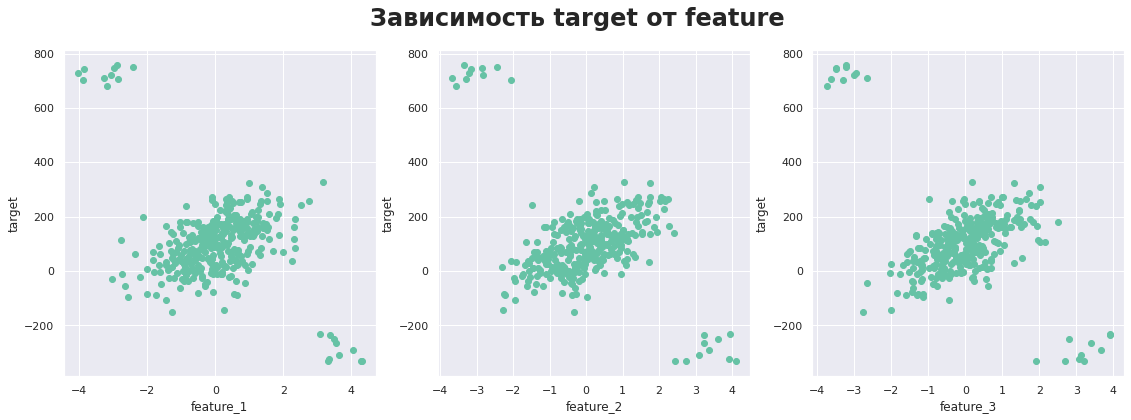

In [6]:
fig = plt.figure(figsize = (19, 6))
plt.suptitle(f'Зависимость target от feature', fontsize = 24, fontweight = 'bold')
feature = ['feature_1', 'feature_2', 'feature_3']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_train[feature[i]], y_train)
    plt.xlabel(feature[i])
    plt.ylabel('target')

Зависимость во всех случаях очень схожа и, кажется, линейной. Однако смущает наличие явных выбросов в правом нижнем и левом верхнем углах. **Какое влияние могут оказать?**

**2.** Обучите простую линейную регрессию и посчитайте качество на тестовой выборке по метрике [MSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error). Что можно сказать о качестве нашей модели?

In [7]:
linear = linear_model.LinearRegression()
linear.fit(X_train_transformed, y_train)

LinearRegression()

In [8]:
mean_squared_error(y_test, linear.predict(X_test_transformed))

17025.806610128926

**3.** Теперь обучите линейную регресcию Хьюбера и посчитайте качество на тестовой части по метрикe MSE. Что изменилось? 

In [9]:
HR = HuberRegression()
HR.fit(X_train_transformed, y_train)

HuberRegression()

In [10]:
mean_squared_error(y_test, HR.predict(X_test_transformed))

21.997262314500713

Как видно из результатов, HuberRegression предсказывает намного лучше, чем Линейная регрессия.

**4.** Используя поиск по сетке, подберите оптимальное значение гиперпараметра $c$ нашей модели. Какую метрику стоит использовать? Почему?

В качестве метрики стоит взять MAE, так как мы убедились, что выбросов много, а данная метрика хорошо работает с выбросами и позволяет получить лучше оценки

In [11]:
parameters_grid = {
    'model__c' : np.linspace(0.00001, 10, num=500),
}

model = HuberRegression()


pipe = Pipeline(steps=[
    ('stnd_sc', StandardScaler()),
    ('model', model)
])

ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
gs = GridSearchCV(
    # модель для обучения, в нашем случае Ridge
    estimator=pipe,
    # сетка значений гиперпараметров
    param_grid=parameters_grid,
    # метрика качества, берем MSE
    scoring='neg_mean_absolute_error',
    # GridSearch отлично параллелится, указываем количество параллельных джоб
    # -1 означает использование всех ядер
    n_jobs=-1,
    # стратегия кросс-валидации
    cv=ss,
    # сообщения с логами обучения: больше значение - больше сообщений
    verbose=False,
    # значение, присваиваемое scorer в случае ошибки при обучении
    error_score='raise'
)

In [12]:
gs.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV 5/5; 1/500] START model__c=1e-05............................................
[CV 5/5; 1/500] END ..........model__c=1e-05;, score=-131.298 total time=   3.0s
[CV 1/5; 4/500] START model__c=0.06013018036072145..............................
[CV 1/5; 4/500] END model__c=0.06013018036072145;, score=-77.841 total time=   2.9s
[CV 4/5; 5/500] START model__c=0.08017024048096193..............................
[CV 4/5; 5/500] END model__c=0.08017024048096193;, score=-68.453 total time=   2.9s
[CV 2/5; 7/500] START model__c=0.12025036072144289..............................
[CV 2/5; 7/500] END model__c=0.12025036072144289;, score=-79.641 total time=   2.9s
[CV 5/5; 8/500] START model__c=0.1402904208416834...............................
[CV 5/5; 8/500] END model__c=0.1402904208416834;, score=-42.134 total time=   2.3s
[CV 4/5; 9/500] START model__c=0.16033048096192387..............................
[CV 4/5; 9/500] END model__c=0.160

[CV 2/5; 2/500] START model__c=0.020050060120240482.............................
[CV 2/5; 2/500] END model__c=0.020050060120240482;, score=-116.541 total time=   3.0s
[CV 5/5; 3/500] START model__c=0.04009012024048097..............................
[CV 5/5; 3/500] END model__c=0.04009012024048097;, score=-87.090 total time=   3.2s
[CV 3/5; 5/500] START model__c=0.08017024048096193..............................
[CV 3/5; 5/500] END model__c=0.08017024048096193;, score=-105.326 total time=   2.9s
[CV 1/5; 7/500] START model__c=0.12025036072144289..............................
[CV 1/5; 7/500] END model__c=0.12025036072144289;, score=-52.740 total time=   2.7s
[CV 3/5; 8/500] START model__c=0.1402904208416834...............................
[CV 3/5; 8/500] END model__c=0.1402904208416834;, score=-102.763 total time=   3.0s
[CV 2/5; 10/500] START model__c=0.18037054108216435.............................
[CV 2/5; 10/500] END model__c=0.18037054108216435;, score=-79.668 total time=   2.8s
[CV 4/

[CV 4/5; 1/500] START model__c=1e-05............................................
[CV 4/5; 1/500] END ..........model__c=1e-05;, score=-134.785 total time=   2.8s
[CV 4/5; 2/500] START model__c=0.020050060120240482.............................
[CV 4/5; 2/500] END model__c=0.020050060120240482;, score=-107.886 total time=   3.1s
[CV 3/5; 4/500] START model__c=0.06013018036072145..............................
[CV 3/5; 4/500] END model__c=0.06013018036072145;, score=-110.891 total time=   2.9s
[CV 1/5; 6/500] START model__c=0.10021030060120241..............................
[CV 1/5; 6/500] END model__c=0.10021030060120241;, score=-60.669 total time=   3.0s
[CV 4/5; 7/500] START model__c=0.12025036072144289..............................
[CV 4/5; 7/500] END model__c=0.12025036072144289;, score=-50.324 total time=   3.3s
[CV 5/5; 9/500] START model__c=0.16033048096192387..............................
[CV 5/5; 9/500] END model__c=0.16033048096192387;, score=-40.680 total time=   3.1s
[CV 1/5; 1

[CV 1/5; 2/500] START model__c=0.020050060120240482.............................
[CV 1/5; 2/500] END model__c=0.020050060120240482;, score=-98.771 total time=   2.9s
[CV 2/5; 3/500] START model__c=0.04009012024048097..............................
[CV 2/5; 3/500] END model__c=0.04009012024048097;, score=-103.256 total time=   3.1s
[CV 2/5; 5/500] START model__c=0.08017024048096193..............................
[CV 2/5; 5/500] END model__c=0.08017024048096193;, score=-88.178 total time=   3.0s
[CV 5/5; 6/500] START model__c=0.10021030060120241..............................
[CV 5/5; 6/500] END model__c=0.10021030060120241;, score=-57.239 total time=   2.8s
[CV 4/5; 8/500] START model__c=0.1402904208416834...............................
[CV 4/5; 8/500] END model__c=0.1402904208416834;, score=-44.399 total time=   3.0s
[CV 3/5; 10/500] START model__c=0.18037054108216435.............................
[CV 3/5; 10/500] END model__c=0.18037054108216435;, score=-102.598 total time=   2.8s
[CV 5/5

[CV 5/5; 78/500] END model__c=1.5430946292585173;, score=-40.919 total time=   2.6s
[CV 3/5; 80/500] START model__c=1.5831747494989983..............................
[CV 3/5; 80/500] END model__c=1.5831747494989983;, score=-102.593 total time=   2.7s
[CV 1/5; 82/500] START model__c=1.623254869739479...............................
[CV 1/5; 82/500] END model__c=1.623254869739479;, score=-43.918 total time=   2.7s
[CV 4/5; 83/500] START model__c=1.6432949298597197..............................
[CV 4/5; 83/500] END model__c=1.6432949298597197;, score=-43.446 total time=   2.6s
[CV 2/5; 85/500] START model__c=1.6833750501002007..............................
[CV 2/5; 85/500] END model__c=1.6833750501002007;, score=-79.739 total time=   2.6s
[CV 5/5; 86/500] START model__c=1.7034151102204411..............................
[CV 5/5; 86/500] END model__c=1.7034151102204411;, score=-41.100 total time=   2.6s
[CV 3/5; 88/500] START model__c=1.7434952304609221..............................
[CV 3/5; 8

[CV 2/5; 79/500] END model__c=1.5631346893787577;, score=-80.209 total time=   2.7s
[CV 5/5; 80/500] START model__c=1.5831747494989983..............................
[CV 5/5; 80/500] END model__c=1.5831747494989983;, score=-40.963 total time=   2.7s
[CV 3/5; 82/500] START model__c=1.623254869739479...............................
[CV 3/5; 82/500] END model__c=1.623254869739479;, score=-102.857 total time=   2.7s
[CV 1/5; 84/500] START model__c=1.66333498997996................................
[CV 1/5; 84/500] END model__c=1.66333498997996;, score=-43.841 total time=   2.7s
[CV 4/5; 85/500] START model__c=1.6833750501002007..............................
[CV 4/5; 85/500] END model__c=1.6833750501002007;, score=-43.293 total time=   2.7s
[CV 2/5; 87/500] START model__c=1.7234551703406815..............................
[CV 2/5; 87/500] END model__c=1.7234551703406815;, score=-79.939 total time=   2.7s
[CV 5/5; 88/500] START model__c=1.7434952304609221..............................
[CV 5/5; 88/

[CV 4/5; 79/500] END model__c=1.5631346893787577;, score=-43.327 total time=   2.7s
[CV 2/5; 81/500] START model__c=1.6032148096192387..............................
[CV 2/5; 81/500] END model__c=1.6032148096192387;, score=-79.833 total time=   2.7s
[CV 5/5; 82/500] START model__c=1.623254869739479...............................
[CV 5/5; 82/500] END model__c=1.623254869739479;, score=-40.776 total time=   2.7s
[CV 3/5; 84/500] START model__c=1.66333498997996................................
[CV 3/5; 84/500] END model__c=1.66333498997996;, score=-103.798 total time=   2.7s
[CV 1/5; 86/500] START model__c=1.7034151102204411..............................
[CV 1/5; 86/500] END model__c=1.7034151102204411;, score=-44.175 total time=   2.7s
[CV 4/5; 87/500] START model__c=1.7234551703406815..............................
[CV 4/5; 87/500] END model__c=1.7234551703406815;, score=-44.049 total time=   2.7s
[CV 2/5; 89/500] START model__c=1.7635352905811625..............................
[CV 2/5; 89/

[CV 5/5; 81/500] END model__c=1.6032148096192387;, score=-41.165 total time=   2.6s
[CV 3/5; 83/500] START model__c=1.6432949298597197..............................
[CV 3/5; 83/500] END model__c=1.6432949298597197;, score=-102.883 total time=   2.7s
[CV 1/5; 85/500] START model__c=1.6833750501002007..............................
[CV 1/5; 85/500] END model__c=1.6833750501002007;, score=-43.990 total time=   2.6s
[CV 4/5; 86/500] START model__c=1.7034151102204411..............................
[CV 4/5; 86/500] END model__c=1.7034151102204411;, score=-43.375 total time=   2.6s
[CV 2/5; 88/500] START model__c=1.7434952304609221..............................
[CV 2/5; 88/500] END model__c=1.7434952304609221;, score=-79.832 total time=   2.6s
[CV 5/5; 89/500] START model__c=1.7635352905811625..............................
[CV 5/5; 89/500] END model__c=1.7635352905811625;, score=-41.332 total time=   2.6s
[CV 3/5; 91/500] START model__c=1.8036154108216436..............................
[CV 3/5; 

[CV 5/5; 154/500] END model__c=3.066139198396794;, score=-41.098 total time=   2.6s
[CV 2/5; 156/500] START model__c=3.106219318637275..............................
[CV 2/5; 156/500] END model__c=3.106219318637275;, score=-80.537 total time=   2.6s
[CV 5/5; 157/500] START model__c=3.1262593787575153.............................
[CV 5/5; 157/500] END model__c=3.1262593787575153;, score=-43.229 total time=   2.6s
[CV 2/5; 159/500] START model__c=3.1663394989979965.............................
[CV 2/5; 159/500] END model__c=3.1663394989979965;, score=-82.832 total time=   2.6s
[CV 4/5; 160/500] START model__c=3.1863795591182367.............................
[CV 4/5; 160/500] END model__c=3.1863795591182367;, score=-46.383 total time=   2.6s
[CV 1/5; 162/500] START model__c=3.226459679358718..............................
[CV 1/5; 162/500] END model__c=3.226459679358718;, score=-44.563 total time=   2.6s
[CV 4/5; 163/500] START model__c=3.246499739478958..............................
[CV 4/5

[CV 3/5; 158/500] START model__c=3.146299438877756..............................
[CV 3/5; 158/500] END model__c=3.146299438877756;, score=-107.843 total time=   2.8s
[CV 1/5; 160/500] START model__c=3.1863795591182367.............................
[CV 1/5; 160/500] END model__c=3.1863795591182367;, score=-45.765 total time=   2.7s
[CV 5/5; 161/500] START model__c=3.2064196192384773.............................
[CV 5/5; 161/500] END model__c=3.2064196192384773;, score=-47.417 total time=   2.7s
[CV 3/5; 163/500] START model__c=3.246499739478958..............................
[CV 3/5; 163/500] END model__c=3.246499739478958;, score=-103.505 total time=   2.8s
[CV 2/5; 165/500] START model__c=3.2865798597194393.............................
[CV 2/5; 165/500] END model__c=3.2865798597194393;, score=-85.652 total time=   2.7s
[CV 5/5; 166/500] START model__c=3.3066199198396795.............................
[CV 5/5; 166/500] END model__c=3.3066199198396795;, score=-45.256 total time=   2.7s
[CV 

[CV 1/5; 158/500] END model__c=3.146299438877756;, score=-48.632 total time=   2.7s
[CV 4/5; 159/500] START model__c=3.1663394989979965.............................
[CV 4/5; 159/500] END model__c=3.1663394989979965;, score=-46.700 total time=   2.7s
[CV 2/5; 161/500] START model__c=3.2064196192384773.............................
[CV 2/5; 161/500] END model__c=3.2064196192384773;, score=-83.005 total time=   2.7s
[CV 5/5; 162/500] START model__c=3.226459679358718..............................
[CV 5/5; 162/500] END model__c=3.226459679358718;, score=-44.156 total time=   2.7s
[CV 1/5; 164/500] START model__c=3.2665397995991987.............................
[CV 1/5; 164/500] END model__c=3.2665397995991987;, score=-47.818 total time=   2.7s
[CV 4/5; 165/500] START model__c=3.2865798597194393.............................
[CV 4/5; 165/500] END model__c=3.2865798597194393;, score=-46.299 total time=   2.7s
[CV 2/5; 167/500] START model__c=3.32665997995992...............................
[CV 2/

[CV 4/5; 162/500] END model__c=3.226459679358718;, score=-45.926 total time=   3.0s
[CV 2/5; 164/500] START model__c=3.2665397995991987.............................
[CV 2/5; 164/500] END model__c=3.2665397995991987;, score=-82.572 total time=   3.0s
[CV 1/5; 166/500] START model__c=3.3066199198396795.............................
[CV 1/5; 166/500] END model__c=3.3066199198396795;, score=-47.944 total time=   3.0s
[CV 4/5; 167/500] START model__c=3.32665997995992...............................
[CV 4/5; 167/500] END model__c=3.32665997995992;, score=-47.651 total time=   3.0s
[CV 2/5; 169/500] START model__c=3.3667401002004014.............................
[CV 2/5; 169/500] END model__c=3.3667401002004014;, score=-83.018 total time=   3.0s
[CV 5/5; 170/500] START model__c=3.3867801603206416.............................
[CV 5/5; 170/500] END model__c=3.3867801603206416;, score=-46.233 total time=   2.9s
[CV 5/5; 172/500] START model__c=3.426860280561123..............................
[CV 5/5

[CV 4/5; 230/500] END model__c=4.58918376753507;, score=-49.416 total time=   2.8s
[CV 2/5; 232/500] START model__c=4.629263887775551..............................
[CV 2/5; 232/500] END model__c=4.629263887775551;, score=-90.030 total time=   2.6s
[CV 5/5; 233/500] START model__c=4.649303947895792..............................
[CV 5/5; 233/500] END model__c=4.649303947895792;, score=-45.019 total time=   2.6s
[CV 2/5; 235/500] START model__c=4.689384068136272..............................
[CV 2/5; 235/500] END model__c=4.689384068136272;, score=-84.042 total time=   2.6s
[CV 5/5; 236/500] START model__c=4.709424128256513..............................
[CV 5/5; 236/500] END model__c=4.709424128256513;, score=-42.411 total time=   2.6s
[CV 3/5; 238/500] START model__c=4.749504248496994..............................
[CV 3/5; 238/500] END model__c=4.749504248496994;, score=-109.306 total time=   2.7s
[CV 1/5; 240/500] START model__c=4.789584368737475..............................
[CV 1/5; 2

[CV 2/5; 236/500] START model__c=4.709424128256513..............................
[CV 2/5; 236/500] END model__c=4.709424128256513;, score=-88.500 total time=   2.7s
[CV 5/5; 237/500] START model__c=4.729464188376753..............................
[CV 5/5; 237/500] END model__c=4.729464188376753;, score=-45.026 total time=   2.7s
[CV 3/5; 239/500] START model__c=4.769544308617235..............................
[CV 3/5; 239/500] END model__c=4.769544308617235;, score=-107.175 total time=   2.7s
[CV 1/5; 241/500] START model__c=4.809624428857715..............................
[CV 1/5; 241/500] END model__c=4.809624428857715;, score=-59.681 total time=   2.7s
[CV 4/5; 242/500] START model__c=4.829664488977956..............................
[CV 4/5; 242/500] END model__c=4.829664488977956;, score=-57.800 total time=   2.7s
[CV 2/5; 244/500] START model__c=4.869744609218437..............................
[CV 2/5; 244/500] END model__c=4.869744609218437;, score=-83.472 total time=   2.7s
[CV 5/5; 

[CV 2/5; 237/500] START model__c=4.729464188376753..............................
[CV 2/5; 237/500] END model__c=4.729464188376753;, score=-82.646 total time=   2.7s
[CV 5/5; 238/500] START model__c=4.749504248496994..............................
[CV 5/5; 238/500] END model__c=4.749504248496994;, score=-45.639 total time=   2.7s
[CV 3/5; 240/500] START model__c=4.789584368737475..............................
[CV 3/5; 240/500] END model__c=4.789584368737475;, score=-105.767 total time=   2.7s
[CV 1/5; 242/500] START model__c=4.829664488977956..............................
[CV 1/5; 242/500] END model__c=4.829664488977956;, score=-52.859 total time=   2.7s
[CV 4/5; 243/500] START model__c=4.849704549098196..............................
[CV 4/5; 243/500] END model__c=4.849704549098196;, score=-51.040 total time=   2.6s
[CV 2/5; 245/500] START model__c=4.8897846693386775.............................
[CV 2/5; 245/500] END model__c=4.8897846693386775;, score=-80.398 total time=   2.7s
[CV 5/5;

[CV 3/5; 244/500] START model__c=4.869744609218437..............................
[CV 3/5; 244/500] END model__c=4.869744609218437;, score=-117.666 total time=   2.7s
[CV 1/5; 246/500] START model__c=4.909824729458918..............................
[CV 1/5; 246/500] END model__c=4.909824729458918;, score=-58.192 total time=   2.7s
[CV 4/5; 247/500] START model__c=4.929864789579159..............................
[CV 4/5; 247/500] END model__c=4.929864789579159;, score=-46.224 total time=   2.6s
[CV 2/5; 249/500] START model__c=4.969944909819639..............................
[CV 2/5; 249/500] END model__c=4.969944909819639;, score=-91.478 total time=   2.6s
[CV 3/5; 250/500] START model__c=4.98998496993988...............................
[CV 3/5; 250/500] END model__c=4.98998496993988;, score=-105.033 total time=   2.7s
[CV 1/5; 252/500] START model__c=5.0300650901803605.............................
[CV 1/5; 252/500] END model__c=5.0300650901803605;, score=-51.140 total time=   2.6s
[CV 4/5;

[CV 1/5; 308/500] START model__c=6.152308456913828..............................
[CV 1/5; 308/500] END model__c=6.152308456913828;, score=-47.303 total time=   2.6s
[CV 3/5; 309/500] START model__c=6.172348517034068..............................
[CV 3/5; 309/500] END model__c=6.172348517034068;, score=-111.692 total time=   2.6s
[CV 1/5; 311/500] START model__c=6.21242863727455...............................
[CV 1/5; 311/500] END model__c=6.21242863727455;, score=-44.571 total time=   2.6s
[CV 4/5; 312/500] START model__c=6.23246869739479...............................
[CV 4/5; 312/500] END model__c=6.23246869739479;, score=-44.948 total time=   2.6s
[CV 2/5; 314/500] START model__c=6.272548817635271..............................
[CV 2/5; 314/500] END model__c=6.272548817635271;, score=-87.394 total time=   2.6s
[CV 5/5; 315/500] START model__c=6.292588877755511..............................
[CV 5/5; 315/500] END model__c=6.292588877755511;, score=-42.491 total time=   2.6s
[CV 3/5; 31

[CV 4/5; 314/500] END model__c=6.272548817635271;, score=-48.645 total time=   2.6s
[CV 2/5; 316/500] START model__c=6.312628937875751..............................
[CV 2/5; 316/500] END model__c=6.312628937875751;, score=-102.992 total time=   2.7s
[CV 5/5; 317/500] START model__c=6.3326689979959925.............................
[CV 5/5; 317/500] END model__c=6.3326689979959925;, score=-42.901 total time=   2.7s
[CV 3/5; 319/500] START model__c=6.372749118236473..............................
[CV 3/5; 319/500] END model__c=6.372749118236473;, score=-114.044 total time=   2.7s
[CV 1/5; 321/500] START model__c=6.412829238476954..............................
[CV 1/5; 321/500] END model__c=6.412829238476954;, score=-46.104 total time=   2.7s
[CV 4/5; 322/500] START model__c=6.432869298597194..............................
[CV 4/5; 322/500] END model__c=6.432869298597194;, score=-50.003 total time=   2.6s
[CV 2/5; 324/500] START model__c=6.4729494188376755.............................
[CV 2/5

[CV 3/5; 315/500] END model__c=6.292588877755511;, score=-104.181 total time=   2.7s
[CV 1/5; 317/500] START model__c=6.3326689979959925.............................
[CV 1/5; 317/500] END model__c=6.3326689979959925;, score=-51.829 total time=   2.7s
[CV 4/5; 318/500] START model__c=6.352709058116233..............................
[CV 4/5; 318/500] END model__c=6.352709058116233;, score=-46.357 total time=   2.7s
[CV 2/5; 320/500] START model__c=6.392789178356714..............................
[CV 2/5; 320/500] END model__c=6.392789178356714;, score=-87.393 total time=   2.7s
[CV 5/5; 321/500] START model__c=6.412829238476954..............................
[CV 5/5; 321/500] END model__c=6.412829238476954;, score=-53.274 total time=   2.7s
[CV 3/5; 323/500] START model__c=6.452909358717435..............................
[CV 3/5; 323/500] END model__c=6.452909358717435;, score=-109.126 total time=   2.7s
[CV 1/5; 325/500] START model__c=6.492989478957916..............................
[CV 1/5

[CV 3/5; 335/500] START model__c=6.693390080160321..............................
[CV 3/5; 335/500] END model__c=6.693390080160321;, score=-104.221 total time=   3.0s
[CV 1/5; 337/500] START model__c=6.733470200400802..............................
[CV 1/5; 337/500] END model__c=6.733470200400802;, score=-57.621 total time=   3.0s
[CV 4/5; 338/500] START model__c=6.753510260521042..............................
[CV 4/5; 338/500] END model__c=6.753510260521042;, score=-50.272 total time=   3.0s
[CV 3/5; 340/500] START model__c=6.793590380761524..............................
[CV 3/5; 340/500] END model__c=6.793590380761524;, score=-111.144 total time=   3.0s
[CV 2/5; 342/500] START model__c=6.833670501002004..............................
[CV 2/5; 342/500] END model__c=6.833670501002004;, score=-92.066 total time=   3.0s
[CV 3/5; 344/500] START model__c=6.873750621242485..............................
[CV 3/5; 344/500] END model__c=6.873750621242485;, score=-113.391 total time=   3.0s
[CV 1/5

[CV 3/5; 389/500] END model__c=7.775553326653307;, score=-117.581 total time=   2.7s
[CV 2/5; 391/500] START model__c=7.815633446893788..............................
[CV 2/5; 391/500] END model__c=7.815633446893788;, score=-88.262 total time=   2.7s
[CV 5/5; 392/500] START model__c=7.835673507014028..............................
[CV 5/5; 392/500] END model__c=7.835673507014028;, score=-55.742 total time=   2.7s
[CV 3/5; 394/500] START model__c=7.875753627254509..............................
[CV 3/5; 394/500] END model__c=7.875753627254509;, score=-110.487 total time=   2.7s
[CV 1/5; 396/500] START model__c=7.9158337474949905.............................
[CV 1/5; 396/500] END model__c=7.9158337474949905;, score=-54.253 total time=   2.7s
[CV 4/5; 397/500] START model__c=7.935873807615231..............................
[CV 4/5; 397/500] END model__c=7.935873807615231;, score=-49.793 total time=   2.7s
[CV 2/5; 399/500] START model__c=7.975953927855712..............................
[CV 2/5

[CV 4/5; 393/500] START model__c=7.855713567134269..............................
[CV 4/5; 393/500] END model__c=7.855713567134269;, score=-48.020 total time=   2.7s
[CV 2/5; 395/500] START model__c=7.895793687374749..............................
[CV 2/5; 395/500] END model__c=7.895793687374749;, score=-84.313 total time=   2.7s
[CV 5/5; 396/500] START model__c=7.9158337474949905.............................
[CV 5/5; 396/500] END model__c=7.9158337474949905;, score=-58.142 total time=   2.6s
[CV 3/5; 398/500] START model__c=7.955913867735471..............................
[CV 3/5; 398/500] END model__c=7.955913867735471;, score=-109.041 total time=   2.7s
[CV 1/5; 400/500] START model__c=7.995993987975952..............................
[CV 1/5; 400/500] END model__c=7.995993987975952;, score=-57.396 total time=   2.7s
[CV 4/5; 401/500] START model__c=8.016034048096193..............................
[CV 4/5; 401/500] END model__c=8.016034048096193;, score=-56.556 total time=   2.6s
[CV 2/5;

[CV 3/5; 395/500] START model__c=7.895793687374749..............................
[CV 3/5; 395/500] END model__c=7.895793687374749;, score=-128.580 total time=   2.7s
[CV 1/5; 397/500] START model__c=7.935873807615231..............................
[CV 1/5; 397/500] END model__c=7.935873807615231;, score=-53.939 total time=   2.7s
[CV 4/5; 398/500] START model__c=7.955913867735471..............................
[CV 4/5; 398/500] END model__c=7.955913867735471;, score=-52.920 total time=   2.7s
[CV 2/5; 400/500] START model__c=7.995993987975952..............................
[CV 2/5; 400/500] END model__c=7.995993987975952;, score=-89.113 total time=   2.7s
[CV 5/5; 401/500] START model__c=8.016034048096193..............................
[CV 5/5; 401/500] END model__c=8.016034048096193;, score=-58.703 total time=   2.7s
[CV 3/5; 403/500] START model__c=8.056114168336673..............................
[CV 3/5; 403/500] END model__c=8.056114168336673;, score=-114.733 total time=   2.8s
[CV 1/5;

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.25, train_size=None),
             error_score='raise',
             estimator=Pipeline(steps=[('stnd_sc', StandardScaler()),
                                       ('model', HuberRegression())]),
             n_jobs=-1,
             param_grid={'model__c': array([1.00000000e-05, 2.00500601e-02, 4.00901202e-02, 6.01301804e-02,
       8.01702405e-02, 1.00210301e-01, 1.20250361e-01, 1.40290421e-0...
       9.53907862e+00, 9.55911868e+00, 9.57915874e+00, 9.59919880e+00,
       9.61923886e+00, 9.63927892e+00, 9.65931898e+00, 9.67935904e+00,
       9.69939910e+00, 9.71943916e+00, 9.73947922e+00, 9.75951928e+00,
       9.77955934e+00, 9.79959940e+00, 9.81963946e+00, 9.83967952e+00,
       9.85971958e+00, 9.87975964e+00, 9.89979970e+00, 9.91983976e+00,
       9.93987982e+00, 9.95991988e+00, 9.97995994e+00, 1.00000000e+01])},
             scoring='neg_mean_absolute_error', verbose=10)

In [13]:
gs.best_estimator_

Pipeline(steps=[('stnd_sc', StandardScaler()),
                ('model', HuberRegression(c=0.6813720440881764))])

**5.** Для обучающей выборки постройте два графика (по графику на каждую модель), на которых изобразите зависимость истинного и предсказанного значения таргета от каждого признака. Что можно заметить на этих графиках?

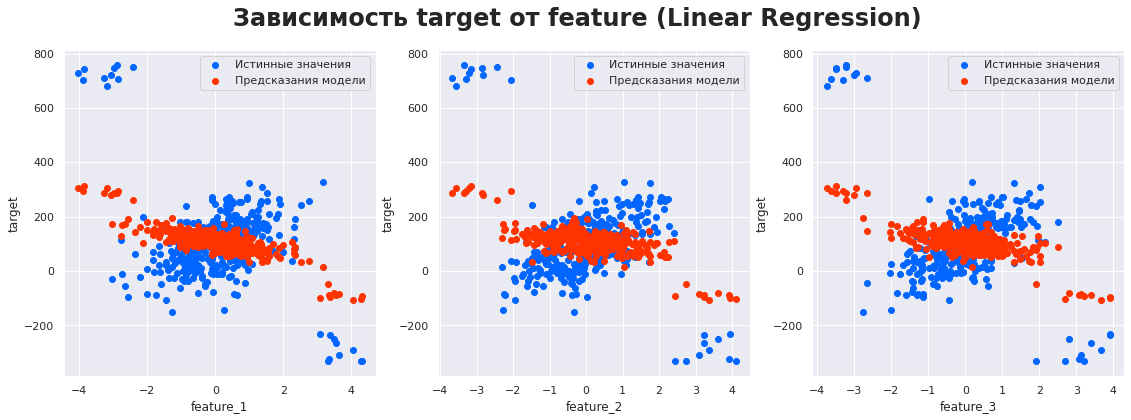

In [20]:
fig = plt.figure(figsize = (19, 6))
y_pred = linear.predict(X_train_transformed)
plt.suptitle(f'Зависимость target от feature (Linear Regression)', fontsize = 24, fontweight = 'bold')
feature = ['feature_1', 'feature_2', 'feature_3']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_train[feature[i]], y_train, color = '#0066FF', label = 'Истинные значения')
    plt.scatter(X_train[feature[i]], y_pred, color='#FF3300', label = 'Предсказания модели')
    plt.xlabel(feature[i])
    plt.ylabel('target')
    plt.legend()

In [18]:
model_Hub = HuberRegression(c = 0.6813720440881764).fit(X_train_transformed, y_train)

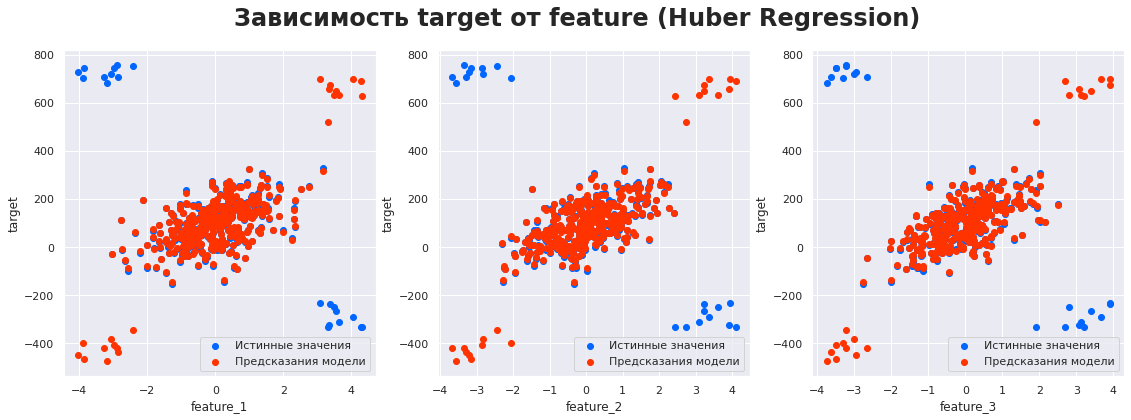

In [19]:
fig = plt.figure(figsize = (19, 6))
y_pred = model_Hub.predict(X_train_transformed)
plt.suptitle(f'Зависимость target от feature (Huber Regression)', fontsize = 24, fontweight = 'bold')
feature = ['feature_1', 'feature_2', 'feature_3']
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.scatter(X_train[feature[i]], y_train, color = '#0066FF', label = 'Истинные значения')
    plt.scatter(X_train[feature[i]], y_pred, color='#FF3300', label = 'Предсказания модели')
    plt.xlabel(feature[i])
    plt.ylabel('target')
    plt.legend()

**Вывод:**

1) Была реализована модель HuberRegression, которая показала себя намного лучше, чем Линейная регрессия.

2) Были обнаружены выбросы в данных (по всем признакам). Из-за чего было решено искать оценку минимизируя Mean absolute error, так как она устойчивее к выбросам, чем MSE.

3) По последним графикам мы явно видим, что Huber Regression работает очень неплохо. 